In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter

from pathlib import Path
import os
import pandas as pd

# Check package versions
import gammapy
import numpy as np
import astropy
import regions

print("gammapy:", gammapy.__version__)
print("numpy:", np.__version__)
print("astropy", astropy.__version__)
print("regions", regions.__version__)

import yaml

import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
#from gammapy.irf import EnergyDependentTablePSF, EDispKernel #EnergyDispersion
from gammapy.maps import Map, MapAxis, WcsNDMap, WcsGeom
from gammapy.datasets import MapDataset, Datasets
from gammapy.modeling import Fit
#from gammapy.data import EventList, ObservationStats, ObservationSummary, DataStore
from gammapy.data import EventList, DataStore
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    LogParabolaSpectralModel,
    ExpCutoffPowerLawSpectralModel, 
    create_crab_spectral_model,
    TemplateSpectralModel,
    PointSpatialModel,
    ConstantSpatialModel,
    SkyModel,
    TemplateSpatialModel,
    Models, #SkyModels,
    #BackgroundModel, 
    create_fermi_isotropic_diffuse_model,
)


from gammapy.estimators import FluxPointsEstimator, FluxPoints, TSMapEstimator
from gammapy.estimators.utils import find_peaks

from gammapy.datasets import (
    #SpectrumDatasetMaker,
    #SpectrumDatasetOnOff,
    SpectrumDataset,
    FluxPointsDataset,
    #ReflectedRegionsBackgroundMaker,
    #plot_spectrum_datasets_off_regions,
)

from gammapy.analysis import Analysis, AnalysisConfig
from astropy.convolution import Gaussian2DKernel





gammapy: 1.0
numpy: 1.22.3
astropy 5.0.2
regions 0.5


/Users/qifeng/.pyenv/versions/gammapy-env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
flux_points_joint = FluxPoints.read("1ES1011_flare_joint_flux_points.ecsv")
flux_points_joint.table_formatted

ValueError: MapAxis: node values must be sorted

In [3]:
flux_points_fermi = FluxPoints.read("1ES1011_flare_fermi_flux_points.ecsv")
flux_points_veritas = FluxPoints.read("1ES1011_flare_veritas_flux_points.ecsv")
flux_points_veritas_all = FluxPoints.read("1ES1011_all_veritas_flux_points.ecsv")
flux_points_fermi_all = FluxPoints.read("1ES1011_all_fermi_flux_points_30bin.ecsv")

flux_points_joint_all = FluxPoints.stack([flux_points_fermi_all, flux_points_veritas_all])


In [4]:
flux_points_fermi_all

FluxPoints(sed_type='dnde', n_points=30)

In [3]:
# old fit
from scipy.optimize import curve_fit

def chisq(y_vals, y_expected, y_errs, num_params=1):
    #returns chi2, dof, red_chi2
    #  for reduced chisq test, under the assumption of Poisson counting
    #  we have lnL = const - (1/2.)*chi2
    if y_vals.shape[0] != y_expected.shape[0]:
        print("Inconsistent input sizes")
        return
    #z = (y_vals[i] - y_expected[i]) / y_errs[i]    
    z = (y_vals - y_expected) / y_errs
    chi2 = np.sum(z ** 2)
    chi2dof = chi2 / (y_vals.shape[0] - num_params)
    return chi2, (y_vals.shape[0] - num_params), chi2dof




def fit_factory(model, x, y, dy=None, p0=[1.2e-11, -3.6], maxfev=5000, bounds=(-np.inf, np.inf), plotEs=None):
    if dy is not None:
        paramsPLlog, covariacesPLlog = curve_fit(model, x,
                                           y, p0=p0,
                                                 bounds=bounds, 
                                           sigma=dy, 
                                             absolute_sigma=True, 
                                                maxfev=maxfev) #approx abs
    else:
        paramsPLlog, covariacesPLlog = curve_fit(model, x,
                                           y, p0=p0, bounds=bounds, maxfev=maxfev)
        
    for i in range(len(p0)):
        print("best-fit param %d = %.4g +/- %.4g" % (i, paramsPLlog[i], np.sqrt(abs(covariacesPLlog[i,i]))))



    chi2LC, dofLC, redchi2LC = chisq(y, 
                                      model(x, *paramsPLlog), 
                                      dy, 
                                      len(p0))
    lnL_LC = -0.5*chi2LC
    print("fit Chisq is %.3f, dof is %d, reduced Chisq is %.2f" % (chi2LC, dofLC, redchi2LC))
    print("Log likelihood lnL={0}".format(lnL_LC))
    return paramsPLlog, np.diag(covariacesPLlog)**0.5, chi2LC, dofLC, redchi2LC

import scipy
def fit_factory_boundMC(model, x, y, dy=None, p0=[1.2e-11, -3.6], 
                        maxfev=5000, bounds=(-np.inf, np.inf), 
                        Nsim=2000, plotEs=None):
    if dy is not None:
        #paramsPLlog, covariacesPLlog = curve_fit(model, x,
        #                                   y, p0=p0,
        #                                   sigma=dy, 
        #                                     absolute_sigma=True) #approx abs
    #else:
        #paramsPLlog, covariacesPLlog = curve_fit(model, x,
        #                                   y, p0=p0)
        paramsPLlog, covariacesPLlog = curve_fit(model, x,
                                           y, p0=p0,
                                                 bounds=bounds, 
                                           sigma=dy, 
                                             absolute_sigma=True, 
                                                maxfev=maxfev) #approx abs
    else:
        paramsPLlog, covariacesPLlog = curve_fit(model, x,
                                           y, p0=p0, bounds=bounds, maxfev=maxfev)

    for i in range(len(p0)):
        print("MC best-fit param %d = %.4g +/- %.4g" % (i, paramsPLlog[i], np.sqrt(abs(covariacesPLlog[i,i]))))



    chi2LC, dofLC, redchi2LC = chisq(y, 
                                      model(x, *paramsPLlog), 
                                      dy, 
                                      len(p0))
    lnL_LC = -0.5*chi2LC
    print("MC fit Chisq is %.3f, dof is %d, reduced Chisq is %.2f" % (chi2LC, dofLC, redchi2LC))
    print("MC Log likelihood lnL={0}".format(lnL_LC))
    
    # Use some MC
    #print(type(x), x)
    #print(float(x[0]), float(x[-1]))
    if plotEs is not None: 
        x_values = plotEs
    else:
        x_values = np.logspace(np.log10(float( min(np.array(x)) )) , np.log10(float( max(np.array(x)) )), 100)
    rng = np.random.RandomState(seed=76)
    parameter_samples = rng.multivariate_normal(paramsPLlog, covariacesPLlog, Nsim)
    #print(paramsPLlog, covariacesPLlog)
    
    #print(parameter_samples.shape)
    realizations = np.array([model(x_values, *pars) for pars in parameter_samples])

    qlo = 100 * scipy.stats.norm.cdf(-1)    #1 is the 1 sigma
    y_low = np.percentile(realizations, qlo, axis=0)
    qhi = 100 * scipy.stats.norm.cdf(1)     #1 is the 1 sigma
    y_high = np.percentile(realizations, qhi, axis=0)
    
    #print(y_low.shape)
    
    return paramsPLlog, np.diag(covariacesPLlog)**0.5, chi2LC, dofLC, redchi2LC, x_values, y_low, y_high




def e_log_para(E, N0, Ind, Ep):
    #Ind is negative
    #return N0*(np.array(E)/1.)**(Ind)
    return N0*10.0**(Ind*(np.log10(np.array(E)/Ep))**2)/np.array(E)**2

def log_para(E, N0, alpha, beta, Eb):
    return N0*(E/Eb)**(-alpha-beta*np.log10(np.array(E)/Eb))

def log_para300GeV(E, N0, alpha, beta):
    return N0*(E/0.3)**(-alpha-beta*np.log10(np.array(E)/0.3))

def log_para300GeV_natural(E, N0, alpha, beta):
    return N0*(E/0.3)**(-alpha-beta*np.log(np.array(E)/0.3))



def log_log_para(E, N0, alpha, beta, Eb):
    return np.log10(N0)+(-alpha-beta*np.log10(np.array(E)/Eb))*np.log10(np.array(E)/Eb)


def plec2(E, N0, gamma, E0, Ec_inv, alpha):
    return N0*(E/E0)**(-gamma)*np.exp( -(Ec_inv*np.array(E))**alpha )



fLP = lambda E,N0,alpha,beta,Eb: N0*(E/Eb)**(-alpha-beta*np.log10(np.array(E)/Eb))
ferrLP = lambda E,F,N0,N0err,alpha,dalpha,beta,dbeta,Eb: \
        F*np.sqrt(N0err**2/N0**2 + (np.log(E/Eb))**2 * dalpha**2 + \
                  (np.log(E/Eb))**2 * (np.log10(E/Eb))**2 * dbeta**2)

fPL = lambda E,N0,E0,gamma: N0*(E/E0)**(-1*gamma)
ferrPL = lambda E,F,N0,N0err,E0,cov_gg: F*np.sqrt(N0err**2/N0**2 + ((np.log(E/E0))**2)*cov_gg)








    

best-fit param 0 = 4.544e-11 +/- 1.796e-12
best-fit param 1 = 2.657 +/- 0.02164
best-fit param 2 = 0.1086 +/- 0.003224
fit Chisq is 181.450, dof is 28, reduced Chisq is 6.48
Log likelihood lnL=-90.72506420781282


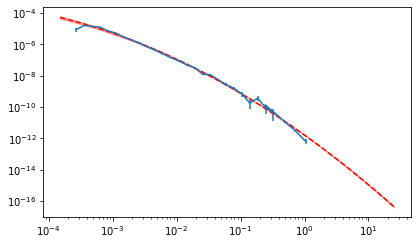

In [6]:
ps_lp, dps_lp, chi2_lp, dof_lp, redchi2_lp = fit_factory(log_para300GeV_natural, 
                                                   flux_points_joint_all.table[flux_points_joint_all.table['is_ul']==0]['e_ref']/1e3, 
                                                   flux_points_joint_all.table[flux_points_joint_all.table['is_ul']==0]['dnde'], 
                                                   dy=flux_points_joint_all.table[flux_points_joint_all.table['is_ul']==0]['dnde_err'], 
                                                   p0=[3.2e-11, 2.6, 0.2])

#plotEs = np.logspace(np.log10(0.15),np.log10(25000),100)
plotEs = np.logspace(np.log10(0.15e-3),np.log10(25),100)

model_lp = log_para300GeV_natural(plotEs, ps_lp[0], ps_lp[1], ps_lp[2]) 
model_errlp = ferrLP(plotEs, model_lp, ps_lp[0],dps_lp[0], 
                         ps_lp[1],dps_lp[1], ps_lp[2],dps_lp[2], 0.3)


fig = plt.figure()

fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)

ax = fig.add_subplot(111)

plt.errorbar(flux_points_joint_all.table[flux_points_joint_all.table['is_ul']==0]['e_ref']/1e3, 
                flux_points_joint_all.table[flux_points_joint_all.table['is_ul']==0]['dnde'], 
                flux_points_joint_all.table[flux_points_joint_all.table['is_ul']==0]['dnde_err'], 
            )
plt.plot(plotEs, model_lp, color='r', ls='--')
plt.fill_between(plotEs,(model_lp-model_errlp),
                    (model_lp+model_errlp),alpha=0.3,color='r')
ax.set_xscale('log')
ax.set_yscale('log')

In [17]:
dfrev = pd.read_csv("/home/qifeng/Downloads/test_review_xray_I.csv", names=['E', 'F'])

fPL3 = lambda E,N0,gamma: N0*(E/3.)**(-1*gamma)

fake_err = (dfrev['F'].values)/10.
print(fake_err)
fake_err[-1] = dfrev['F'].values[-1]/5.
print(fake_err)

ps_lp, dps_lp, chi2_lp, dof_lp, redchi2_lp = fit_factory(fPL3, 
                                                        dfrev['E'], dfrev['F'],
                                                         #dy=(dfrev['F'])/5., 
                                                         dy=fake_err, 
                                                         #dy=flux_points_joint_all.table[flux_points_joint_all.table['is_ul']==0]['dnde_err'], 
                                                   p0=[3.2e-12, 0.2])

#plotEs = np.logspace(np.log10(0.15),np.log10(25000),100)
plotEs = np.logspace(np.log10(1),np.log10(10),100)

model_pl = fPL3(plotEs, ps_lp[0], ps_lp[1]) 
model_errpl = ferrPL(plotEs, model_pl, ps_lp[0],dps_lp[0], 0.3, 
                         dps_lp[1]**2)



fig = plt.figure()

fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)

ax = fig.add_subplot(111)

plt.errorbar(dfrev['E'], dfrev['F'], fake_err,ls="", marker="o")
plt.plot(plotEs, model_pl, color='r', ls='--')
plt.fill_between(plotEs,(model_pl-model_errpl),
                    (model_pl+model_errpl),alpha=0.3,color='r', )
ax.set_xscale('log')
ax.set_yscale('log')
plt.xlabel("keV")
plt.ylabel(r"$\nu F_{\nu}$")

plt.tight_layout()
plt.savefig("test_fit.png")

FileNotFoundError: [Errno 2] No such file or directory: '/home/qifeng/Downloads/test_review_xray_I.csv'

flare params: 

amplitude 1.098e-15 1.108e-15 cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+01 0.000e+00            TeV nan nan   True
    alpha 4.085e+00 4.091e-01                nan nan  False
     beta 1.693e-01 3.421e-02                nan nan  False

all params: 
best-fit param 0 = 4.544e-11 +/- 1.796e-12
best-fit param 1 = 2.657 +/- 0.02164
best-fit param 2 = 0.1086 +/- 0.003224



[4.65997787e-13 5.11978817e-13 4.85336469e-13 4.75016664e-13
 4.79173655e-13 4.61525957e-13 4.34621454e-13 4.09570733e-13
 4.82525425e-13 3.64690860e-13 3.88077114e-13 4.34242925e-13
 2.86321132e-13]
[4.65997787e-13 5.11978817e-13 4.85336469e-13 4.75016664e-13
 4.79173655e-13 4.61525957e-13 4.34621454e-13 4.09570733e-13
 4.82525425e-13 3.64690860e-13 3.88077114e-13 4.34242925e-13
 5.72642263e-13]
best-fit param 0 = 6.571e-12 +/- 8.31e-12
best-fit param 1 = 0.1649 +/- 0.5576
best-fit param 2 = 0.03784 +/- 0.2062
fit Chisq is 7.532, dof is 10, reduced Chisq is 0.75
Log likelihood lnL=-3.765882287263681


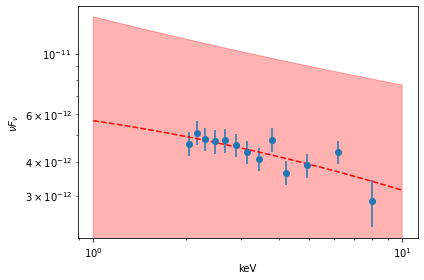

In [55]:
dfrev = pd.read_csv("/home/qifeng/Downloads/test_review_xray_I.csv", names=['E', 'F'])

fPL3 = lambda E,N0,gamma: N0*(E/3.)**(-1*gamma)

fake_err = (dfrev['F'].values)/10.
print(fake_err)
fake_err[-1] = dfrev['F'].values[-1]/5.
print(fake_err)

def log_para3keV_natural(E, N0, alpha, beta):
    return N0*(E/0.3)**(-alpha-beta*np.log(np.array(E)/3))


ps_lp, dps_lp, chi2_lp, dof_lp, redchi2_lp = fit_factory(log_para3keV_natural, 
                                                        dfrev['E'], dfrev['F'],
                                                         #dy=(dfrev['F'])/5., 
                                                         dy=fake_err, 
                                                         #dy=flux_points_joint_all.table[flux_points_joint_all.table['is_ul']==0]['dnde_err'], 
                                                         p0=[6e-12, 0.2, 0.04])

#plotEs = np.logspace(np.log10(0.15),np.log10(25000),100)
plotEs = np.logspace(np.log10(1),np.log10(10),100)

model_lp = log_para3keV_natural(plotEs, ps_lp[0], ps_lp[1], ps_lp[2]) 
model_errlp = ferrLP(plotEs, model_lp, ps_lp[0],dps_lp[0], 
                         ps_lp[1],dps_lp[1], ps_lp[2],dps_lp[2], 3)




fig = plt.figure()

fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)

ax = fig.add_subplot(111)

plt.errorbar(dfrev['E'], dfrev['F'], fake_err,ls="", marker="o")
plt.plot(plotEs, model_lp, color='r', ls='--')
plt.fill_between(plotEs,(model_lp-model_errlp),
                    (model_lp+model_errlp),alpha=0.3,color='r')
ax.set_xscale('log')
ax.set_yscale('log')
plt.xlabel("keV")
plt.ylabel(r"$\nu F_{\nu}$")
plt.tight_layout()
plt.savefig("test_fit_LP.png")

[4.65997787e-13 5.11978817e-13 4.85336469e-13 4.75016664e-13
 4.79173655e-13 4.61525957e-13 4.34621454e-13 4.09570733e-13
 4.82525425e-13 3.64690860e-13 3.88077114e-13 4.34242925e-13
 2.86321132e-13]
[4.65997787e-13 5.11978817e-13 4.85336469e-13 4.75016664e-13
 4.79173655e-13 4.61525957e-13 4.34621454e-13 4.09570733e-13
 4.82525425e-13 3.64690860e-13 3.88077114e-13 4.34242925e-13
 5.72642263e-13]
best-fit param 0 = 6.571e-12 +/- 8.31e-12
best-fit param 1 = 0.1649 +/- 0.5576
best-fit param 2 = 0.03784 +/- 0.2062
fit Chisq is 7.532, dof is 10, reduced Chisq is 0.75
Log likelihood lnL=-3.765882287263681


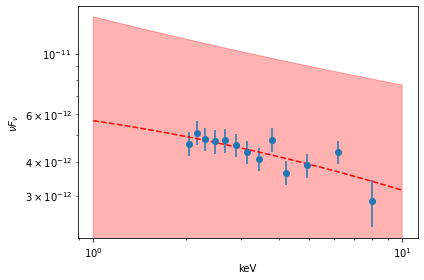

In [56]:
dfrev = pd.read_csv("/home/qifeng/Downloads/test_review_xray_I.csv", names=['E', 'F'])

fPL3 = lambda E,N0,gamma: N0*(E/3.)**(-1*gamma)

fake_err = (dfrev['F'].values)/10.
print(fake_err)
fake_err[-1] = dfrev['F'].values[-1]/5.
print(fake_err)

def log_para3keV_natural(E, N0, alpha, beta):
    return N0*(E/0.3)**(-alpha-beta*np.log(np.array(E)/3))


ps_lp, dps_lp, chi2_lp, dof_lp, redchi2_lp = fit_factory(log_para3keV_natural, 
                                                        dfrev['E'], dfrev['F'],
                                                         #dy=(dfrev['F'])/5., 
                                                         dy=fake_err, 
                                                         #dy=flux_points_joint_all.table[flux_points_joint_all.table['is_ul']==0]['dnde_err'], 
                                                         p0=[6e-12, 0.2, 0.04])

#plotEs = np.logspace(np.log10(0.15),np.log10(25000),100)
plotEs = np.logspace(np.log10(1),np.log10(10),100)

model_lp = log_para3keV_natural(plotEs, ps_lp[0], ps_lp[1], ps_lp[2]) 
model_errlp = ferrLP(plotEs, model_lp, ps_lp[0],dps_lp[0], 
                         ps_lp[1],dps_lp[1], ps_lp[2],dps_lp[2], 3)




fig = plt.figure()

fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)

ax = fig.add_subplot(111)

plt.errorbar(dfrev['E'], dfrev['F'], fake_err,ls="", marker="o")
plt.plot(plotEs, model_lp, color='r', ls='--')
plt.fill_between(plotEs,(model_lp-model_errlp),
                    (model_lp+model_errlp),alpha=0.3,color='r')
ax.set_xscale('log')
ax.set_yscale('log')
plt.xlabel("keV")
plt.ylabel(r"$\nu F_{\nu}$")
plt.tight_layout()
plt.savefig("test_fit_LP.png")

In [57]:
model_lp, model_errlp

(array([5.66473112e-12, 5.64241146e-12, 5.61994963e-12, 5.59734806e-12,
        5.57460914e-12, 5.55173530e-12, 5.52872895e-12, 5.50559252e-12,
        5.48232846e-12, 5.45893919e-12, 5.43542717e-12, 5.41179484e-12,
        5.38804466e-12, 5.36417908e-12, 5.34020058e-12, 5.31611160e-12,
        5.29191462e-12, 5.26761211e-12, 5.24320653e-12, 5.21870036e-12,
        5.19409606e-12, 5.16939612e-12, 5.14460301e-12, 5.11971918e-12,
        5.09474713e-12, 5.06968931e-12, 5.04454820e-12, 5.01932626e-12,
        4.99402596e-12, 4.96864976e-12, 4.94320011e-12, 4.91767948e-12,
        4.89209030e-12, 4.86643504e-12, 4.84071612e-12, 4.81493599e-12,
        4.78909708e-12, 4.76320182e-12, 4.73725261e-12, 4.71125188e-12,
        4.68520204e-12, 4.65910547e-12, 4.63296458e-12, 4.60678174e-12,
        4.58055933e-12, 4.55429972e-12, 4.52800526e-12, 4.50167830e-12,
        4.47532119e-12, 4.44893624e-12, 4.42252577e-12, 4.39609210e-12,
        4.36963753e-12, 4.34316432e-12, 4.31667477e-12, 4.290171

In [7]:
model_lp_flare = LogParabolaSpectralModel(alpha=4.085, beta=1.693e-01 , 
                                         amplitude="1.098e-15 cm-2 s-1 TeV-1", reference="10 TeV")


#model_lp_fermi_all = LogParabolaSpectralModel(
#    alpha=4.05, amplitude="1e-16 cm-2 s-1 TeV-1", reference="10 TeV", beta=0.15
#)

model_lp_fermi_all = LogParabolaSpectralModel(
    alpha=2.657, amplitude="4.544e-11 cm-2 s-1 TeV-1", reference="0.3 TeV", beta=0.1086
)


In [8]:
#flux_points_joint_all = FluxPoints.stack([flux_points_fermi_all, flux_points_veritas_all])
flux_points_joint_all.table_formatted


e_ref,e_min,e_max,dnde,dnde_ul,dnde_err,dnde_errn,dnde_errp,is_ul
GeV,GeV,GeV,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),
float64,float64,float64,float64,float64,float64,float64,float64,bool
0.115,0.100,0.133,4.205e-18,6.081e-06,4.631e-12,4.205e-18,1.536e-06,True
0.153,0.133,0.176,6.671e-15,1.840e-06,1.110e-10,6.671e-15,4.619e-07,True
0.203,0.176,0.234,7.288e-14,1.786e-06,3.648e-10,7.288e-14,4.551e-07,True
0.270,0.234,0.311,8.692e-06,1.434e-05,2.781e-06,2.773e-06,2.790e-06,False
0.359,0.311,0.414,1.571e-05,1.880e-05,1.513e-06,1.497e-06,1.529e-06,False
0.477,0.414,0.549,1.370e-05,1.550e-05,8.792e-07,8.662e-07,8.923e-07,False
0.633,0.549,0.730,1.227e-05,1.344e-05,5.712e-07,5.612e-07,5.814e-07,False
0.841,0.730,0.969,7.032e-06,7.721e-06,3.361e-07,3.322e-07,3.401e-07,False


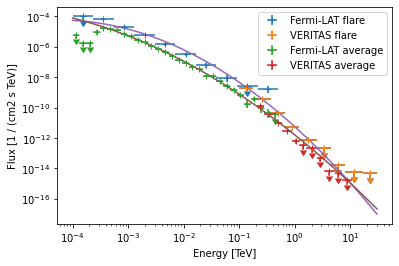

In [9]:
ax = flux_points_joint.plot(energy_power=0, label="Fermi-LAT flare")
flux_points_veritas.plot(energy_power=0, ax=ax, label="VERITAS flare")
flux_points_fermi_all.plot(energy_power=0, ax=ax, label="Fermi-LAT average")
flux_points_veritas_all.plot(energy_power=0, ax=ax, label="VERITAS average")

energy_range = [0.0001, 30] * u.TeV
model_lp_flare.plot(energy_range, ax=ax, energy_power=0)
model_lp_fermi_all.plot(energy_range, ax=ax, energy_power=0)
plt.legend()

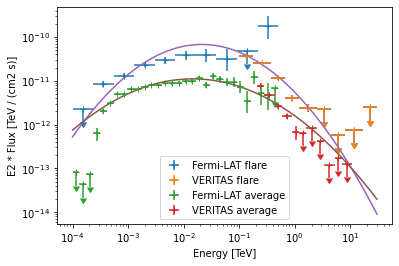

In [10]:
ax = flux_points_joint.plot(energy_power=2, label="Fermi-LAT flare")
flux_points_veritas.plot(energy_power=2, ax=ax, label="VERITAS flare")
flux_points_fermi_all.plot(energy_power=2, ax=ax, label="Fermi-LAT average")
flux_points_veritas_all.plot(energy_power=2, ax=ax, label="VERITAS average")

energy_range = [0.0001, 30] * u.TeV
model_lp_flare.plot(energy_range, ax=ax, energy_power=2)
model_lp_fermi_all.plot(energy_range, ax=ax, energy_power=2)
plt.legend()


plt.savefig("1ES1011_flare_vs_all_joint.pdf")

In [62]:
np.array(flux_points_joint.table['e_ref'])*1e-3, np.array(flux_points_joint.table['dnde']), np.array(flux_points_joint.table['dnde_err'])

(array([1.53090591e-04, 3.58794272e-04, 8.40896415e-04, 1.97078615e-03,
        4.61887811e-03, 1.08251395e-02, 2.53705863e-02, 5.94603558e-02,
        1.39355625e-01, 3.26604004e-01, 1.33977497e-01, 2.58734024e-01,
        4.99660739e-01, 8.96889509e-01, 1.73205081e+00, 3.34489362e+00,
        6.00407390e+00, 1.15949188e+01, 2.23918201e+01]),
 array([4.73462166e-11, 6.60444229e-05, 1.83477938e-05, 6.00354089e-06,
        1.38118975e-06, 3.27200162e-07, 6.08226269e-08, 8.73521849e-09,
        9.20551355e-20, 1.62422560e-09, 2.00619034e-09, 3.81624977e-10,
        4.54012681e-11, 4.97335959e-12, 7.93155957e-13, 6.34294568e-14,
        2.48782843e-23, 3.42249110e-21, 4.23874656e-22]),
 array([1.01448860e-07, 1.07989852e-05, 2.51962744e-06, 7.69101300e-07,
        2.36887625e-07, 7.32189759e-08, 2.07432453e-08, 5.04001969e-09,
        1.52295745e-14, 9.35699610e-10, 1.69908834e-10, 1.47767891e-11,
        3.11114696e-12, 7.42018926e-13, 1.60275167e-13, 5.78501582e-14,
        6.40077382e-

In [63]:
flux_points_joint.table[flux_points_joint.table['is_ul'] == False]

e_ref,e_min,e_max,dnde,dnde_ul,dnde_err,dnde_errn,dnde_errp,is_ul
GeV,GeV,GeV,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),
float64,float64,float64,float64,float64,float64,float64,float64,bool
0.3587942716300281,0.23436729115920993,0.5492802716530588,6.604442293713797e-05,8.898619682109288e-05,1.0798985161517492e-05,1.046405331860122e-05,1.1134024683293448e-05,False
0.8408964152537143,0.5492802716530588,1.2873332935452233,1.8347793822299123e-05,2.378506831418944e-05,2.519627436379813e-06,2.411815832924306e-06,2.630704697654683e-06,False
1.9707861498850316,1.2873332935452233,3.017088168272581,6.0035408943571e-06,7.666961751633752e-06,7.69101299671086e-07,7.387585448525034e-07,7.999408849967078e-07,False
4.618878114026437,3.017088168272581,7.071067811865475,1.381189749414793e-06,1.908848600701467e-06,2.368876254760287e-07,2.2392997529355098e-07,2.502541630809028e-07,False
10.82513951778936,7.071067811865475,16.572270086699916,3.272001617685285e-07,4.963457815161055e-07,7.321897590455542e-08,6.79073103226911e-08,7.884311874299489e-08,False
25.37058625204807,16.572270086699916,38.839980485786654,6.08226268632573e-08,1.1205113856963487e-07,2.074324534939515e-08,1.8507459669116025e-08,2.3130061251606805e-08,False
59.46035575013601,38.839980485786654,91.02821015130395,8.735218485400777e-09,2.3030012118944273e-08,5.040019690400962e-09,4.124085861777567e-09,6.059433929049596e-09,False
326.6040035902225,213.34035032232416,499.99999999999983,1.624225599563391e-09,4.281797214232312e-09,9.356996096877568e-10,7.666623426647807e-10,1.1265444695441366e-09,False


In [64]:
flux_points_joint_all.table[flux_points_joint_all.table['is_ul'] == False]

e_ref,e_min,e_max,dnde,dnde_ul,dnde_err,dnde_errn,dnde_errp,is_ul
GeV,GeV,GeV,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),
float64,float64,float64,float64,float64,float64,float64,float64,bool
0.2701136307211298,0.23436729115920993,0.3113120996555228,8.692399751238771e-06,1.4340327046181525e-05,2.7805505479525093e-06,2.7732232550923932e-06,2.7895680028540245e-06,False
0.3587942716300281,0.3113120996555228,0.41351855420001377,1.570695274961546e-05,1.87955097783108e-05,1.5128247296417454e-06,1.4968301092088483e-06,1.5286553651612658e-06,False
0.47658953385965547,0.41351855420001377,0.5492802716530588,1.3702670887708758e-05,1.5503278328188327e-05,8.791529180237882e-07,8.661588627900866e-07,8.922768432416453e-07,False
0.6330579993729034,0.5492802716530588,0.7296137350135089,1.2271752064127845e-05,1.3442851574510548e-05,5.712066947994395e-07,5.612382068716907e-07,5.814232903434441e-07,False
0.8408964152537146,0.7296137350135089,0.9691522339193016,7.0323092934037045e-06,7.720679997284505e-06,3.3611598207285416e-07,3.3220098095386353e-07,3.400663896942071e-07,False
1.1169699804551803,0.9691522339193016,1.287333293545224,5.15360794457744e-06,5.613346535503077e-06,2.243393500085571e-07,2.2144506363418008e-07,2.2724610378067308e-07,False
1.4836808845969625,1.287333293545224,1.7099759466766973,2.8845724130442715e-06,3.166414200334449e-06,1.3711980992293832e-07,1.3522268802331643e-07,1.3903097783376682e-07,False
1.9707861498850325,1.7099759466766973,2.2713758378456372,1.880487456903912e-06,2.07005059943352e-06,9.19728346974536e-08,9.046407800133052e-08,9.349907537560555e-08,False


In [11]:
e_tev_joint_all = np.array(flux_points_joint_all.table[flux_points_joint_all.table['is_ul'] == False]['e_ref'])[3:]*1e-3
e_tev_joint_all

array([6.33057999e-04, 8.40896415e-04, 1.11696998e-03, 1.48368088e-03,
       1.97078615e-03, 2.61781229e-03, 3.47726270e-03, 4.61887811e-03,
       6.13529574e-03, 8.14956639e-03, 1.08251395e-02, 1.43791264e-02,
       1.90999180e-02, 2.53705863e-02, 3.36999691e-02, 4.47639604e-02,
       5.94603558e-02, 7.89817048e-02, 1.04912081e-01, 1.39355625e-01,
       1.85107282e-01, 2.45879603e-01, 3.26604004e-01, 2.40489200e-01,
       3.46645368e-01, 4.99660739e-01, 7.20219788e-01, 1.03813749e+00])

best-fit param 0 = 5.392e-08 +/- 5.28e-08
best-fit param 1 = 1.304 +/- 0.1537
best-fit param 2 = 97.56 +/- 131.5
best-fit param 3 = 0.41 +/- 0.07832
fit Chisq is 15.997, dof is 9, reduced Chisq is 1.78
Log likelihood lnL=-7.998589812572128
best-fit param 0 = 2.363e-09 +/- 3.765e-10
best-fit param 1 = 1.701 +/- 0.03219
best-fit param 2 = 8.025 +/- 2.199
best-fit param 3 = 0.679 +/- 0.07894
fit Chisq is 39.153, dof is 24, reduced Chisq is 1.63
Log likelihood lnL=-19.57668506115592


/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in power
  import sys


(1e-15, 1e-10)

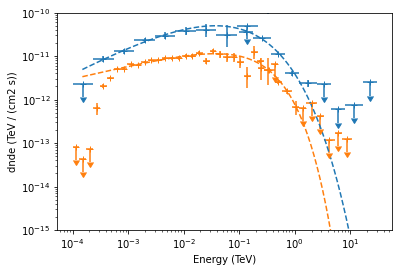

In [12]:
# plec model 

def plec2(E, N0, gamma, E0, Ec_inv, alpha):
    return N0*(E/E0)**(-gamma)*np.exp( -(Ec_inv*np.array(E))**alpha )

def plec2_0p1TeV(E, N0, gamma, Ec_inv, alpha):
    return N0*(E/0.1)**(-gamma)*np.exp( -(Ec_inv*np.array(E))**alpha )

e_tev_joint = np.array(flux_points_joint.table[flux_points_joint.table['is_ul'] == False]['e_ref'])*1e-3
slice_joint = flux_points_joint.table[flux_points_joint.table['is_ul'] == False]
de_tev_joint = [np.array(slice_joint['e_ref']-slice_joint['e_min'])*1e-3, 
                np.array(slice_joint['e_max']-slice_joint['e_ref'])*1e-3]
f_tev_joint = np.array(flux_points_joint.table[flux_points_joint.table['is_ul'] == False]['dnde'])
df_tev_joint = np.array(flux_points_joint.table[flux_points_joint.table['is_ul'] == False]['dnde_err'])


slice_joint_UL = flux_points_joint.table[flux_points_joint.table['is_ul'] == True]
e_tev_joint_UL = np.array(slice_joint_UL['e_ref'])*1e-3
de_tev_joint_UL = [np.array(slice_joint_UL['e_ref']-slice_joint_UL['e_min'])*1e-3, 
                np.array(slice_joint_UL['e_max']-slice_joint_UL['e_ref'])*1e-3]
f_tev_joint_UL = np.array(slice_joint_UL['dnde'])
df_tev_joint_UL = np.array(slice_joint_UL['dnde_err'])
ul_tev_joint = np.array(slice_joint_UL['dnde_ul'])


#ps_plec, dps_plec, chi2_plec, dof_plec, redchi2_plec = fit_factory_boundMC(plec2_0p1TeV, 
ps_plec, dps_plec, chi2_plec, dof_plec, redchi2_plec = fit_factory(plec2_0p1TeV, 
                                                       e_tev_joint, f_tev_joint,
                                                         dy=df_tev_joint, 
                                                         p0=[1e-10, 1.8, 10.,0.9])

model_plec = plec2_0p1TeV(plotEs, *ps_plec) 

"""e_tev_joint_all = np.array(flux_points_joint_all.table[flux_points_joint_all.table['is_ul'] == False]['e_ref'])[3:]*1e-3
slice_joint_all = flux_points_joint_all.table[flux_points_joint_all.table['is_ul'] == False][3:]
de_tev_joint_all = [np.array(slice_joint_all['e_ref']-slice_joint_all['e_min'])*1e-3, 
                np.array(slice_joint_all['e_max']-slice_joint_all['e_ref'])*1e-3]

f_tev_joint_all = np.array(flux_points_joint_all.table[flux_points_joint_all.table['is_ul'] == False]['dnde'])[3:]
df_tev_joint_all = np.array(flux_points_joint_all.table[flux_points_joint_all.table['is_ul'] == False]['dnde_err'])[3:]
"""

e_tev_joint_all = np.array(flux_points_joint_all.table[flux_points_joint_all.table['is_ul'] == False]['e_ref'])*1e-3
slice_joint_all = flux_points_joint_all.table[flux_points_joint_all.table['is_ul'] == False]
de_tev_joint_all = [np.array(slice_joint_all['e_ref']-slice_joint_all['e_min'])*1e-3, 
                np.array(slice_joint_all['e_max']-slice_joint_all['e_ref'])*1e-3]

f_tev_joint_all = np.array(flux_points_joint_all.table[flux_points_joint_all.table['is_ul'] == False]['dnde'])
df_tev_joint_all = np.array(flux_points_joint_all.table[flux_points_joint_all.table['is_ul'] == False]['dnde_err'])

slice_joint_all_UL = flux_points_joint_all.table[flux_points_joint_all.table['is_ul'] == True]
e_tev_joint_all_UL = np.array(slice_joint_all_UL['e_ref'])*1e-3
de_tev_joint_all_UL = [np.array(slice_joint_all_UL['e_ref']-slice_joint_all_UL['e_min'])*1e-3, 
                np.array(slice_joint_all_UL['e_max']-slice_joint_all_UL['e_ref'])*1e-3]
f_tev_joint_all_UL = np.array(slice_joint_all_UL['dnde'])
df_tev_joint_all_UL = np.array(slice_joint_all_UL['dnde_err'])
ul_tev_joint_all = np.array(slice_joint_all_UL['dnde_ul'])


#ps_plec, dps_plec, chi2_plec, dof_plec, redchi2_plec = fit_factory_boundMC(plec2_0p1TeV, 
p0_all=[6e-9, 1.6, 70.,0.4]

try:
    ps_pleca, dps_pleca, chi2_pleca, dof_pleca, redchi2_pleca = fit_factory(plec2_0p1TeV, 
                                                           e_tev_joint_all[3:], f_tev_joint_all[3:],
                                                             dy=df_tev_joint_all[3:], 
                                                             p0=p0_all)

    model_plec_all = plec2_0p1TeV(plotEs, *ps_pleca) 
except:
    print("*** fit for all data failed ***")
    model_plec_all = plec2_0p1TeV(plotEs, *p0_all) 


#ax = flux_points_joint.plot(energy_power=0)
#ax.plot(plotEs, model_plec)

cs = plt.rcParams['axes.prop_cycle'].by_key()['color']

ax = flux_points_joint.plot(energy_power=2)
ax.plot(plotEs, model_plec*plotEs*plotEs, color=cs[0], ls="--")

ax = flux_points_joint_all.plot(energy_power=2)
ax.plot(plotEs, model_plec_all*plotEs*plotEs, color=cs[1], ls="--")

ax.set_ylim(1e-15, 1e-10)

best-fit param 0 = 2.162e-10 +/- 6.784e-12
best-fit param 1 = 2.874 +/- 0.03805
best-fit param 2 = 0.1655 +/- 0.00803
fit Chisq is 55.633, dof is 10, reduced Chisq is 5.56
Log likelihood lnL=-27.816590517380785
best-fit param 0 = 4.544e-11 +/- 1.796e-12
best-fit param 1 = 2.657 +/- 0.02164
best-fit param 2 = 0.1086 +/- 0.003224
fit Chisq is 181.450, dof is 28, reduced Chisq is 6.48
Log likelihood lnL=-90.72506420777836


(1e-15, 1e-10)

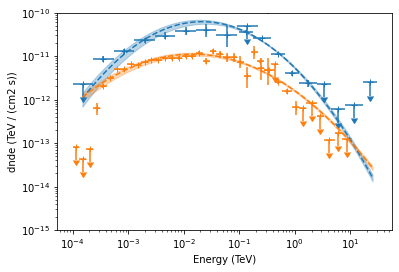

In [67]:
# log-para

ps_lpf, dps_lpf, chi2_lpf, dof_lpf, redchi2_lpf = fit_factory(log_para300GeV_natural, 
                                                   e_tev_joint, f_tev_joint,
                                                    dy=df_tev_joint, 
                                                   p0=[3.2e-11, 2.6, 0.2])

#plotEs = np.logspace(np.log10(0.15),np.log10(25000),100)
plotEs = np.logspace(np.log10(0.15e-3),np.log10(25),100)

model_lpf = log_para300GeV_natural(plotEs, *ps_lpf) 
model_errlpf = ferrLP(plotEs, model_lpf, ps_lpf[0],dps_lpf[0], 
                         ps_lpf[1],dps_lpf[1], ps_lpf[2],dps_lpf[2], 0.3)

ps_lpa, dps_lpa, chi2_lpa, dof_lpa, redchi2_lpa = fit_factory(log_para300GeV_natural, 
                                                              e_tev_joint_all, f_tev_joint_all,
                                                    dy=df_tev_joint_all, 
                                                   p0=[3.2e-11, 2.6, 0.2])


model_lpa = log_para300GeV_natural(plotEs, *ps_lpa) 
model_errlpa = ferrLP(plotEs, model_lpa, ps_lpa[0],dps_lpa[0], 
                         ps_lpa[1],dps_lpa[1], ps_lpa[2],dps_lpa[2], 0.3)


"""fig = plt.figure()

fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)

ax = fig.add_subplot(111)

plt.errorbar(flux_points_joint_all.table[flux_points_joint_all.table['is_ul']==0]['e_ref']/1e3, 
                flux_points_joint_all.table[flux_points_joint_all.table['is_ul']==0]['dnde'], 
                flux_points_joint_all.table[flux_points_joint_all.table['is_ul']==0]['dnde_err'], 
            )
plt.plot(plotEs, model_lp, color='r', ls='--')
plt.fill_between(plotEs,(model_lp-model_errlp),
                    (model_lp+model_errlp),alpha=0.3,color='r')
ax.set_xscale('log')
ax.set_yscale('log')
"""
cs = plt.rcParams['axes.prop_cycle'].by_key()['color']

ax = flux_points_joint.plot(energy_power=2)
#ax.plot(plotEs, model_plec*plotEs*plotEs, color=cs[0], ls="--")
plt.plot(plotEs, model_lpf*plotEs*plotEs, color=cs[0], ls='--')
plt.fill_between(plotEs,(model_lpf-model_errlpf)*plotEs*plotEs,
                    (model_lpf+model_errlpf)*plotEs*plotEs,alpha=0.3,color=cs[0])

ax = flux_points_joint_all.plot(energy_power=2)
plt.plot(plotEs, model_lpa*plotEs*plotEs, color=cs[1], ls='--')
plt.fill_between(plotEs,(model_lpa-model_errlpa)*plotEs*plotEs,
                    (model_lpa+model_errlpa)*plotEs*plotEs,alpha=0.3,color=cs[1])

ax.set_ylim(1e-15, 1e-10)

all data fit Chisq is 60.193, dof is 10, reduced Chisq is 6.02
all data fit Chisq is 181.453, dof is 28, reduced Chisq is 6.48


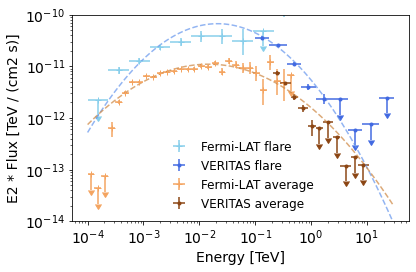

In [68]:
#plt.rcParams
plt.rcParams.update({'font.size': 14})

#ax = flux_points_joint.plot(energy_power=2, label="Fermi-LAT flare")

clist = [ 'skyblue', 'royalblue', 'sandybrown', 'saddlebrown', 'cornflowerblue', 'peru']

ax = flux_points_fermi.plot(energy_power=2, color=clist[0], label="Fermi-LAT flare")
flux_points_veritas.plot(energy_power=2, ax=ax, color=clist[1], label="VERITAS flare", marker='.', )
flux_points_fermi_all.plot(energy_power=2, ax=ax, color=clist[2], label="Fermi-LAT average")
flux_points_veritas_all.plot(energy_power=2, ax=ax, color=clist[3], label="VERITAS average", marker='.', )

energy_range = [0.0001, 30] * u.TeV
alpha=0.7
model_lp_flare.plot(energy_range, ax=ax, energy_power=2, color=clist[4], ls="--", alpha=alpha)
model_lp_fermi_all.plot(energy_range, ax=ax, energy_power=2, color=clist[5], ls="--", alpha=alpha)



#ax = flux_points_joint.plot(energy_power=2)
ax.plot(plotEs, model_plec*plotEs*plotEs, color=clist[4], ls="-", alpha=alpha)

#ax = flux_points_joint_all.plot(energy_power=2)
ax.plot(plotEs, model_plec_all*plotEs*plotEs, color=clist[5], ls="-", alpha=alpha)

#m_, dm_ = model_lp_flare.evaluate_error(plotEs*u.TeV)
m_, dm_ = model_lp_flare.evaluate_error(e_tev_joint*u.TeV)
chi2_, dof_, redchi2_ = chisq(np.array(m_), f_tev_joint, df_tev_joint, num_params=3)
print("all data fit Chisq is %.3f, dof is %d, reduced Chisq is %.2f" % (chi2_, dof_, redchi2_))
#print("Log likelihood lnL={0}".format(lnL_LC))

m_, dm_ = model_lp_fermi_all.evaluate_error(e_tev_joint_all*u.TeV)
chi2_, dof_, redchi2_ = chisq(np.array(m_), f_tev_joint_all, df_tev_joint_all, num_params=3)
print("all data fit Chisq is %.3f, dof is %d, reduced Chisq is %.2f" % (chi2_, dof_, redchi2_))


#plt.plot(plotEs, model_lp*plotEs*plotEs, color='r', ls='--')
#plt.fill_between(plotEs,(model_lp-model_errlp)*plotEs*plotEs,
#                    (model_lp+model_errlp)*plotEs*plotEs,alpha=0.3,color='r')


#ax.plot(plotEs, m_*plotEs*plotEs, color='r', ls="-", alpha=alpha)

#ax.plot(plotEs, model_plec*plotEs*plotEs)
ax.set_ylim(1e-14, 1e-10)

plt.legend(fontsize=12, frameon=False)

plt.tight_layout()

plt.savefig("1ES1011_flare_vs_all_joint_lp_vs_plec_v2.pdf")

No handles with labels found to put in legend.


all data fit Chisq is 60.193, dof is 10, reduced Chisq is 6.02
all data fit Chisq is 181.453, dof is 28, reduced Chisq is 6.48


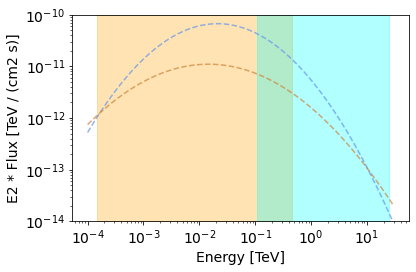

In [69]:
#plt.rcParams
plt.rcParams.update({'font.size': 14})

#ax = flux_points_joint.plot(energy_power=2, label="Fermi-LAT flare")

clist = [ 'skyblue', 'royalblue', 'sandybrown', 'saddlebrown', 'cornflowerblue', 'peru']

#ax = flux_points_fermi.plot(energy_power=2, color=clist[0], label="Fermi-LAT flare")
#flux_points_veritas.plot(energy_power=2, ax=ax, color=clist[1], label="VERITAS flare", marker='.', )
#flux_points_fermi_all.plot(energy_power=2, ax=ax, color=clist[2], label="Fermi-LAT average")
#flux_points_veritas_all.plot(energy_power=2, ax=ax, color=clist[3], label="VERITAS average", marker='.', )

energy_range = [0.0001, 30] * u.TeV
alpha=0.7
#model_lp_flare.plot(energy_range, ax=ax, energy_power=2, color=clist[4], ls="--", alpha=alpha)
ax = model_lp_flare.plot(energy_range, energy_power=2, color=clist[4], ls="--", alpha=alpha)
model_lp_fermi_all.plot(energy_range, ax=ax, energy_power=2, color=clist[5], ls="--", alpha=alpha)



#ax = flux_points_joint.plot(energy_power=2)
ax.plot(plotEs, model_plec*plotEs*plotEs, color=clist[4], ls="-", alpha=alpha)

#ax = flux_points_joint_all.plot(energy_power=2)
ax.plot(plotEs, model_plec_all*plotEs*plotEs, color=clist[5], ls="-", alpha=alpha)

#m_, dm_ = model_lp_flare.evaluate_error(plotEs*u.TeV)
m_, dm_ = model_lp_flare.evaluate_error(e_tev_joint*u.TeV)
chi2_, dof_, redchi2_ = chisq(np.array(m_), f_tev_joint, df_tev_joint, num_params=3)
print("all data fit Chisq is %.3f, dof is %d, reduced Chisq is %.2f" % (chi2_, dof_, redchi2_))
#print("Log likelihood lnL={0}".format(lnL_LC))

m_, dm_ = model_lp_fermi_all.evaluate_error(e_tev_joint_all*u.TeV)
chi2_, dof_, redchi2_ = chisq(np.array(m_), f_tev_joint_all, df_tev_joint_all, num_params=3)
print("all data fit Chisq is %.3f, dof is %d, reduced Chisq is %.2f" % (chi2_, dof_, redchi2_))


#plt.plot(plotEs, model_lp*plotEs*plotEs, color='r', ls='--')
#plt.fill_between(plotEs,(model_lp-model_errlp)*plotEs*plotEs,
#                    (model_lp+model_errlp)*plotEs*plotEs,alpha=0.3,color='r')


#ax.plot(plotEs, m_*plotEs*plotEs, color='r', ls="-", alpha=alpha)

#ax.plot(plotEs, model_plec*plotEs*plotEs)
ax.set_ylim(1e-14, 1e-10)

ax.fill_between(plotEs, 0, 1, where=(plotEs < 0.5),
                color='orange', alpha=0.3, transform=ax.get_xaxis_transform())
ax.fill_between(plotEs, 0, 1, where=(plotEs > 0.1),
                color='cyan', alpha=0.3, transform=ax.get_xaxis_transform())

plt.legend(fontsize=12, frameon=False)

plt.tight_layout()

plt.savefig("1ES1011_flare_vs_all_joint_lp_vs_plec_modelonly.pdf")

In [4]:
# EBL deabsorption

from gammapy.modeling.models import (
    EBLAbsorptionNormSpectralModel, 
    #AbsorbedSpectralModel,
    #Absorption,
    Models,
    PowerLawSpectralModel,
    SkyModel,
)


z=0.212
#z=0.108
cs = plt.rcParams['axes.prop_cycle'].by_key()['color']


redshift = 0.212

"""absorption = EBLAbsorptionNormSpectralModel.read_builtin("dominguez")
smodel = EBLAbsorptionNormSpectralModel(
                    spectral_model=model.spectral_model, absorption=absorption, parameter=z, 
    alpha_norm=-1
                    )"""

dominguez = EBLAbsorptionNormSpectralModel.read_builtin("dominguez", redshift=redshift)
franceschini = EBLAbsorptionNormSpectralModel.read_builtin(
    "franceschini", redshift=redshift
)
finke = EBLAbsorptionNormSpectralModel.read_builtin("finke", redshift=redshift)

plt.figure()
energy_range = [0.08, 3] * u.TeV
opts = dict(energy_range=energy_range, energy_unit="TeV", flux_unit="")
franceschini.plot(label="Franceschini 2008", **opts)
finke.plot(label="Finke 2010", **opts)
dominguez.plot(label="Dominguez 2011", **opts)

#plt.plot(1, dominguez.evaluate(1*u.TeV, 1, 0,1*u.TeV), 'gX')
#plt.plot(0.5, dominguez.evaluate(0.5*u.TeV, 1, 0,1*u.TeV), 'gX')

plt.plot(1, dominguez.evaluate_error(1*u.TeV)[0], 'gX')
plt.plot(0.5, dominguez.evaluate_error(0.5*u.TeV)[0], 'gX')

plt.ylabel(r"Absorption coefficient [$\exp{(-\tau(E))}$]")
plt.xlim(energy_range.value)
#plt.ylim(1e-4, 2)
plt.title(f"EBL models (z={redshift})")
plt.grid(which="both")
plt.legend(loc="best")


# Spectral model corresponding to PKS 2155-304 (quiescent state)
index = 3.53
amplitude = 1.81 * 1e-12 * u.Unit("cm-2 s-1 TeV-1")
reference = 1 * u.TeV
pwl = PowerLawSpectralModel(index=index, amplitude=amplitude, reference=reference)

# The power-law model is multiplied by the EBL norm spectral model
absorption = EBLAbsorptionNormSpectralModel.read_builtin("dominguez", redshift=redshift)

model = pwl * absorption

energy_range = [0.1, 100] * u.TeV
plt.figure()
model.plot(energy_range)
plt.grid(which="both")
plt.ylim(1e-24, 1e-8)

        




TypeError: SpectralModel.plot() missing 1 required positional argument: 'energy_bounds'

<Figure size 432x288 with 0 Axes>

/Users/qifeng/.pyenv/versions/3.10.2/lib/python3.10/site-packages/astropy/units/quantity.py:504: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  value = np.array(value, dtype=dtype, copy=copy, order=order,


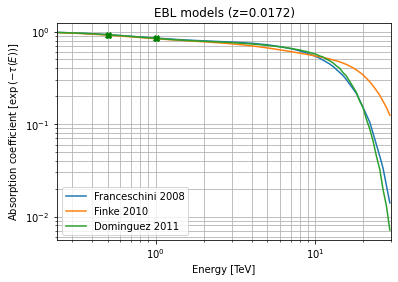

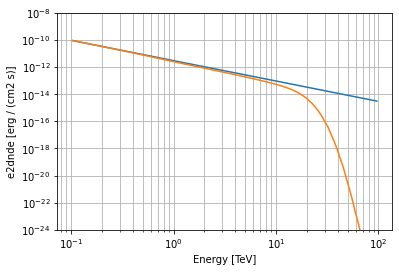

In [5]:

# for Colin

import sys,os,os.path
os.environ['GAMMAPY_DATA']=os.path.expanduser('/Users/qifeng/SynologyDrive/blazars/gammapy/gammapy-datasets')

from gammapy.modeling.models import (
    EBLAbsorptionNormSpectralModel, 
    #AbsorbedSpectralModel,
    #Absorption,
    Models,
    PowerLawSpectralModel,
    SkyModel,
)


z=0.0172
#z=0.108
cs = plt.rcParams['axes.prop_cycle'].by_key()['color']


redshift = z

"""absorption = EBLAbsorptionNormSpectralModel.read_builtin("dominguez")
smodel = EBLAbsorptionNormSpectralModel(
                    spectral_model=model.spectral_model, absorption=absorption, parameter=z, 
    alpha_norm=-1
                    )"""

dominguez = EBLAbsorptionNormSpectralModel.read_builtin("dominguez", redshift=redshift)
franceschini = EBLAbsorptionNormSpectralModel.read_builtin(
    "franceschini", redshift=redshift
)
finke = EBLAbsorptionNormSpectralModel.read_builtin("finke", redshift=redshift)

plt.figure()
#energy_range = [0.24, 30] * u.TeV
energy_range = (0.24, 30) * u.TeV
#opts = dict(energy_range=energy_range, energy_unit="TeV", flux_unit="")
opts = dict(energy_bounds=energy_range)#, sed_type='e2dnde', energy_power=0, n_points=100)
franceschini.plot(label="Franceschini 2008", **opts)
finke.plot(label="Finke 2010", **opts)
dominguez.plot(label="Dominguez 2011", **opts)

#plt.plot(1, dominguez.evaluate(1*u.TeV, 1, 0,1*u.TeV), 'gX')
#plt.plot(0.5, dominguez.evaluate(0.5*u.TeV, 1, 0,1*u.TeV), 'gX')

plt.plot(1, dominguez.evaluate_error(1*u.TeV)[0], 'gX')
plt.plot(0.5, dominguez.evaluate_error(0.5*u.TeV)[0], 'gX')

plt.ylabel(r"Absorption coefficient [$\exp{(-\tau(E))}$]")
plt.xlim(energy_range.value)
#plt.ylim(1e-4, 2)
plt.title(f"EBL models (z={redshift})")
plt.grid(which="both")
plt.legend(loc="best")


# Spectral model corresponding to LIGO subthresh
index = 3.5
amplitude = 1.81 * 1e-12 * u.Unit("cm-2 s-1 TeV-1")
reference = 1 * u.TeV
pwl = PowerLawSpectralModel(index=index, amplitude=amplitude, reference=reference)

# The power-law model is multiplied by the EBL norm spectral model
absorption = EBLAbsorptionNormSpectralModel.read_builtin("dominguez", redshift=redshift)

model = pwl * absorption

energy_range = [0.1, 100] * u.TeV
plt.figure()
pwl.plot(energy_range, sed_type='e2dnde',)
model.plot(energy_range,sed_type='e2dnde', )
plt.grid(which="both")
plt.ylim(1e-24, 1e-8)

plt.savefig("EBL_colin.pdf")




In [72]:
#energy_range = [0.24, 30] * u.TeV
emax =  10 * u.TeV
model.integral(0.24 * u.TeV, emax)/pwl.integral(0.24 * u.TeV, emax)

<Quantity 0.95083592>

In [73]:
model.integral(0.24 * u.TeV, emax), pwl.integral(0.24 * u.TeV, emax)

(<Quantity 2.4393678e-11 1 / (cm2 s)>, <Quantity 2.56549815e-11 1 / (cm2 s)>)

In [7]:
# EBL deabsorption

from gammapy.modeling.models import (
    EBLAbsorptionNormSpectralModel, 
    #AbsorbedSpectralModel,
    #Absorption,
    Models,
    PowerLawSpectralModel,
    SkyModel,
)


z=0.6
#z=0.108
cs = plt.rcParams['axes.prop_cycle'].by_key()['color']


redshift = z

"""absorption = EBLAbsorptionNormSpectralModel.read_builtin("dominguez")
smodel = EBLAbsorptionNormSpectralModel(
                    spectral_model=model.spectral_model, absorption=absorption, parameter=z, 
    alpha_norm=-1
                    )"""

dominguez = EBLAbsorptionNormSpectralModel.read_builtin("dominguez", redshift=redshift)
franceschini = EBLAbsorptionNormSpectralModel.read_builtin(
    "franceschini", redshift=redshift
)
finke = EBLAbsorptionNormSpectralModel.read_builtin("finke", redshift=redshift)

plt.figure()
energy_range = [0.08, 3] * u.TeV
opts = dict(energy_range=energy_range, energy_unit="TeV", flux_unit="")
franceschini.plot(label="Franceschini 2008", **opts)
finke.plot(label="Finke 2010", **opts)
dominguez.plot(label="Dominguez 2011", **opts)

#plt.plot(1, dominguez.evaluate(1*u.TeV, 1, 0,1*u.TeV), 'gX')
#plt.plot(0.5, dominguez.evaluate(0.5*u.TeV, 1, 0,1*u.TeV), 'gX')

plt.plot(1, dominguez.evaluate_error(1*u.TeV)[0], 'gX')
plt.plot(0.5, dominguez.evaluate_error(0.5*u.TeV)[0], 'gX')

plt.ylabel(r"Absorption coefficient [$\exp{(-\tau(E))}$]")
plt.xlim(energy_range.value)
#plt.ylim(1e-4, 2)
plt.title(f"EBL models (z={redshift})")
plt.grid(which="both")
plt.legend(loc="best")


# Spectral model corresponding to PKS 2155-304 (quiescent state)
index = 3.53
amplitude = 1.81 * 1e-12 * u.Unit("cm-2 s-1 TeV-1")
reference = 1 * u.TeV
pwl = PowerLawSpectralModel(index=index, amplitude=amplitude, reference=reference)

# The power-law model is multiplied by the EBL norm spectral model
absorption = EBLAbsorptionNormSpectralModel.read_builtin("dominguez", redshift=redshift)

model = pwl * absorption

energy_range = [0.1, 100] * u.TeV
plt.figure()
model.plot(energy_range)
plt.grid(which="both")
plt.ylim(1e-24, 1e-8)

        




TypeError: SpectralModel.plot() missing 1 required positional argument: 'energy_bounds'

<Figure size 432x288 with 0 Axes>

In [75]:
-2/(np.log10(0.8)-np.log10(0.3))

-4.695180299575582

In [6]:
# de-absorption
def deabs(e_tev_joint, f_tev_joint, df_tev_joint, model=dominguez):
    f_deabs = np.zeros_like(f_tev_joint)
    df_deabs = np.zeros_like(df_tev_joint)
    for i, e_ in enumerate(e_tev_joint):
        if e_ >= 1e-3:
            ebl_frac = model.evaluate_error(e_*u.TeV)[0]
        else:
            ebl_frac = 1.0
        #print(e_, f_tev_joint[i],ebl_frac)
        f_deabs[i] = f_tev_joint[i] / ebl_frac
        df_deabs[i] = df_tev_joint[i] / ebl_frac
    return f_deabs, df_deabs



redshift = 0.212

"""absorption = EBLAbsorptionNormSpectralModel.read_builtin("dominguez")
smodel = EBLAbsorptionNormSpectralModel(
                    spectral_model=model.spectral_model, absorption=absorption, parameter=z, 
    alpha_norm=-1
                    )"""

dominguez = EBLAbsorptionNormSpectralModel.read_builtin("dominguez", redshift=redshift)
franceschini = EBLAbsorptionNormSpectralModel.read_builtin(
    "franceschini", redshift=redshift
)
finke = EBLAbsorptionNormSpectralModel.read_builtin("finke", redshift=redshift)

plt.figure()
energy_range = [0.08, 3] * u.TeV
opts = dict(energy_range=energy_range, energy_unit="TeV", flux_unit="")
franceschini.plot(label="Franceschini 2008", **opts)
finke.plot(label="Finke 2010", **opts)
dominguez.plot(label="Dominguez 2011", **opts)


f_deabs, df_deabs = deabs(e_tev_joint, f_tev_joint, df_tev_joint, model=dominguez)
f_deabs_all, df_deabs_all = deabs(e_tev_joint_all, f_tev_joint_all, df_tev_joint_all, model=dominguez)

ul_deabs, _ = deabs(e_tev_joint_UL, ul_tev_joint, df_tev_joint, model=dominguez)
ul_deabs_all, _ = deabs(e_tev_joint_all_UL, ul_tev_joint_all, df_tev_joint_all, model=dominguez)


TypeError: SpectralModel.plot() missing 1 required positional argument: 'energy_bounds'

<Figure size 432x288 with 0 Axes>

In [77]:
f_deabs, df_deabs

(array([6.60444229e-05, 1.83477938e-05, 6.00354089e-06, 1.38118975e-06,
        3.27200162e-07, 6.08290351e-08, 8.86353154e-09, 3.09560993e-09,
        2.22232775e-09, 5.80950089e-10, 1.56573656e-10, 4.81417196e-11,
        1.88268225e-11]),
 array([1.07989852e-05, 2.51962744e-06, 7.69101300e-07, 2.36887625e-07,
        7.32189759e-08, 2.07454309e-08, 5.11405337e-09, 1.78334894e-09,
        1.88214004e-10, 2.24947985e-11, 1.07292962e-11, 7.18268334e-12,
        3.80438689e-12]))

In [78]:
de_tev_joint_all[0].shape, e_tev_joint_all.shape, f_tev_joint_all.shape, df_tev_joint_all.shape

((31,), (31,), (31,), (31,))

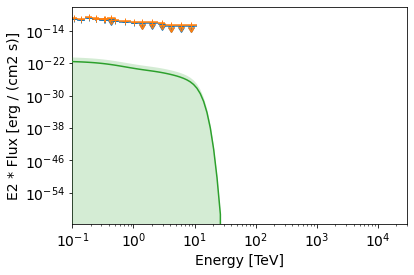

In [79]:
model_lp_flare = LogParabolaSpectralModel(alpha=4.085, beta=1.693e-01 , 
                                         amplitude="1.098e-15 cm-2 s-1 TeV-1", reference="10 TeV")
model_lp_fermi_all = LogParabolaSpectralModel(
    alpha=2.657, amplitude="4.544e-11 cm-2 s-1 TeV-1", reference="0.3 TeV", beta=0.1086
)

flux_points_joint_all_deabs = flux_points_joint_all.to_sed_type('dnde', model_lp_fermi_all*dominguez)
ax = flux_points_joint_all.plot(energy_power=2)

#model = SkyModel(spectral_model=model, name="absorbed-model")

model_deabs_all =SkyModel(spectral_model= model_lp_fermi_all*dominguez, name="absorbed-LP")
dataset_all = FluxPointsDataset(model_deabs_all, flux_points_joint_all)
fit = Fit([dataset_all])
result_all = fit.run()


ax = dataset_all.plot_spectrum()


*** fit for flare data failed ***
*** fit for all data failed ***


(1e-15, 1e-08)

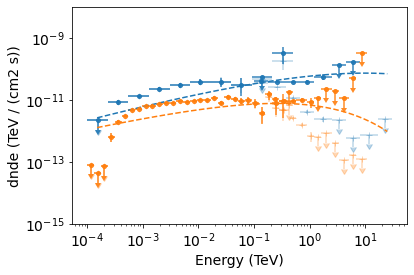

In [80]:
# plec deabs

# plec model 

def plec2(E, N0, gamma, E0, Ec_inv, alpha):
    return N0*(E/E0)**(-gamma)*np.exp( -(Ec_inv*np.array(E))**alpha )

def plec2_0p1TeV(E, N0, gamma, Ec_inv, alpha):
    return N0*(E/0.1)**(-gamma)*np.exp( -(Ec_inv*np.array(E))**alpha )


#ps_plec, dps_plec, chi2_plec, dof_plec, redchi2_plec = fit_factory_boundMC(plec2_0p1TeV, 
p0_f=[9e-9, 1.5, 10.,0.2]
p0_all=[2e-9, 1.6, 10.,0.3]

try:
    ps_plec, dps_plec, chi2_plec, dof_plec, redchi2_plec = fit_factory(plec2_0p1TeV, 
                                                       e_tev_joint, f_deabs,
                                                    dy=df_deabs, 
                                                         p0=p0_f)

    model_plec = plec2_0p1TeV(plotEs, *ps_plec) 
except:
    print("*** fit for flare data failed ***")
    model_plec = plec2_0p1TeV(plotEs, *p0_f) 


#ps_plec, dps_plec, chi2_plec, dof_plec, redchi2_plec = fit_factory_boundMC(plec2_0p1TeV, 

try:
    ps_pleca, dps_pleca, chi2_pleca, dof_pleca, redchi2_pleca = fit_factory(plec2_0p1TeV, 
                                                           e_tev_joint_all[3:], f_deabs_all[3:],
                                                             dy=df_deabs_all[3:], 
                                                             p0=p0_all)

    model_plec_all = plec2_0p1TeV(plotEs, *ps_pleca) 
except:
    print("*** fit for all data failed ***")
    model_plec_all = plec2_0p1TeV(plotEs, *p0_all) 


#ax = flux_points_joint.plot(energy_power=0)
#ax.plot(plotEs, model_plec)

cs = plt.rcParams['axes.prop_cycle'].by_key()['color']

ax = flux_points_joint.plot(energy_power=2, alpha=0.3)
lf = ax.errorbar(e_tev_joint, f_deabs*e_tev_joint*e_tev_joint,  
                    xerr=de_tev_joint, 
                    yerr=df_deabs*e_tev_joint*e_tev_joint, color=cs[0], fmt='.', ms=8, mec=cs[0],
                    ecolor=cs[0], capthick=0,label="deabs flare", alpha=0.9)
ax.errorbar(e_tev_joint_UL, ul_deabs*e_tev_joint_UL*e_tev_joint_UL, 
                xerr=de_tev_joint_UL, 
                yerr=ul_deabs*e_tev_joint_UL*e_tev_joint_UL * 5.e-1, uplims=True, 
                color=cs[0], fmt='.', ms=8, mec=cs[0],
                    ecolor=cs[0], capthick=0, alpha=0.9)
ax.plot(plotEs, model_plec*plotEs*plotEs, color=cs[0], ls="--")

ax = flux_points_joint_all.plot(energy_power=2, alpha=0.3)
ll = ax.errorbar(e_tev_joint_all, f_deabs_all*e_tev_joint_all*e_tev_joint_all,  
                    xerr=de_tev_joint_all, 
                    yerr=df_deabs_all*e_tev_joint_all*e_tev_joint_all, color=cs[1], fmt='.', ms=8, mec=cs[1],
                    ecolor=cs[1], capthick=0,label="deabs all", alpha=0.9)
ax.errorbar(e_tev_joint_all_UL, ul_deabs_all*e_tev_joint_all_UL*e_tev_joint_all_UL, 
                xerr=de_tev_joint_all_UL, 
                yerr=ul_deabs_all*e_tev_joint_all_UL*e_tev_joint_all_UL * 5.e-1, uplims=True, 
                color=cs[1], fmt='.', ms=8, mec=cs[1],
                    ecolor=cs[1], capthick=0, alpha=0.9)
ax.plot(plotEs, model_plec_all*plotEs*plotEs, color=cs[1], ls="--")

ax.set_ylim(1e-15, 1e-8)



best-fit param 0 = 4.417e-10 +/- 1.333e-11
best-fit param 1 = 2.044 +/- 0.0503
best-fit param 2 = 0.03797 +/- 0.008624
fit Chisq is 12.412, dof is 10, reduced Chisq is 1.24
Log likelihood lnL=-6.206143780503195
best-fit param 0 = 1.039e-10 +/- 4.328e-12
best-fit param 1 = 2.279 +/- 0.02405
best-fit param 2 = 0.06858 +/- 0.00342
fit Chisq is 178.652, dof is 28, reduced Chisq is 6.38
Log likelihood lnL=-89.32580677485686


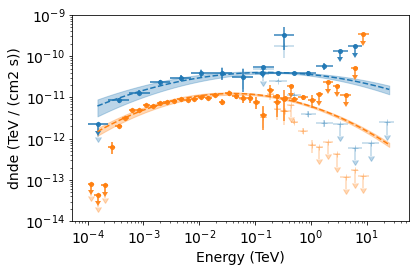

In [81]:
# log-para deabsorbed 

ps_lpf, dps_lpf, chi2_lpf, dof_lpf, redchi2_lpf = fit_factory(log_para300GeV_natural, 
                                                   e_tev_joint, f_deabs,
                                                    dy=df_deabs, 
                                                   p0=[3.2e-11, 2.6, 0.2])

#plotEs = np.logspace(np.log10(0.15),np.log10(25000),100)
plotEs = np.logspace(np.log10(0.15e-3),np.log10(25),100)

model_lpf = log_para300GeV_natural(plotEs, *ps_lpf) 
model_errlpf = ferrLP(plotEs, model_lpf, ps_lpf[0],dps_lpf[0], 
                         ps_lpf[1],dps_lpf[1], ps_lpf[2],dps_lpf[2], 0.3)

ps_lpa, dps_lpa, chi2_lpa, dof_lpa, redchi2_lpa = fit_factory(log_para300GeV_natural, 
                                                              e_tev_joint_all, f_deabs_all,
                                                    dy=df_deabs_all, 
                                                   p0=[3.2e-11, 2.6, 0.2])


model_lpa = log_para300GeV_natural(plotEs, *ps_lpa) 
model_errlpa = ferrLP(plotEs, model_lpa, ps_lpa[0],dps_lpa[0], 
                         ps_lpa[1],dps_lpa[1], ps_lpa[2],dps_lpa[2], 0.3)


"""fig = plt.figure()

fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)

ax = fig.add_subplot(111)

plt.errorbar(flux_points_joint_all.table[flux_points_joint_all.table['is_ul']==0]['e_ref']/1e3, 
                flux_points_joint_all.table[flux_points_joint_all.table['is_ul']==0]['dnde'], 
                flux_points_joint_all.table[flux_points_joint_all.table['is_ul']==0]['dnde_err'], 
            )
plt.plot(plotEs, model_lp, color='r', ls='--')
plt.fill_between(plotEs,(model_lp-model_errlp),
                    (model_lp+model_errlp),alpha=0.3,color='r')
ax.set_xscale('log')
ax.set_yscale('log')
"""
cs = plt.rcParams['axes.prop_cycle'].by_key()['color']

ax = flux_points_joint.plot(energy_power=2, alpha=0.3)
lf = ax.errorbar(e_tev_joint, f_deabs*e_tev_joint*e_tev_joint,  
                    xerr=de_tev_joint, 
                    yerr=df_deabs*e_tev_joint*e_tev_joint, color=cs[0], fmt='.', ms=8, mec=cs[0],
                    ecolor=cs[0], capthick=0,label="deabs flare", alpha=0.9)
ax.errorbar(e_tev_joint_UL, ul_deabs*e_tev_joint_UL*e_tev_joint_UL, 
                xerr=de_tev_joint_UL, 
                yerr=ul_deabs*e_tev_joint_UL*e_tev_joint_UL * 3.e-1, uplims=True, 
                color=cs[0], fmt='.', ms=8, mec=cs[0],
                    ecolor=cs[0], capthick=0, alpha=0.9)

#ax.plot(plotEs, model_plec*plotEs*plotEs, color=cs[0], ls="--")
plt.plot(plotEs, model_lpf*plotEs*plotEs, color=cs[0], ls='--')
plt.fill_between(plotEs,(model_lpf-model_errlpf)*plotEs*plotEs,
                    (model_lpf+model_errlpf)*plotEs*plotEs,alpha=0.3,color=cs[0])

ax = flux_points_joint_all.plot(energy_power=2, alpha=0.3)
ll = ax.errorbar(e_tev_joint_all, f_deabs_all*e_tev_joint_all*e_tev_joint_all,  
                    xerr=de_tev_joint_all, 
                    yerr=df_deabs_all*e_tev_joint_all*e_tev_joint_all, color=cs[1], fmt='.', ms=8, mec=cs[1],
                    ecolor=cs[1], capthick=0,label="deabs all", alpha=0.9)
ax.errorbar(e_tev_joint_all_UL, ul_deabs_all*e_tev_joint_all_UL*e_tev_joint_all_UL, 
                xerr=de_tev_joint_all_UL, 
                yerr=ul_deabs_all*e_tev_joint_all_UL*e_tev_joint_all_UL * 3.e-1, uplims=True, 
                color=cs[1], fmt='.', ms=8, mec=cs[1],
                    ecolor=cs[1], capthick=0, alpha=0.9)

plt.plot(plotEs, model_lpa*plotEs*plotEs, color=cs[1], ls='--')
plt.fill_between(plotEs,(model_lpa-model_errlpa)*plotEs*plotEs,
                    (model_lpa+model_errlpa)*plotEs*plotEs,alpha=0.3,color=cs[1])

ax.set_ylim(1e-14, 1e-9)

plt.tight_layout()

plt.savefig("1ES1011_flare_vs_all_joint_lp_deabsorbed.png")

In [82]:
f_tev_joint_all.shape

(31,)

ExpCutoffPowerLawSpectralModel

   name     value         unit      min max frozen   error  
--------- ---------- -------------- --- --- ------ ---------
    index 1.5000e+00                nan nan  False 0.000e+00
amplitude 6.0000e-02 cm-2 s-1 TeV-1 nan nan  False 0.000e+00
reference 1.0000e-02            TeV nan nan  False 0.000e+00
  lambda_ 2.0000e-01          TeV-1 nan nan  False 0.000e+00
    alpha 1.0000e+00                nan nan   True 0.000e+00
OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 66
	total stat : 1309.91

ExpCutoffPowerLawSpectralModel

   name      value         unit      min max frozen   error  
--------- ----------- -------------- --- --- ------ ---------
    index  1.5783e+00                nan nan  False 1.208e-03
amplitude -4.7162e-15 cm-2 s-1 TeV-1 nan nan  False 1.080e-16
reference  4.9998e-03            TeV nan nan  False 3.961e-05
  lambda_  2.8323e-01         

/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


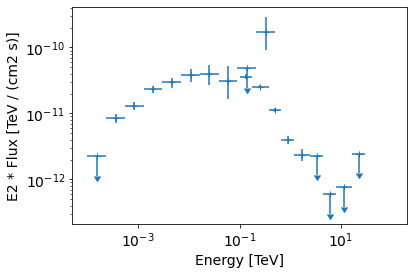

In [83]:
# different model 


ecpl = ExpCutoffPowerLawSpectralModel(
    index=1.5,#alpha=0.0,
    amplitude="6e-5 cm-2 s-1 GeV-1",
    reference="10 GeV",
    lambda_="0.2 TeV-1",
)
ecpl.lambda_.frozen = False
ecpl.reference.frozen = False

model_ecpl = SkyModel(spectral_model=ecpl)

dataset_ecpl = FluxPointsDataset(model_ecpl, flux_points_joint)

#dataset_ecpl.peek()

#ecpl.plot(energy_range=[1e-4, 1e2] * u.TeV, ax=ax, energy_power=2)

print(ecpl)

fitter = Fit([dataset_ecpl])
result_ecpl = fitter.run()
print(result_ecpl)
print(ecpl)

ax = flux_points_joint.plot(energy_power=2)
ecpl.plot(energy_range=[1e-4, 1e2] * u.TeV, ax=ax, energy_power=2)

# assign covariance for plotting
#ecpl.parameters.covariance = result_ecpl.parameters.covariance

ecpl.plot_error(energy_range=[1e-4, 1e2] * u.TeV, ax=ax, energy_power=2)
#ax.set_ylim(1e-13, 2e-10)




In [84]:
result_ecpl.parameters.to_dict()

[{'name': 'index',
  'value': 1.57828579360392,
  'unit': '',
  'min': nan,
  'max': nan,
  'frozen': False,
  'error': 0.0012079650620988995},
 {'name': 'amplitude',
  'value': -4.7162274086076654e-15,
  'unit': 'cm-2 s-1 TeV-1',
  'min': nan,
  'max': nan,
  'frozen': False,
  'error': 1.0800640571183014e-16},
 {'name': 'reference',
  'value': 0.0049998333333396315,
  'unit': 'TeV',
  'min': nan,
  'max': nan,
  'frozen': False,
  'error': 3.960888728499001e-05},
 {'name': 'lambda_',
  'value': 0.2832292929780472,
  'unit': 'TeV-1',
  'min': nan,
  'max': nan,
  'frozen': False,
  'error': 0.0014636681325608915},
 {'name': 'alpha',
  'value': 1.0,
  'unit': '',
  'min': nan,
  'max': nan,
  'frozen': True,
  'error': 0.0}]

LogParabolaSpectralModel

   name     value         unit         min       max    frozen   error  
--------- ---------- -------------- --------- --------- ------ ---------
amplitude 5.0000e-18 cm-2 s-1 TeV-1 5.000e-18 5.000e-16  False 3.028e-24
reference 1.0000e+01            TeV       nan       nan   True 0.000e+00
    alpha 4.2000e-01                4.200e-01 4.200e+01  False 1.352e-04
     beta 1.6000e+00                1.600e-02 1.600e+00  False 1.837e-04
LogParabolaSpectralModel

   name     value         unit         min       max    frozen   error  
--------- ---------- -------------- --------- --------- ------ ---------
amplitude 5.0000e-18 cm-2 s-1 TeV-1 5.000e-18 5.000e-16  False 3.028e-24
reference 1.0000e+01            TeV       nan       nan   True 0.000e+00
    alpha 4.2000e-01                4.200e-01 4.200e+01  False 1.352e-04
     beta 1.6000e+00                1.600e-02 1.600e+00  False 1.837e-04


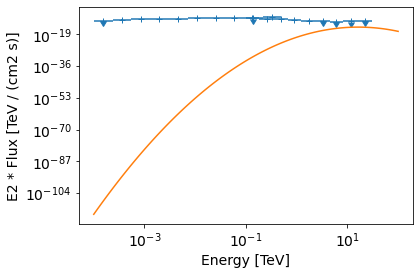

In [88]:
#log_parabola = LogParabolaSpectralModel(
#    alpha=3.48, amplitude="3e-11 cm-2 s-1 TeV-1", reference="0.4 TeV", beta=0.5
#)
log_parabola = LogParabolaSpectralModel(
    alpha=4.2, amplitude="5e-17 cm-2 s-1 TeV-1", reference="10 TeV", beta=0.16
)
for p_ in ["amplitude", "alpha", "beta"]:
    log_parabola.parameters[p_].min = (0.1 * log_parabola.parameters[p_].value)
    log_parabola.parameters[p_].max = (10 * log_parabola.parameters[p_].value)


model = SkyModel(spectral_model=log_parabola, name="1ES1011")

dataset_log_parabola = FluxPointsDataset(model, flux_points_joint)

fitter = Fit([dataset_log_parabola])
result_log_parabola = fitter.run()
print(log_parabola)

#dataset_log_parabola.parameters.to_table()


fit_spec_lp = dataset_log_parabola.models['1ES1011'].spectral_model
#fit_spec_lp.parameters.covariance = result_log_parabola.parameters.get_subcovariance(
#    fit_spec_lp.parameters
#)
print(fit_spec_lp)

ax = flux_points_joint.plot(energy_power=2)
fit_spec_lp.plot(energy_range=[1e-4, 1e2] * u.TeV, ax=ax, energy_power=2)

# assign covariance for plotting
#log_parabola.parameters.covariance = result_log_parabola.parameters.covariance

fit_spec_lp.plot_error(
    energy_range=[1e-4, 1e2] * u.TeV, ax=ax, energy_power=2
)
#ax.set_ylim(1e-13, 1e-11);


In [89]:
from gammapy.modeling.sampling import (
    run_mcmc,
    par_to_model,
    plot_corner,
    plot_trace,
)



In [90]:
with open("3HWC.yaml", 'r') as f:
    cat_3hwc = yaml.load(f)
    
def search_3hwc(name, cat_file="3HWC.yaml"):
    with open("3HWC.yaml", 'r') as f:
        cat_3hwc = yaml.load(f)
    li_ = list(item for item in cat_3hwc if item["name"] == name)
    if li_:
        return li_[0]
    else:
        return None
    
j1849 = search_3hwc('3HWC J1849+001')


/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/ipykernel_launcher.py:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  
/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/ipykernel_launcher.py:6: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


In [91]:
source2hwc1849 = catalog_2hwc.table[19]
source2hwc1849

source_name,ra,dec,glon,glat,pos_err,search_radius,ts,spec0_dnde,spec0_dnde_err,spec0_index,spec0_index_err,spec0_radius,spec1_dnde,spec1_dnde_err,spec1_index,spec1_index_err,spec1_radius
,deg,deg,deg,deg,deg,deg,,1 / (cm2 s TeV),1 / (cm2 s TeV),,,deg,1 / (cm2 s TeV),1 / (cm2 s TeV),,,deg
str15,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2HWC J1849+001,282.393,0.112,32.819,0.466,0.105,0.0,134.3,2.28e-14,2.86e-15,-2.54,0.10,0.000,6.08e-14,4.52e-15,-2.47,0.05,0.800


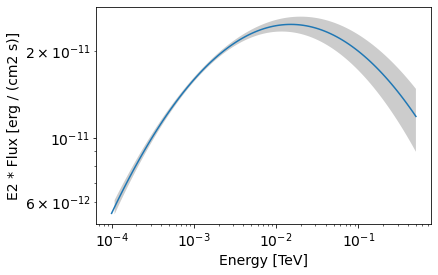

In [92]:

MeV2ergs = 1.60218e-6

source2hwc1849 = catalog_2hwc.table[19]
model = source.sky_model()

energy_range = (100 * u.MeV, 500 * u.GeV)
opts = dict(energy_power=2, flux_unit="erg-1 cm-2 s-1")
model.spectral_model.plot(energy_range, label="4FGL B3 0942+468", **opts)
model.spectral_model.plot_error(energy_range, **opts)



In [93]:
next(item for item in cat_3hwc)["name"] == "3HWC 1849+001"

False

In [94]:
%%time
# Now let's define a function to init parameters and run the MCMC with emcee
# Depending on your number of walkers, Nrun and dimensionality, this can take a while (> minutes)
sampler = run_mcmc(dataset_log_parabola, nwalkers=6, nrun=150)  # to speedup the notebook



/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0


CPU times: user 463 ms, sys: 0 ns, total: 463 ms
Wall time: 467 ms


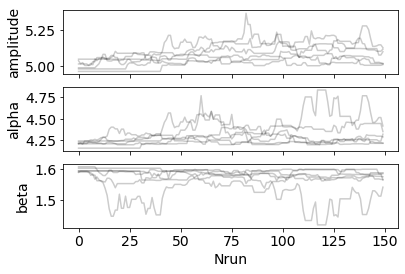

In [95]:
plot_trace(sampler, dataset_log_parabola)


In [96]:
#from gammapy.catalog import SOURCE_CATALOGS
from gammapy.catalog import CATALOG_REGISTRY 
from gammapy.catalog import SourceCatalogHGPS

#catalog_4fgl = SOURCE_CATALOGS.get("4fgl")()
#catalog_3fhl = SOURCE_CATALOGS.get("3fhl")()
#catalog_2hwc = SOURCE_CATALOGS.get("2hwc")()

catalog_gammacat = CATALOG_REGISTRY.get_cls("gamma-cat")()
catalog_2hwc = CATALOG_REGISTRY.get_cls("2hwc")()
catalog_3fhl = CATALOG_REGISTRY.get_cls("3fhl")()
catalog_4fgl = CATALOG_REGISTRY.get_cls("4fgl")()
catalog_hgps = CATALOG_REGISTRY.get_cls("hgps")()




In [97]:
source = catalog_hgps["HESS J1849-000"]
print(source)


*** Basic info ***

Catalog row index (zero-based) : 68
Source name          : HESS J1849-000
Analysis reference   : HGPS
Source class         : PWN
Identified object    : PSR J1849-0001
Gamma-Cat id         : 129


*** Info from map analysis ***

RA                   :  282.237 deg = 18h48m57s
DEC                  :   -0.041 deg = -0d02m29s
GLON                 :   32.611 +/- 0.020 deg
GLAT                 :    0.535 +/- 0.016 deg
Position Error (68%) : 0.040 deg
Position Error (95%) : 0.065 deg
ROI number           : 3
Spatial model        : Gaussian
Spatial components   : HGPSC 088
TS                   : 83.5
sqrt(TS)             : 9.1
Size                 : 0.090 +/- 0.015 (UL: nan) deg
R70                  : 0.161 deg
RSpec                : 0.161 deg
Total model excess   : 248.1
Excess in RSpec      : 178.8
Model Excess in RSpec : 179.7
Background in RSpec  : 374.2
Livetime             : 61.4 hours
Energy threshold     : 0.50 TeV
Source flux (>1 TeV) : (0.532 +/- 0.094) x 10^-12 

In [18]:
#from gammapy.catalog import SOURCE_CATALOGS
from gammapy.catalog import CATALOG_REGISTRY 
from gammapy.catalog import SourceCatalogHGPS

#catalog_4fgl = SOURCE_CATALOGS.get("4fgl")()
#catalog_3fhl = SOURCE_CATALOGS.get("3fhl")()
#catalog_2hwc = SOURCE_CATALOGS.get("2hwc")()

catalog_gammacat = CATALOG_REGISTRY.get_cls("gamma-cat")()
catalog_2hwc = CATALOG_REGISTRY.get_cls("2hwc")()
catalog_3fhl = CATALOG_REGISTRY.get_cls("3fhl")()
catalog_4fgl = CATALOG_REGISTRY.get_cls("4fgl")()
catalog_hgps = CATALOG_REGISTRY.get_cls("hgps")()



source = catalog_hgps["HESS J1849-000"]
source_2hwc = catalog_2hwc["2HWC J1849+001"]
print(source_2hwc)



*** Basic info ***

Catalog row index (zero-based) : 19
Source name : 2HWC J1849+001

*** Position info ***

RA: 282.393 deg
DEC: 0.112 deg
GLON: 32.819 deg
GLAT: 0.466 deg
Position error: 0.105 deg

*** Spectral info ***

Spectrum 0:
Flux at 7 TeV: 2.28e-14 +- 2.86e-15 cm-2 s-1 TeV-1
Spectral index: -2.540 +- 0.100
Test Radius: 0.0 deg

Spectrum 1:
Flux at 7 TeV: 6.08e-14 +- 4.52e-15 cm-2 s-1 TeV-1
Spectral index: -2.470 +- 0.050
Test Radius: 0.8 deg




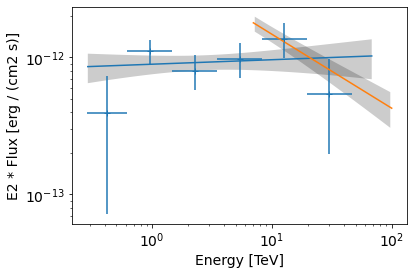

In [99]:
#from gammapy.catalog import SOURCE_CATALOGS
from gammapy.catalog import CATALOG_REGISTRY 
from gammapy.catalog import SourceCatalogHGPS

#catalog_4fgl = SOURCE_CATALOGS.get("4fgl")()
#catalog_3fhl = SOURCE_CATALOGS.get("3fhl")()
#catalog_2hwc = SOURCE_CATALOGS.get("2hwc")()

catalog_gammacat = CATALOG_REGISTRY.get_cls("gamma-cat")()
catalog_2hwc = CATALOG_REGISTRY.get_cls("2hwc")()
catalog_3fhl = CATALOG_REGISTRY.get_cls("3fhl")()
catalog_4fgl = CATALOG_REGISTRY.get_cls("4fgl")()
catalog_hgps = CATALOG_REGISTRY.get_cls("hgps")()



source = catalog_hgps["HESS J1849-000"]
source_2hwc = catalog_2hwc["2HWC J1849+001"]

model = source.sky_model()

energy_range = (290 * u.GeV, 68.13 * u.TeV)
opts = dict(energy_power=2, flux_unit="erg-1 cm-2 s-1")
model.spectral_model.plot(energy_range, **opts)
model.spectral_model.plot_error(energy_range, **opts)

#opts = dict(energy_power=2, flux_unit="erg-1 cm-2 s-1")
#model.spectral_model.plot(energy_range, label="4FGL B3 0942+468", **opts)
#model.spectral_model.plot_error(energy_range, **opts)

flux_points = source.flux_points
#flux_points.plot()
#plt.errorbar(energy_range, flux_points.table['e2dnde'], 
#             yerr=[flux_points.table['e2dnde']-flux_points.table['e2dnde_errn'], 
#                   flux_points.table['e2dnde_errp']-flux_points.table['e2dnde']])
#flux_points.to_sed_type("e2dnde").plot_ts_profiles(ax=ax)
#flux_points.to_sed_type("e2dnde").plot()

cs = plt.rcParams['axes.prop_cycle'].by_key()['color']
flux_points.plot(**opts, color=cs[0])
#flux_points.plot()
#plt.errorbar((flux_points.table['e_min']+flux_points.table['e_max'])/2.e6, 
#                 flux_points.table['flux'], flux_points.table['flux_errn']*5)


model_2hwc = source_2hwc.sky_model()

energy_range = (7 * u.TeV, 100 * u.TeV)
opts = dict(energy_power=2, flux_unit="erg-1 cm-2 s-1")
model_2hwc.spectral_model.plot(energy_range, **opts)
model_2hwc.spectral_model.plot_error(energy_range, **opts)



In [100]:
catalog_4fgldr2 = CATALOG_REGISTRY.get_cls("4fgl")(filename='/home/qifeng/Downloads/gll_psc_v24.fit')
                  #$GAMMAPY_DATA/catalogs/fermi/gll_psc_v20.fit.gz')

In [101]:
catalog_4fgldr2

In [102]:
source1424 = catalog_4fgl["PKS 1424+240"]


NameError: name 'Absorption' is not defined

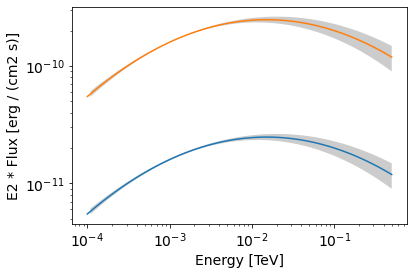

In [103]:
# FSRQs: 
# EBL + PWL model


MeV2ergs = 1.60218e-6

source = source1424
model = source.sky_model()

energy_range = (100 * u.MeV, 500 * u.GeV)
opts = dict(energy_power=2, flux_unit="erg-1 cm-2 s-1")
model.spectral_model.plot(energy_range, label="4FGL B3 0942+468", **opts)
model.spectral_model.plot_error(energy_range, **opts)

mx10 = model.spectral_model.copy()
mx10.amplitude.scale = mx10.amplitude.scale*10
mx10.plot(energy_range, label="4FGL B3 0942+468 flare x10", **opts)
mx10.plot_error(energy_range, **opts)

z=0.639
cs = plt.rcParams['axes.prop_cycle'].by_key()['color']

absorption = Absorption.read_builtin("dominguez")
smodel = AbsorbedSpectralModel(
                    spectral_model=mx10, absorption=absorption, parameter=z, 
    alpha_norm=-1
                    )
smodel.plot(energy_range, label="{} absorbed z={:.2f}".format("B3 0942+468", z),
                            ls="--", alpha=0.7, color=cs[1], **opts)
smodel.plot_error(energy_range, **opts)

    

flux_points = source.flux_points
#flux_points.plot()
#plt.errorbar(energy_range, flux_points.table['e2dnde'], 
#             yerr=[flux_points.table['e2dnde']-flux_points.table['e2dnde_errn'], 
#                   flux_points.table['e2dnde_errp']-flux_points.table['e2dnde']])
#flux_points.to_sed_type("e2dnde").plot_ts_profiles(ax=ax)
#flux_points.to_sed_type("e2dnde").plot()


source = source2
model = source.sky_model()

opts = dict(energy_power=2, flux_unit="erg-1 cm-2 s-1")
model.spectral_model.plot(energy_range, label="4FGL B2 1722+33", **opts)
model.spectral_model.plot_error(energy_range, **opts)

#flux_points = source.flux_points
#flux_points.plot()

        

plt.legend()
plt.savefig("2FSRQs.png", dpi=144)




In [ ]:
plt.errorbar(np.arange(54682, 57550, 60), np.array(source.data['Flux2_History']), 
             xerr=30, yerr=np.array(source.data['Unc_Flux2_History'][:,1]), ls="")#, marker='o')
model = source.sky_model()
modelspec = model.spectral_model.copy()
 
f_ = modelspec.integral(emin=0.1e-3*u.TeV, emax=100e-3*u.TeV)
print(f_)
plt.axhline(f_.value)
plt.axhline(f_.value*10, ls="--")

In [ ]:
source.lightcurve.plot()

In [ ]:
lightcurve.table

In [ ]:
#seven energy bands (1: 50 to 100 MeV; 2: 100 to 300 MeV; 3: 300 MeV to 1 GeV; 4: 1 to 3 GeV; 5: 3 to 10 GeV; 6: 10 to 30 GeV; 7: 30 to 300 GeV)
_4FGL_energy_bands=["50 to 100 MeV",
                    "100 to 300 MeV", 
                    "300 MeV to 1 GeV",
                    "1 to 3 GeV",
                    "3 to 10 GeV", 
                    "10 to 30 GeV", 
                    "30 to 300 GeV"]

_3FHL_energy_bands=["10 to 20 GeV",
                    "20 to 50 GeV", 
                    "50 to 150 GeV",
                    "150 to 500 GeV",
                    "500 to 2000 GeV"]


source1.data['Sqrt_TS_Band'].data[-2:]

In [105]:
# FSRQs: 
# EBL + PWL model
from gammapy.modeling.models import (
    AbsorbedSpectralModel,
    Absorption,
    Models,
    PowerLawSpectralModel,
    SkyModel,
)

MeV2ergs = 1.60218e-6

source = source1
model = source.sky_model()

energy_range = (100 * u.MeV, 500 * u.GeV)
opts = dict(energy_power=2, flux_unit="erg-1 cm-2 s-1")
model.spectral_model.plot(energy_range, label="4FGL B3 0942+468", **opts)
model.spectral_model.plot_error(energy_range, **opts)

mx10 = model.spectral_model.copy()
mx10.amplitude.scale = mx10.amplitude.scale*10
mx10.plot(energy_range, label="4FGL B3 0942+468 flare x10", **opts)
mx10.plot_error(energy_range, **opts)

z=0.639
cs = plt.rcParams['axes.prop_cycle'].by_key()['color']

absorption = Absorption.read_builtin("dominguez")
smodel = AbsorbedSpectralModel(
                    spectral_model=mx10, absorption=absorption, parameter=z, 
    alpha_norm=-1
                    )
smodel.plot(energy_range, label="{} absorbed z={:.2f}".format("B3 0942+468", z),
                            ls="--", alpha=0.7, color=cs[1], **opts)
smodel.plot_error(energy_range, **opts)

    

flux_points = source.flux_points
#flux_points.plot()
#plt.errorbar(energy_range, flux_points.table['e2dnde'], 
#             yerr=[flux_points.table['e2dnde']-flux_points.table['e2dnde_errn'], 
#                   flux_points.table['e2dnde_errp']-flux_points.table['e2dnde']])
#flux_points.to_sed_type("e2dnde").plot_ts_profiles(ax=ax)
#flux_points.to_sed_type("e2dnde").plot()


source = source2
model = source.sky_model()

opts = dict(energy_power=2, flux_unit="erg-1 cm-2 s-1")
model.spectral_model.plot(energy_range, label="4FGL B2 1722+33", **opts)
model.spectral_model.plot_error(energy_range, **opts)

#flux_points = source.flux_points
#flux_points.plot()

        

plt.legend()
plt.savefig("2FSRQs.png", dpi=144)




ImportError: cannot import name 'AbsorbedSpectralModel' from 'gammapy.modeling.models' (/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/modeling/models/__init__.py)

In [ ]:
smodel.alpha_norm

In [ ]:
mx10 = model.spectral_model.copy()
mx10.amplitude.scale = mx10.amplitude.scale*10
dir(mx10)

In [ ]:
mx10.integral(emin=0.2*u.TeV, emax=30*u.TeV)
#mx10.evaluate_integral()

In [ ]:
smodel.integral(emin=200*u.GeV, emax=30*u.TeV)


In [ ]:
elo = 0.2*u.TeV
ehi = 1*u.TeV
mx10.integral(emin=elo, emax=ehi)


In [ ]:
smodel.integral(emin=elo, emax=ehi)


In [106]:
def eval_crab(model, emin, emax, ref="Nigro"):
    #Hillas et al. 1998 ApJ 503 744
    if ref == "Hillas":
        cmodel = PowerLawSpectralModel(
            index=2.49,
            amplitude='3.2e-11  cm-2 s-1 TeV-1',
            reference='1 TeV',
        )
    #Nigro et al.(2019) 2019A&A...625A..10N Nigro, C., Deil, C., Zanin, R., et al.\ 2019, \aap, 625, A10
    elif ref == "Nigro":
        cmodel = LogParabolaSpectralModel(
            alpha=2.51,
            beta=0.24,
            amplitude='3.85e-11  cm-2 s-1 TeV-1',
            reference='1 TeV',
        )
    fc_ = cmodel.integral(emin=emin, emax=emax)
    f_ = model.integral(emin=emin, emax=emax)
    crab_ = f_/fc_
    print("Source flux {} -- {} is {:.3g}".format(emin, emax, f_))
    print("Crab flux {} -- {} is {:.3g}".format(emin, emax, fc_))
    print("Source flux {} -- {} is {:.2g} Crab Unit".format(emin, emax, crab_))

In [107]:
eval_crab(smodel, elo, ehi, ref="Hillas")
eval_crab(smodel, elo, ehi, ref="Nigro")


NameError: name 'smodel' is not defined

In [ ]:
eval_crab(smodel, 0.1*u.TeV, 30*u.TeV, ref="Hillas")
eval_crab(smodel, 0.1*u.TeV, 30*u.TeV, ref="Nigro")


In [ ]:
eval_crab(smodel, 0.1*u.TeV, 1*u.TeV, ref="Nigro")


In [ ]:
# FSRQs: 

MeV2ergs = 1.60218e-6

source = source1
model = source.sky_model()

energy_range = (100 * u.MeV, 500 * u.GeV)
opts = dict(energy_power=2, flux_unit="erg-1 cm-2 s-1")
#model.spectral_model.plot(energy_range, label="4FGL B3 0942+468", **opts)
#model.spectral_model.plot_error(energy_range, **opts)

flux_points = source.flux_points
#flux_points.plot()
#plt.errorbar(energy_range, flux_points.table['e2dnde'], 
#             yerr=[flux_points.table['e2dnde']-flux_points.table['e2dnde_errn'], 
#                   flux_points.table['e2dnde_errp']-flux_points.table['e2dnde']])
#flux_points.to_sed_type("e2dnde").plot_ts_profiles(ax=ax)
#flux_points.to_sed_type("e2dnde").plot()
#flux_points.plot(**opts)
flux_points.plot()
flux_points.table['flux']=flux_points.table['flux']*10
flux_points.plot()
plt.errorbar((flux_points.table['e_min']+flux_points.table['e_max'])/2.e6, 
                 flux_points.table['flux']*5, flux_points.table['flux_errn']*5)

source = source2
model = source.sky_model()

opts = dict(energy_power=2, flux_unit="erg-1 cm-2 s-1")
#model.spectral_model.plot(energy_range, label="4FGL B2 1722+33", **opts)
#model.spectral_model.plot_error(energy_range, **opts)

flux_points = source.flux_points
flux_points.plot()
#flux_points.to_sed_type("e2dnde").plot()


plt.legend()
plt.savefig("2FSRQs_10x.png", dpi=144)




In [ ]:
df_nublazars = pd.read_csv("nublazar.csv")
df_nublazars

In [ ]:
print(source.info())

In [ ]:
source.data['Variability_Index']

In [ ]:
source.data['Flux1000'], source.data['Unc_Flux1000']

In [ ]:
df_nublazars.loc[2,'4FGLname']

In [ ]:
def eval_flux(model, emin, emax):
    f_ = model.integral(emin=emin, emax=emax)
    print("Source flux {} -- {} is {:.3g}".format(emin, emax, f_))
    

In [ ]:
scalefactor=1e-10
df_nublazars['Flux1000']=0
df_nublazars['Unc_Flux1000']=0
df_nublazars['Flux1000e10']=0
df_nublazars['Unc_Flux1000e10']=0

for i, s in enumerate(df_nublazars['Source']):
    source = catalog_4fgl[df_nublazars.loc[i,'4FGLname']]
    df_nublazars.loc[i,'Flux1000'] = "{:.2g}".format(source.data['Flux1000'].value)
    df_nublazars.loc[i,'Unc_Flux1000'] =  "{:.2g}".format(source.data['Unc_Flux1000'].value)
    df_nublazars.loc[i,'Flux1000e10'] = "{:.2g}".format(source.data['Flux1000'].value/1e-10)
    df_nublazars.loc[i,'Unc_Flux1000e10'] =  "{:.2g}".format(source.data['Unc_Flux1000'].value/1e-10)
    print("==== {} ====".format(s))
    print("${:.3g} \pm {:.3g}$".format(source.data['Flux1000'].value/scalefactor, 
                                         source.data['Unc_Flux1000'].value/scalefactor))
    print("var index {}".format(source.data['Variability_Index']))
    


In [ ]:
df_nublazars

In [ ]:
df_nublazars.to_csv("nublazar_long.csv", index=False)

In [ ]:
source.data['Flux1000'].value

In [ ]:
flux_points.table['flux']=flux_points.table['flux']*10
flux_points.table

In [ ]:
lightcurve1 = source1.lightcurve
lightcurve2 = source2.lightcurve


In [ ]:
lightcurve1.table

In [ ]:
lightcurve1.plot()
plt.savefig("B30942+468_4FGL_LC.png")

In [ ]:
lightcurve2.plot()
plt.savefig("B21722+33_4FGL_LC.png")

In [ ]:
catalog_4fgl["Ton 599"].lightcurve.plot()
plt.savefig("Ton599_4FGL_LC.png")

In [ ]:
catalog_4fgl["1ES 1215+303"].lightcurve.plot()


In [ ]:
catalog_4fgl["3C 279"].lightcurve.plot()


In [ ]:
catalog_3fgl = SOURCE_CATALOGS.get("3fgl")()
catalog_3fgl["3FGL J0221.2+2518"].lightcurve.plot()



In [ ]:
source = catalog_3fgl["3FGL J0221.2+2518"]
model = source.sky_model()

energy_range = (100 * u.MeV, 500 * u.GeV)
opts = dict(energy_power=2, flux_unit="erg-1 cm-2 s-1")
model.spectral_model.plot(energy_range, label="3FGL J0221.2+2518", **opts)
model.spectral_model.plot_error(energy_range, **opts)

plt.legend()
#plt.savefig()


In [ ]:
i=140
catalog_3fhl.table[i:10+i]

In [ ]:
source = catalog_3fhl["3FHL J0221.4+2512"]
model = source.sky_model()

energy_range = (10 * u.GeV, 500 * u.GeV)
opts = dict(energy_power=2, flux_unit="erg-1 cm-2 s-1")
model.spectral_model.plot(energy_range, **opts)
model.spectral_model.plot_error(energy_range, **opts)

In [ ]:
source.data

In [ ]:
source = catalog_4fgl["4FGL J0221.5+2513"]
model = source.sky_model()

energy_range = (10 * u.GeV, 500 * u.GeV)
opts = dict(energy_power=2, flux_unit="erg-1 cm-2 s-1")
model.spectral_model.plot(energy_range, **opts)
model.spectral_model.plot_error(energy_range, **opts)


In [ ]:
i=430
catalog_4fgl.table[i:i+10]

In [ ]:
catalog_3fgl["Ton 599"]

In [ ]:
"3FGL J0221.2+2518" in catalog_3fgl.source_name

In [ ]:
source = catalog_3fgl["3FGL J0221.2+2518"]
model = source.sky_model()

energy_range = (100 * u.MeV, 500 * u.GeV)
opts = dict(energy_power=2, flux_unit="erg-1 cm-2 s-1")
model.spectral_model.plot(energy_range, label="3FGL J0221.2+2518", **opts)
model.spectral_model.plot_error(energy_range, **opts)

source = catalog_3fhl["3FHL J0221.4+2512"]
model = source.sky_model()

energy_range = (10 * u.GeV, 500 * u.GeV)
opts = dict(energy_power=2, flux_unit="erg-1 cm-2 s-1")
model.spectral_model.plot(energy_range, label="3FHL J0221.4+2512", **opts)
model.spectral_model.plot_error(energy_range, **opts)

source = catalog_4fgl["4FGL J0221.5+2513"]
model = source.sky_model()

energy_range = (0.1 * u.GeV, 500 * u.GeV)
opts = dict(energy_power=2, flux_unit="erg-1 cm-2 s-1")
model.spectral_model.plot(energy_range, label="4FGL J0221.5+2513", **opts)
model.spectral_model.plot_error(energy_range, **opts)


plt.legend()
plt.savefig("J0221.4+2512.png", dpi=144)


In [ ]:
from gammapy.modeling.models import Absorption
redshift = 0.5
dominguez = Absorption.read_builtin("dominguez").table_model(redshift)
franceschini = Absorption.read_builtin("franceschini").table_model(redshift)
finke = Absorption.read_builtin("finke").table_model(redshift)

plt.figure()
energy_range = [0.08, 3] * u.TeV
opts = dict(energy_range=energy_range, energy_unit="TeV", flux_unit="")
franceschini.plot(label="Franceschini 2008", **opts)
finke.plot(label="Finke 2010", **opts)
dominguez.plot(label="Dominguez 2011", **opts)

plt.ylabel(r"Absorption coefficient [$\exp{(-\tau(E))}$]")
plt.xlim(energy_range.value)
plt.ylim(1e-4, 2)
plt.title(f"EBL models (z={redshift})")
plt.grid(which="both")
plt.legend(loc="best")


In [ ]:
model = source.sky_model()
model.spectral_model

In [ ]:
index = 3.53
amplitude = 1.81 * 1e-12 * u.Unit("cm-2 s-1 TeV-1")
reference = 1 * u.TeV
PowerLawSpectralModel(index=index, amplitude=amplitude, reference=reference)

In [ ]:
# EBL + PWL model
from gammapy.modeling.models import (
    AbsorbedSpectralModel,
    Absorption,
    Models,
    PowerLawSpectralModel,
    SkyModel,
)

source = catalog_3fgl["3FGL J0221.2+2518"]
model = source.sky_model()

energy_range = (100 * u.MeV, 500 * u.GeV)
opts = dict(energy_power=2, flux_unit="erg-1 cm-2 s-1")

absorption = Absorption.read_builtin("dominguez")
redshift=0.5

smodel = AbsorbedSpectralModel(
    spectral_model=model.spectral_model, absorption=absorption, parameter=redshift
)


smodel.plot(energy_range, label="3FGL J0221.2+2518 absorbed", **opts)
smodel.plot_error(energy_range, **opts)

model.spectral_model.plot(energy_range, label="3FGL J0221.2+2518", **opts)
model.spectral_model.plot_error(energy_range, **opts)


plt.grid(which="both")


In [ ]:
from astroquery.simbad import Simbad
result_table = Simbad.query_object("3FGL J0221.2+2518")
c = SkyCoord(result_table['RA'][0]+result_table['DEC'][0], unit=(u.hourangle, u.deg))
result_table['RA'][0][:-1]


In [ ]:
result_table.r

In [ ]:
from astroquery.ned import Ned
#result_table = Ned.get_table("3FGL J0221.2+2518", table='redshifts')
result_table = Ned.get_table("Ton 599", table='redshifts')
print(result_table['Published Redshift','Published Redshift Uncertainty', 'Refcode',])

In [ ]:
result_table.colnames

In [ ]:
df_sens_Crab_h = pd.read_csv("veritas_sens/Crab_2015_hard_10hr_sens.txt", header=None, 
                             names=["time","thresh","Roff","Ron","alpha","crabs","energyGeV","logE","norm","sens","senslo","senshi"])
df_sens_Crab_h

In [ ]:
plt.loglog(10**df_sens_Crab_h.logE, df_sens_Crab_h.sens)

# Reading from DL3, veritas/fermi BBs

In [8]:
from gammapy.data import DataStore

from astropy import units as u
import matplotlib.pyplot as plt
from gammapy.modeling import Fit
from gammapy.modeling.models import Models
from gammapy.datasets import Datasets, FluxPointsDataset, SpectrumDatasetOnOff
from gammapy.estimators import FluxPoints, FluxPointsEstimator
from gammapy.maps import MapAxis
from pathlib import Path

from gammapy.makers import (
    MapDatasetMaker, 
    SafeMaskMaker,
    SpectrumDatasetMaker,
    ReflectedRegionsBackgroundMaker,
)

#data_store = DataStore.from_dir('./1ES1011/DL3_fluxcorr/1ES1011AB_custom_BB1_DL3/')
data_store = DataStore.from_dir('./1ES1011/DL3/')
#              [71969,71970, 71971, 71972, 71989, 71990, 71991, 71992, 71993,
#               72011, 72066, 72121, 72199, 72200, 72224, 72248, 72253, 72259, 
#               72281, 72333, 72368]: 
obs_ids = [71969,71970, 71971, 71972]
obs = data_store.get_observations(obs_ids)
#obs = data_store.get_observations()
#obs_ids = obs.ids

SourceRA = 153.767247
SourceDec = 49.433530
# for skymap
axis = MapAxis.from_edges(
    np.logspace(-1.0, 1.0, 10), unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=(SourceRA, SourceDec), npix=(200, 200), binsz=0.02, frame="icrs", axes=[axis]
)

target_position = SkyCoord(ra=SourceRA, dec=SourceDec, unit="deg", frame="icrs")
on_region_radius = Angle("0.1 deg")
on_region = CircleSkyRegion(center=target_position, radius=on_region_radius)

# exclude the source
exclusion_mask = geom.to_image().region_mask([on_region], inside=False)
exclusion_mask = WcsNDMap(geom.to_image(), exclusion_mask)
exclusion_mask.plot();



# for spectrum
dataset_maker = SpectrumDatasetMaker(
    containment_correction=False, selection=["counts", "exposure", "edisp"]
)
bkg_maker = ReflectedRegionsBackgroundMaker()
safe_mask_masker = SafeMaskMaker(methods=["aeff-max"], aeff_percent=10)

e_reco = MapAxis.from_energy_bounds(0.1, 40, 40, unit="TeV", name="energy")
e_true = MapAxis.from_energy_bounds(
    0.05, 100, 200, unit="TeV", name="energy_true"
)
dataset_empty = SpectrumDataset.create(
    e_reco=e_reco, e_true=e_true, region=on_region
)

datasets = Datasets()

for iobs, observation in enumerate(obs):
    dataset = dataset_maker.run(
        dataset_empty.copy(name=str(obs_ids[iobs])), observation
    )
    dataset_on_off = bkg_maker.run(dataset, observation)
    dataset_on_off = safe_mask_masker.run(dataset_on_off, observation)
    datasets.append(dataset_on_off)

e_min, e_max = 0.2, 30
e_min, e_max = 0.1, 30
e_edges = np.logspace(np.log10(e_min), np.log10(e_max), 15) * u.TeV
#e_edges = MapAxis.from_energy_bounds("1 TeV", "30 TeV", nbin=5).edges


spectral_model = PowerLawSpectralModel(
    index=3, amplitude=1e-11 * u.Unit("cm-2 s-1 TeV-1"), reference=1 * u.TeV
)

spatial_model = PointSpatialModel(
    lon_0="153.767247 deg", lat_0="49.433530 deg", frame="icrs"
)

"""
spectral_model = ExpCutoffPowerLawSpectralModel(
    index=2.3,
    amplitude=2.8e-12 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1.0 * u.TeV,
    lambda_=0.02 / u.TeV,
)
"""

model = SkyModel(
    spatial_model=spatial_model,
    spectral_model=spectral_model,
    name="1ES1011+496",
)

datasets.models = model

fit = Fit(datasets)
result = fit.run()
print(result)

# Flux points are computed on stacked observation
stacked_dataset = datasets.stack_reduce(name="stacked")

print(stacked_dataset)

fpe = FluxPointsEstimator(energy_edges=e_edges, source="1ES1011+496")
flux_pointsV = fpe.run(datasets=stacked_dataset)

flux_points_datasetV = FluxPointsDataset(data=flux_pointsV, models=model)
flux_points_datasetV.plot_fit();

flux_pointsV.table_formatted


Skipping run with missing HDUs; Required HDUs ['psf', 'bkg'] not found in observation 71969
Skipping run with missing HDUs; Required HDUs ['psf', 'bkg'] not found in observation 71970
Skipping run with missing HDUs; Required HDUs ['psf', 'bkg'] not found in observation 71971
Skipping run with missing HDUs; Required HDUs ['psf', 'bkg'] not found in observation 71972


AttributeError: 'WcsNDMap' object has no attribute 'shape'

In [51]:
t = flux_pointsV.table
t

counts [1],e_ref,e_min,e_max,ref_dnde,ref_flux,ref_eflux,ref_e2dnde,norm,stat,success,norm_err,ts,norm_errp,norm_errn,norm_ul,norm_scan [11],stat_scan [11],sqrt_ts,dnde,dnde_ul,dnde_err,dnde_errp,dnde_errn
,TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),,,,,,,,,,,,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV)
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
50,0.24564560522315812,0.21147425268811285,0.2853385818766556,1.542601916613573e-10,1.154548317092278e-11,2.8018719710553283e-12,9.308331981938839e-12,1.2553764518961543,1.2769832389719795,True,0.22318426359412533,71.29677286518489,0.23361166340551792,0.21302623011892655,1.7439292382986538,0.20000000000000004 .. 5.000000000000001,42.89354127122215 .. 117.84111452318876,8.443741638940931,1.9365461207665545e-10,2.6901885854379517e-10,3.442844727782866e-11,3.603697997126368e-11,3.2861467087042016e-11
32,0.3314454017339987,0.2853385818766556,0.3850024543056701,6.039060495740309e-11,6.098606687483353e-12,1.9969619934168774e-12,6.634273579258988e-12,1.1379560343193589,0.9947522475902701,True,0.2655617672799701,38.79845740083286,0.2810888714078476,0.25053380867027364,1.732045947310026,0.20000000000000004 .. 5.000000000000001,22.828555437417805 .. 84.7718873703333,6.228840775042565,6.872185332747342e-11,1.0459930257207079e-10,1.6037435779594488e-11,1.69751269911136e-11,1.5129888267880102e-11
26,0.48199301854726956,0.3850024543056701,0.6034176336545165,1.870095443384437e-11,4.206868290132539e-12,1.9733275713128996e-12,4.344554679124421e-12,1.0801189157937188,2.8826813834862577,True,0.27735378626206636,32.26683523229098,0.2953487742232557,0.26000038093782757,1.707895182267458,0.20000000000000004 .. 5.000000000000001,20.42127962525459 .. 78.6672037973693,5.6803904119603414,2.0199254627391716e-11,3.193926998136605e-11,5.186780518941113e-12,5.523303968840892e-12,4.8622552767004915e-12
7,0.7009216863860872,0.6034176336545165,0.814181063073809,5.791061324578626e-12,1.2367357310889827e-12,8.563939311434473e-13,2.8450975279210816e-12,0.6966909406910418,0.7057710204953906,True,0.40109230553392966,5.360330458900968,0.4513378229785073,0.35462748543100825,1.7059829368573183,0.20000000000000004 .. 5.000000000000001,2.923318801493771 .. 35.27490012787498,2.315238747710691,4.034579961820193e-12,9.879451806025477e-12,2.3227501381636138e-12,2.613725010970348e-12,2.0536695155120823e-12
5,1.0192911339817154,0.814181063073809,1.276072931359183,1.7932983786291307e-12,8.531103245385875e-13,8.462583473303064e-13,1.86315526934834e-12,0.71789179687039,1.6864922995360647,True,0.42420860253821874,5.8684065042423175,0.4877240565641614,0.36621327231887707,1.829039088338339,0.20000000000000004 .. 5.000000000000001,4.031963315826571 .. 30.10420324117627,2.422479412552833,1.2873941953588235e-12,3.2800128315664464e-12,7.607325991323169e-13,8.746347598549331e-13,6.567296674819106e-13
1,1.4822688982138956,1.276072931359183,1.72178331866347,5.553246450948039e-13,2.50797493088273e-13,3.672631565933982e-13,1.2201154876532498e-12,-0.03538255891180597,1.4793096245198036,True,0.6263461730803455,0.003570700947793881,0.8157319260552568,0.49371200120527675,2.039859963900913,0.20000000000000004 .. 5.000000000000001,1.599770400917233 .. 14.093068068670213,-0.05975534242052238,-1.964880697024464e-14,1.132784510496374e-12,3.4782546627233143e-13,4.529960423291363e-13,2.741704418483657e-13
3,2.0,1.72178331866347,2.323172699283085,2.174014624502205e-13,1.32477371965192e-13,2.61757343974246e-13,8.69605849800882e-13,2.5928766136348713,0.015631167619474695,True,1.8695553271493475,5.029255474851665,2.247400903505199,1.5261584582470966,7.896927506453919,0.20000000000000004 .. 5.000000000000001,3.7380036419053067 .. 1.1380335117702156,2.2426001593801033,5.636951677571964e-13,1.716803588766455e-12,4.064440622538686e-13,4.885882431339772e-13,3.3178908

In [46]:
print(result.parameters)

In [31]:
print(stacked_dataset)


SpectrumDatasetOnOff
--------------------

  Name                            : stacked 

  Total counts                    : 233 
  Total off counts                : 882.00
  Total background counts         : 63.00
  Total excess counts             : 170.00

  Predicted counts                : 229.12
  Predicted background counts     : 63.04
  Predicted excess counts         : 166.09

  Exposure min                    : 2.35e+05 m2 s
  Exposure max                    : 8.40e+08 m2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 560.000

  Number of total bins            : 40 
  Number of fit bins              : 38 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 30.20

  Number of models                : 1 
  Number of parameters            : 5
  Number of free parameters       : 4

  Component 0: SkyModel
  
    Name                      : 1ES1011+496
    Datasets names            : None
    Spectral model type       : Po

In [ ]:
stacked_dataset.

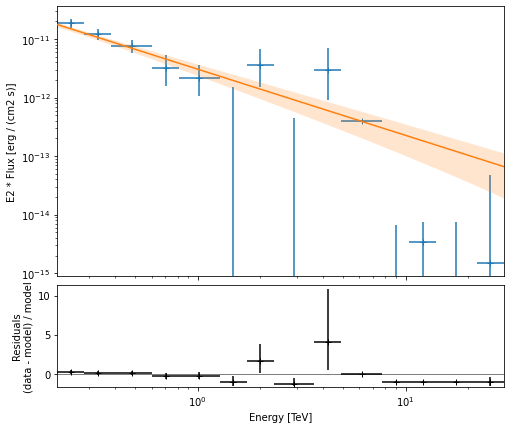

In [16]:
flux_points_datasetV = FluxPointsDataset(data=flux_pointsV, models=model)
flux_points_datasetV.plot_fit(); 


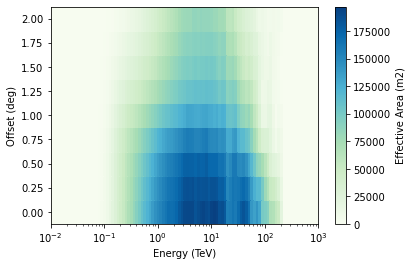

In [23]:
observation.aeff.plot()

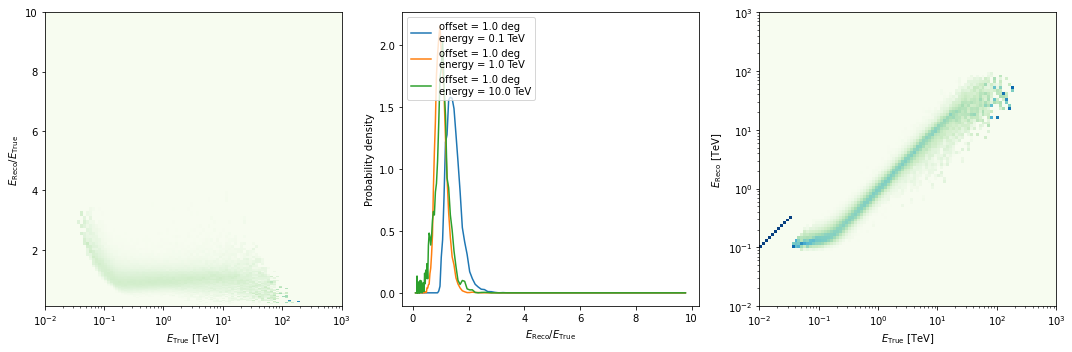

In [27]:
observation.edisp.peek()

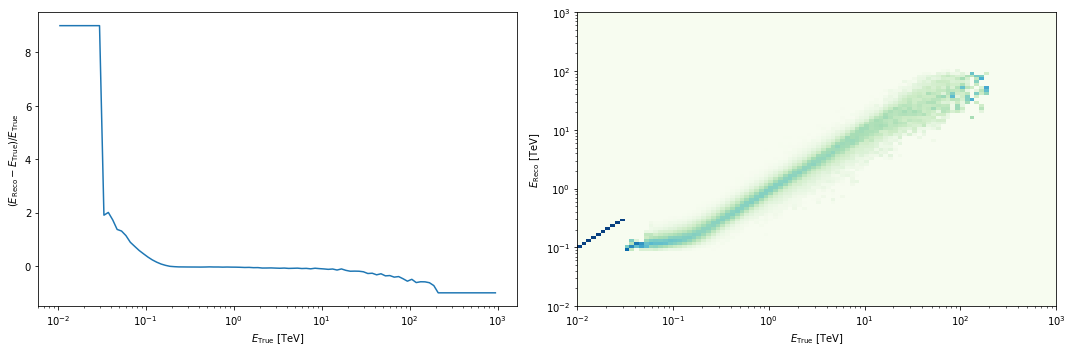

In [29]:
offset = 0.5 * u.degree
edisp = observation.edisp
edisp_kernel = edisp.to_edisp_kernel(offset=offset)
edisp_kernel.peek()

In [39]:
from gammapy.modeling import models

In [ ]:
models.

No covariance estimate - not supported by this backend.


OptimizeResult

	backend    : sherpa
	method     : sherpa
	success    : True
	message    : Optimization terminated successfully
	nfev       : 3060
	total stat : 274.64

SpectrumDatasetOnOff
--------------------

  Name                            : stacked_plec 

  Total counts                    : 233 
  Total off counts                : 882.00
  Total background counts         : 63.00
  Total excess counts             : 170.00

  Predicted counts                : 74.33
  Predicted background counts     : 74.33
  Predicted excess counts         : 0.00

  Exposure min                    : 2.35e+05 m2 s
  Exposure max                    : 8.40e+08 m2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 560.000

  Number of total bins            : 40 
  Number of fit bins              : 38 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 274.64

  Number of models                : 1 
  Number of parameters            : 7
  Number 

/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/datasets/flux_points.py:375: RuntimeWarning: All-NaN slice encountered
  ymin = 1.05 * np.nanmin(residuals.value - yerr[0])
/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/datasets/flux_points.py:376: RuntimeWarning: All-NaN slice encountered
  ymax = 1.05 * np.nanmax(residuals.value + yerr[1])


ValueError: Axis limits cannot be NaN or Inf

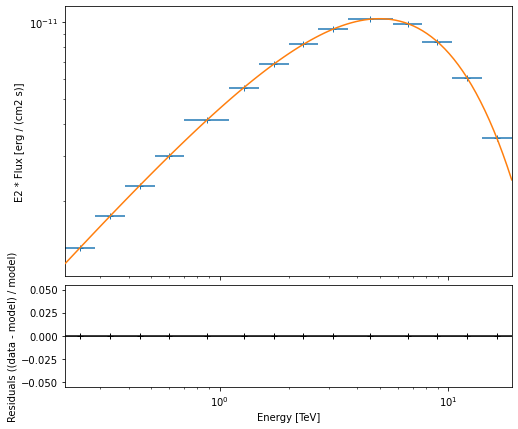

In [111]:
# plec model: 

from gammapy.modeling.models import ExpCutoffPowerLawSpectralModel



datasets_plec = Datasets()

for iobs, observation in enumerate(obs):
    dataset_plec = dataset_maker.run(
        dataset_empty.copy(name=str(obs_ids[iobs])), observation
    )
    dataset_on_off_plec = bkg_maker.run(dataset_plec, observation)
    dataset_on_off_plec = safe_mask_masker.run(dataset_on_off_plec, observation)
    datasets_plec.append(dataset_on_off_plec)

spectral_model_plec = ExpCutoffPowerLawSpectralModel(
    amplitude=3.5e-12 * u.Unit("cm-2 s-1 TeV-1"),
    index=1.0,
    lambda_=0.2 * u.Unit("TeV-1"),
    reference=1 * u.TeV,
)


model_plec = SkyModel(
    spatial_model=spatial_model,
    spectral_model=spectral_model_plec,
    name="1ES1011+496 PLEC",
)

model_plec.spectral_model.index.frozen = False
model_plec.spectral_model.lambda_.frozen = False
model_plec.spatial_model.lon_0.frozen = True
model_plec.spatial_model.lat_0.frozen = True

datasets_plec.models = model_plec

#fit_plec = Fit(datasets_plec)
#result_plec = fit_plec.run(backend="scipy")
#print(result_plec)

# Flux points are computed on stacked observation
stacked_dataset_plec = datasets_plec.stack_reduce(name="stacked_plec")

fit_plec = Fit(stacked_dataset_plec)
#result_plec = fit_plec.run(backend="scipy")
result_plec = fit_plec.run(backend="sherpa")
print(result_plec)

print(stacked_dataset_plec)

e_min_plec, e_max_plec = 0.2, 20
e_edges_plec = np.logspace(np.log10(e_min_plec), np.log10(e_max_plec), 15) * u.TeV

fpe_plec = FluxPointsEstimator(energy_edges=e_edges_plec, source="1ES1011+496 PLEC", reoptimize=True)
flux_pointsV_plec = fpe_plec.run(datasets=stacked_dataset_plec)

# Remove upper limit points, where `dnde_errn = nan`
t_plec = flux_pointsV_plec.table
t_plec["dnde_err"] = 0.5 * (t_plec["dnde_errn"] + t_plec["dnde_errp"])
is_ul_plec = np.isfinite(t_plec["dnde_err"])
#flux_pointsV_plec = FluxPoints(t_plec[is_ul_plec])



flux_points_datasetV_plec = FluxPointsDataset(data=flux_pointsV_plec, models=model_plec)
flux_points_datasetV_plec.plot_fit();
plt.ylim(1e-18, 1e-10)
flux_pointsV_plec.table_formatted



In [105]:
t_plec



counts [1],e_ref,e_min,e_max,ref_dnde,ref_flux,ref_eflux,ref_e2dnde,norm,stat,success,norm_err,ts,norm_errp,norm_errn,norm_ul,norm_scan [11],stat_scan [11],sqrt_ts,dnde,dnde_ul,dnde_err,dnde_errp,dnde_errn
,TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s),TeV / (cm2 s),TeV / (cm2 s),,,,,,,,,,,,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV)
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
38,0.12519219375276877,0.10000000000000002,0.15673085376630796,2.7265705459490884e-11,1.533551191287294e-12,1.9352605126435577e-13,4.2733772952066905e-13,1.0,23.361668766792718,False,nan,0.0,nan,nan,nan,0.20000000000000004 .. 5.000000000000001,23.361668766792718 .. 23.361668766792718,0.0,2.7265705459490884e-11,nan,nan,nan,nan
70,0.18205642030260805,0.15673085376630796,0.21147425268811285,1.853740018054058e-11,1.010880844490715e-12,1.8467588852954227e-13,6.144136049943174e-13,1.0,77.23142218206362,False,nan,0.0,nan,nan,nan,0.20000000000000004 .. 5.000000000000001,77.23142218206362 .. 77.23142218206362,0.0,1.853740018054058e-11,nan,nan,nan,nan
71,0.2647492561625221,0.21147425268811285,0.3314454017339988,1.2538265664228571e-11,1.4910138749776111e-12,3.977181003088364e-13,8.788342313727867e-13,1.0,100.09921418094058,False,nan,0.0,nan,nan,nan,0.20000000000000004 .. 5.000000000000001,100.09921418094058 .. 100.09921418094058,0.0,1.2538265664228571e-11,nan,nan,nan,nan
34,0.41494376952347056,0.3314454017339988,0.5194772079068655,7.763136786996489e-12,1.4465729758275393e-12,6.044605158061432e-13,1.3366439420353288e-12,1.0,45.31938451631436,False,nan,0.0,nan,nan,nan,0.20000000000000004 .. 5.000000000000001,45.31938451631436 .. 45.31938451631436,0.0,7.763136786996489e-12,nan,nan,nan,nan
10,0.6503449126242365,0.5194772079068655,0.814181063073809,4.725372566987695e-12,1.379612878146944e-12,9.028044266261742e-13,1.9985892645532653e-12,1.0,8.163985150498661,False,nan,0.0,nan,nan,nan,0.20000000000000004 .. 5.000000000000001,8.163985150498661 .. 8.163985150498661,0.0,4.725372566987695e-12,nan,nan,nan,nan
4,0.945741609003176,0.814181063073809,1.098560543306118,3.0630174795881917e-12,8.673044845932674e-13,8.221502919266278e-13,2.7396461202517096e-12,1.0,6.855604246744283,False,nan,0.0,nan,nan,nan,0.20000000000000004 .. 5.000000000000001,6.855604246744283 .. 6.855604246744283,0.0,3.0630174795881917e-12,nan,nan,nan,nan
2,1.3753120438672646,1.098560543306118,1.72178331866347,1.932896999224656e-12,1.1925319567111581e-12,1.6462665446978523e-12,3.656042236168275e-12,1.0,2.1821748825016964,False,nan,0.0,nan,nan,nan,0.20000000000000004 .. 5.000000000000001,2.1821748825016964 .. 2.1821748825016964,0.0,1.932896999224656e-12,nan,nan,nan,nan
3,2.155538308304023,1.72178331866347,2.698565695347127,1.0550781282884261e-12,1.019839282745555e-12,2.2007617382869886e-12,4.9022574065007356e-12,1.0,5.182872391405507,False,nan,0.0,nan,nan,nan,0.20000000000000004 .. 5.000000000000001,5.182872391405507 .. 5.182872391405507,0.0,1.0550781282884261e-12,nan,nan,nan,nan


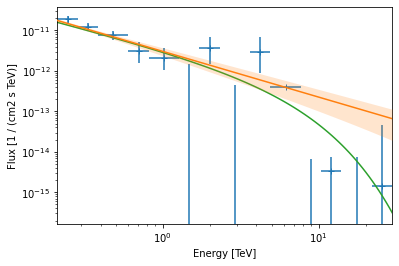

In [86]:
spectral_model_plec = ExpCutoffPowerLawSpectralModel(
    amplitude=3.5e-12 * u.Unit("cm-2 s-1 TeV-1"),
    index=1.0,
    lambda_=0.2 * u.Unit("TeV-1"),
    reference=1 * u.TeV,
)


flux_points_datasetV.plot_spectrum()
spectral_model_plec.plot([e_min_plec, e_max_plec])


(<matplotlib.axes._subplots.AxesSubplot at 0x7ff2ac97cd30>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff2ad1e95f8>)

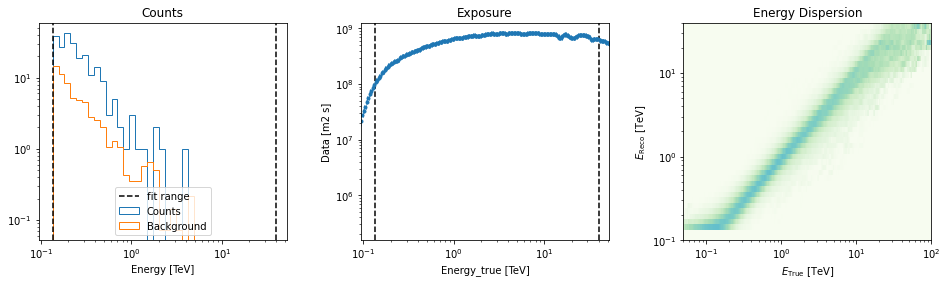

In [63]:
stacked_dataset_plec.peek()

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : False
	message    : Optimization failed.
	nfev       : 24
	total stat : 325.53

SpectrumDatasetOnOff
--------------------

  Name                            : stacked_lp 

  Total counts                    : 233 
  Total off counts                : 882.00
  Total background counts         : 63.00
  Total excess counts             : 170.00

  Predicted counts                : 74.33
  Predicted background counts     : 74.33
  Predicted excess counts         : 0.00

  Exposure min                    : 2.35e+05 m2 s
  Exposure max                    : 8.40e+08 m2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 560.000

  Number of total bins            : 40 
  Number of fit bins              : 38 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 274.64

  Number of models                : 1 
  Number of parameters            : 6
  Number of free parameters 

/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/datasets/flux_points.py:375: RuntimeWarning: All-NaN slice encountered
  ymin = 1.05 * np.nanmin(residuals.value - yerr[0])
/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/gammapy/datasets/flux_points.py:376: RuntimeWarning: All-NaN slice encountered
  ymax = 1.05 * np.nanmax(residuals.value + yerr[1])


ValueError: Axis limits cannot be NaN or Inf

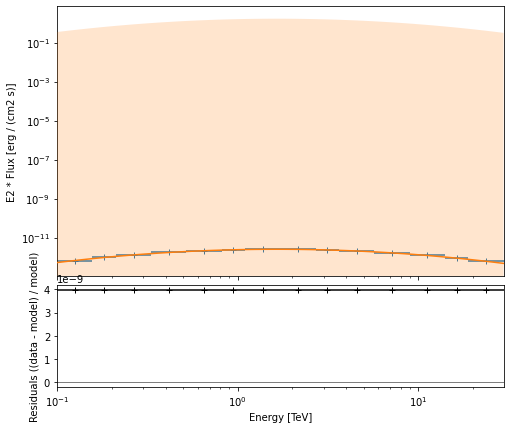

In [100]:
# lp model: 

from gammapy.modeling.models import ExpCutoffPowerLawSpectralModel



datasets_lp = Datasets()

for iobs, observation in enumerate(obs):
    dataset_lp = dataset_maker.run(
        dataset_empty.copy(name=str(obs_ids[iobs])), observation
    )
    dataset_on_off_lp = bkg_maker.run(dataset_lp, observation)
    dataset_on_off_lp = safe_mask_masker.run(dataset_on_off_lp, observation)
    datasets_lp.append(dataset_on_off_lp)

spectral_model_lp = LogParabolaSpectralModel(
    alpha=1.8, amplitude="1.5e-12 cm-2 s-1 TeV-1", reference=1 * u.TeV, beta=0.2,
)


model_lp = SkyModel(
    spatial_model=spatial_model,
    spectral_model=spectral_model_lp,
    name="1ES1011+496 lp",
)

#model_lp.spectral_model.lambda_.frozen = True
model_lp.spatial_model.lon_0.frozen = True
model_lp.spatial_model.lat_0.frozen = True

datasets_lp.models = model_lp

fit_lp = Fit(datasets_lp)
result_lp = fit_lp.run()
print(result_lp)

# Flux points are computed on stacked observation
stacked_dataset_lp = datasets_lp.stack_reduce(name="stacked_lp")

print(stacked_dataset_lp)

e_min_lp, e_max_lp = 0.1, 30
e_edges_lp = np.logspace(np.log10(e_min_lp), np.log10(e_max_lp), 15) * u.TeV 

fpe_lp = FluxPointsEstimator(energy_edges=e_edges_lp, source="1ES1011+496 lp")
flux_pointsV_lp = fpe_lp.run(datasets=stacked_dataset_lp)

# Remove upper limit points, where `dnde_errn = nan`
t_lp = flux_pointsV_lp.table
t_lp["dnde_err"] = 0.5 * (t_lp["dnde_errn"] + t_lp["dnde_errp"])
is_ul_lp = np.isfinite(t_lp["dnde_err"])
#flux_pointsV_lp = FluxPoints(t_lp[is_ul_lp])



flux_points_datasetV_lp = FluxPointsDataset(data=flux_pointsV_lp, models=model_lp)
flux_points_datasetV_lp.plot_fit();
plt.ylim(1e-18, 1e-10)
flux_pointsV_lp.table_formatted


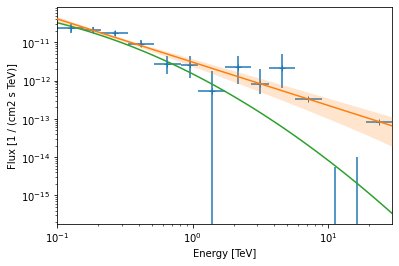

In [99]:
spectral_model_lp = LogParabolaSpectralModel(
    alpha=1.8, amplitude="1.5e-12 cm-2 s-1 TeV-1", reference=1 * u.TeV, beta=0.2,
)



flux_points_datasetV.plot_spectrum()
spectral_model_lp.plot([e_min_plec, e_max_plec])


In [37]:

# create skymap

stacked = MapDataset.create(geom=geom)
stacked.edisp = None
maker = MapDatasetMaker(selection=["counts", "background", "exposure", "psf"])
maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max= 2 * u.deg)

for observation in obs:
    #observation.aeff.meta["TELESCOP"] = "VERITAS"
    # no TELESCOP keyword leads to an error... 
    aeff_ = observation.aeff
    aeff_.meta["TELESCOP"] = "VERITAS"

    print(observation.aeff.meta["TELESCOP"])
    cutout = stacked.cutout(observation.pointing_radec, width="4 deg")
    dataset = maker.run(cutout, observation)
    dataset = maker_safe_mask.run(dataset, observation)
    stacked.stack(dataset)
    
dataset_image = stacked.to_image()
dataset_image.counts.smooth(2).plot(vmax=5);


# source detection



KeyError: 'TELESCOP'

In [84]:
observation

In [82]:
aeff_ = observation.aeff
aeff_.meta["TELESCOP"] = "VERITAS"
aeff_.meta
observation.aeff.meta["TELESCOP"]

KeyError: 'TELESCOP'

'VERITAS'

In [71]:
observation.aeff.meta["TELESCOP"] = "VERITAS"

In [66]:
ts_image_estimator = TSMapEstimator(
    model,
    kernel_width="0.5 deg",
    selection_optional=[],
    downsampling_factor=2,
    sum_over_energy_groups=False,
    energy_edges=[0.1, 10] * u.TeV,
)


In [61]:
observation.obs_info

{'OBS_ID': 71972,
 'RA_PNT': <Quantity 154.53381 deg>,
 'DEC_PNT': <Quantity 49.431675 deg>,
 'ZEN_PNT': <Quantity 21.912199 deg>,
 'ALT_PNT': <Quantity 68.0878 deg>,
 'AZ_PNT': <Quantity 329.04834 deg>,
 'ONTIME': <Quantity 1801. s>,
 'LIVETIME': <Quantity 1536.8293 s>,
 'DEADC': 0.85332,
 'TSTART': <Quantity 2.8420454e+08 s>,
 'TSTOP': <Quantity 2.8420634e+08 s>,
 'N_TELS': 4,
 'TELLIST': 'T1,T2,T3,T4'}

In [50]:
dataset_empty

In [44]:
observation.aeff

TypeError: 'Quantity' object with a scalar value has no len()

In [31]:
data_store.info()


Data store:
HDU index table:
BASE_DIR: 1ES1011/DL3
Rows: 108
OBS_ID: 71969 -- 72368
HDU_TYPE: ['aeff', 'edisp', 'events', 'gti']
HDU_CLASS: ['aeff_2d', 'edisp_2d', 'events', 'gti']


Observation table:
Observatory name: 'N/A'
Number of observations: 27



In [32]:
data_store.obs_table[:2]#[["OBS_ID", "RA_PNT", "DEC_PNT"]]


OBS_ID,RA_PNT,DEC_PNT,ZEN_PNT,ALT_PNT,AZ_PNT,ONTIME,LIVETIME,DEADC,TSTART,TSTOP,N_TELS,TELLIST
,deg,deg,deg,deg,deg,s,s,,s,s,,
int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,bytes20
72034,153.76039,48.92565,19.169325,70.83067,22.667784,1800.0,1691.0941,0.93949676,284628400.0,284630200.0,4,"T1,T2,T3,T4"
72178,154.53792,49.425766,19.600416,70.39958,22.154764,1800.0,1131.8939,0.62882996,285662850.0,285664640.0,4,"T1,T2,T3,T4"


No HDU found matching: OBS_ID = 71969, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 71969, HDU_TYPE = psf, HDU_CLASS = None


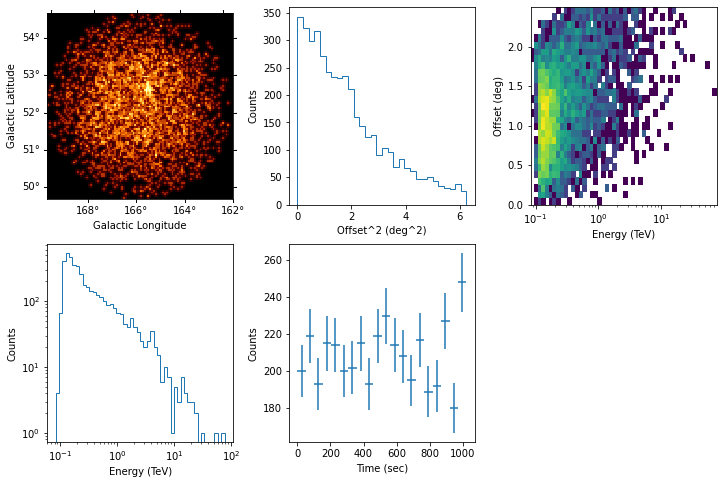

In [33]:
obs = data_store.obs(71969)
obs.events.select_offset([0, 2.5] * u.deg).peek()


In [34]:
obs.bkg is None

True

In [35]:
obs.aeff


In [39]:
obs_ids

['72034',
 '72178',
 '72179',
 '72181',
 '72182',
 '72183',
 '71969',
 '71970',
 '71971',
 '71972',
 '71989',
 '71990',
 '71991',
 '71992',
 '71993',
 '72011',
 '72066',
 '72121',
 '72199',
 '72200',
 '72224',
 '72248',
 '72253',
 '72259',
 '72281',
 '72333',
 '72368']

In [40]:
#for obs_id in [23523, 23526]:
datasets_V = Datasets()
for obs_id in [71969,71970, 71971, 71972, 71989, 71990, 71991, 71992, 71993,
               72011, 72066, 72121, 72199, 72200, 72224, 72248, 72253, 72259, 
               72281, 72333, 72368]: 
#for iobs, obs_id in enumerate(obs_ids):
    print(obs_id)
    #print(f"./1ES1011/DL3_fluxcorr/1ES1011AB_custom_BB1_DL3/St5_{obs_id}UACORmedwinter.fits")
    dataset = SpectrumDatasetOnOff.from_ogip_files(
        #f"./1ES1011/DL3_fluxcorr/1ES1011AB_custom_BB1_DL3/St5_{obs_id}UACORmedwinter.fits"
        f"./1ES1011/DL3/St5_{obs_id}UCORsoftWinter.fits"
    )
    datasets_V.append(dataset)

datasets_V = datasets_V.stack_reduce(name="VERITAS")

datasets.append(datasets_V)

71969


KeyError: "Extension 'SPECTRUM' not found."

In [109]:
obs_ids

['70860', '70861', '70919', '71487', '71560']

In [110]:
obs.ids

['70860', '70861', '70919', '71487', '71560']

In [111]:
observation.aeff


TypeError: 'Quantity' object with a scalar value has no len()

# here1

In [9]:
def e_log_para(E, N0, Ind, Ep):
    #Ind is negative
    #return N0*(np.array(E)/1.)**(Ind)
    return N0*10.0**(Ind*(np.log10(np.array(E)/Ep))**2)/np.array(E)**2

def log_para(E, N0, alpha, beta, Eb):
    return N0*(E/Eb)**(-alpha-beta*np.log10(np.array(E)/Eb))

def log_para300GeV(E, N0, alpha, beta):
    return N0*(E/0.3)**(-alpha-beta*np.log10(np.array(E)/0.3))



def log_log_para(E, N0, alpha, beta, Eb):
    return np.log10(N0)+(-alpha-beta*np.log10(np.array(E)/Eb))*np.log10(np.array(E)/Eb)


def PL_1TeV(E, N0, Ind):
    return N0*(np.array(E)/1.)**(Ind)

def PLexpcut_1TeV(E, N0, Ind, Ecut):
    slice_ind1 = np.where(E<Ecut)
    slice_ind2 = np.where(E>=Ecut)
    dnde = np.zeros_like(E).astype('float')
    dnde[slice_ind1] = N0*(np.array(E[slice_ind1])/1.)**(Ind)
    dnde[slice_ind2] = N0*(np.array(E[slice_ind2])/1.)**(Ind)
    return N0*(np.array(E)/1.)**(Ind)


def PL_super_exp_cut(E, N0=1, ind=2, Ecut=1, beta=1, E0=1):
    return N0*(np.array(E)/E0)**(-ind)*np.exp(-(np.array(E)/Ecut)**beta)




def log_PL_1TeV(E, N0, Ind):
    return  np.log10(N0)+(Ind)*np.log10(np.array(E)/1.)


def PL_400GeV(E, N0, Ind):
    return N0*(np.array(E)/0.4)**(Ind)
def log_lin(E, N0, Ind):
    return np.log10(N0)+Ind*np.log10(np.array(E))

def PL(E, N0, Ind, Enorm=1.0):
    return N0*(np.array(E)/Enorm)**(Ind)



def pl_abs(E, K, alpha, nH, E_norm=1):
    #E has to be in keV
    return np.exp(-nH*get_w_crossecs(E)) * K*(E/E_norm)**(-alpha)

def pl_abs_SED(E, K, alpha, nH, E_norm=1):
    #E has to be in keV
    return (np.exp(-nH*get_w_crossecs(E)) * K*(E/E_norm)**(-alpha))*E*E*1.6022e-9


def pl_deabs(E, F, dF, nH):
    #E has to be in keV; deabsorption
    return np.exp(nH*get_w_crossecs(E)) * F, np.exp(nH*get_w_crossecs(E)) * dF



#Wisconsin photo-electric cross section:
def crossec(c0, c1, c2, E):
    #E has to be in keV, return cm^2
    value=(c0+c1*E+c2*E*E)/E/E/E*1.0e-24
    return value

def get_w_crossec(e):
    # Morrison 83 http://articles.adsabs.harvard.edu/cgi-bin/nph-iarticle_query?1983ApJ...270..119M&amp;data_type=PDF_HIGH&amp;whole_paper=YES&amp;type=PRINTER&amp;filetype=.pdf
    #E has to be in keV
    if (e >= 0.03) and (e < 0.1):
        crosssetion = crossec(17.3, 608.1, -2150.0, e)
    elif (e >= 0.1) and (e < 0.284):
        crosssetion = crossec(34.6, 267.9, -476.1, e)
    elif (e >= 0.284) and (e < 0.4):
        crosssetion = crossec(78.1, 18.8, 4.3, e)
    elif (e >= 0.4) and (e < 0.532):
        crosssetion = crossec(71.4, 66.8, -51.4, e)
    elif (e >= 0.532) and (e < 0.707):
        crosssetion = crossec(95.5, 145.8, -61.1, e)
    elif (e >= 0.707) and (e < 0.867):
        crosssetion = crossec(308.9, -380.6, 294.0, e)
    elif (e >= 0.867) and (e < 1.303):
        crosssetion = crossec(120.6, 169.3, -47.7, e)
    elif (e >= 1.303) and (e < 1.84):
        crosssetion = crossec(141.3, 146.8, -31.5, e)
    elif (e >= 1.84)  and (e < 2.471):
        crosssetion = crossec(202.7, 104.7, -17.0, e)
    elif (e >= 2.471) and (e < 3.21):
        crosssetion = crossec(342.7, 18.7, 0.0, e)
    elif (e >= 3.21) and (e < 4.038):
        crosssetion = crossec(352.2, 18.7, 0.0, e)
    elif (e >= 4.038) and (e < 7.111):
        crosssetion = crossec(433.9, -2.4, 0.75, e)
    elif (e >= 7.111) and (e < 8.331):
        crosssetion = crossec(629.0, 30.9, 0.0, e)
    elif (e >= 8.331) and (e <= 10.0):
        crosssetion = crossec(701.2, 25.2, 0.0, e)
    else:
        crosssetion = 0
    return crosssetion

def get_w_crossecs(es):
    #es is an array in keV
    cs = np.zeros_like(es, dtype=np.float)
    for i, e in enumerate(es):
        cs[i] = get_w_crossec(e)
    return cs



def get_NHtot(NH1=1e21, EBminV=0.604, Nc=3e20, NH2max=7.2e20, alpha=1.1):
    # Willingale 2013 https://academic.oup.com/mnras/article-abstract/431/1/394/1046194
    # Eq 7
    NH2 = NH2max* (( 1.0 - np.exp(-NH1*EBminV/Nc) )**alpha)
    print("NH1={}, NH2={}".format(NH1, NH2))
    return NH1+2.*NH2

def chisq(y_vals, y_expected, y_errs, num_params=1):
    #returns chi2, dof, red_chi2
    #  for reduced chisq test, under the assumption of Poisson counting
    #  we have lnL = const - (1/2.)*chi2
    if y_vals.shape[0] != y_expected.shape[0]:
        print("Inconsistent input sizes")
        return
    #z = (y_vals[i] - y_expected[i]) / y_errs[i]    
    z = (y_vals - y_expected) / y_errs
    chi2 = np.sum(z ** 2)
    chi2dof = chi2 / (y_vals.shape[0] - num_params)
    return chi2, (y_vals.shape[0] - num_params), chi2dof




fLP = lambda E,N0,alpha,beta,Eb: N0*(E/Eb)**(-alpha-beta*np.log10(np.array(E)/Eb))
ferrLP = lambda E,F,N0,N0err,alpha,dalpha,beta,dbeta,Eb: \
        F*np.sqrt(N0err**2/N0**2 + (np.log(E/Eb))**2 * dalpha**2 + \
                  (np.log(E/Eb))**2 * (np.log10(E/Eb))**2 * dbeta**2)

fPL = lambda E,N0,E0,gamma: N0*(E/E0)**(-1*gamma)
ferrPL = lambda E,F,N0,N0err,E0,cov_gg: F*np.sqrt(N0err**2/N0**2 + ((np.log(E/E0))**2)*cov_gg)




In [10]:

Enorm = 0.4

f = "1ES1011/VEGAS_spec_1ES1011_fluxcorr_BB1.dat"
df_Vspec = pd.read_csv(f, sep = r"\s+",  header=None, comment='#', skiprows=1, 
                    names=['+', 'bin' , 'E', 'dE' ,'f' ,'df', 'Non', 'Noff', 'Nexcess', 'RawOff', 
                           'Alpha', 'Sig', 'Emin', 'Emax'])
df_Vspec_flux = df_Vspec[df_Vspec['+']=='+']
df_Vspec_ul = df_Vspec[df_Vspec['+']=='-']

ff = "1ES1011/fermi/1ES1011_pipeline_BB_selected1.npy"
lat_spec = np.load(ff, allow_pickle=True, encoding='latin1').item()
#print(lat_spec) # Display contents of dictionary


In [11]:
#lat_spec['sources']


In [12]:
# plec deabs

# plec model 

def plec2(E, N0, gamma, E0, Ec_inv, alpha):
    return N0*(E/E0)**(-gamma)*np.exp( -(Ec_inv*np.array(E))**alpha )

def plec2_0p1TeV(E, N0, gamma, Ec_inv, alpha):
    return N0*(E/0.1)**(-gamma)*np.exp( -(Ec_inv*np.array(E))**alpha )

def plec2_E2_100GeV(E, N0, gamma, Ec_inv, alpha):
    return N0*(E/100.)**(-gamma)*np.exp( -(Ec_inv*np.array(E))**alpha )*E*E

def log_plec2(logE, N0, gamma, E0, Ec_inv, alpha):
    return np.log10(N0)-gamma*(logE-np.log10(E0)) + np.log10(np.exp(-(Ec_inv*10**np.array(logE))**alpha))+ 2*logE

def log_plec2_100GeV(logE, N0, gamma, Ec_inv, alpha):
    return np.log10(N0)-gamma*(logE-2) + np.log10(np.exp(-(Ec_inv*10**np.array(logE))**alpha))  + 2*logE


def fit_plec(df_combined, p0=[3e-14, 1.5, 1e3,0.01], bounds=([1e-16,1,1e-5,0], [3.e-11, 5., 1e6,100]),
             ax=None, color='k', ls="--", alpha=0.8, fit_func=plec2_E2_100GeV, MCbound=True):
    #    df_combined = pd.DataFrame(columns=['E_GeV','F','dF','dElo','dEhi','F_deabs','dF_deabs','isUL','Instrument','Tag'])
    #ps_plec, dps_plec, chi2_plec, dof_plec, redchi2_plec = fit_factory_boundMC(plec2_0p1TeV, 
    df_flux = df_combined[df_combined["isUL"]==False]
    #print("==== look here ====")
    #print(df_flux)
    e_tev_joint = df_flux["E_GeV"]
    f_deabs = df_flux["F_deabs"]
    df_deabs = df_flux["dF_deabs"]
    #print(df_flux.E_GeV.values[0],df_flux.dElo.values[0],df_flux.E_GeV.values[-1],df_flux.dEhi.values[-1])
    plotEs = np.logspace(np.log10(df_flux.E_GeV.values[0]-df_flux.dElo.values[0]),np.log10(df_flux.E_GeV.values[-1]+df_flux.dEhi.values[-1]),100)
    #print(plotEs)
    try:
        if MCbound:
            #ps_plec, dps_plec, chi2_plec, dof_plec, redchi2_plec = fit_factory(fit_func, 
            ps_plec, dps_plec, chi2_plec, dof_plec, redchi2_plec, x_values, y_low, y_high = fit_factory_boundMC(fit_func, 
                                                           e_tev_joint, f_deabs,
                                                        dy=df_deabs, plotEs=plotEs ,
                                                             p0=p0, bounds=bounds)
        else: 
            ps_plec, dps_plec, chi2_plec, dof_plec, redchi2_plec = fit_factory(fit_func, 
            #ps_plec, dps_plec, chi2_plec, dof_plec, redchi2_plec, x_values, y_low, y_high = fit_factory_boundMC(fit_func, 
                                                           e_tev_joint, f_deabs,
                                                        dy=df_deabs, plotEs=plotEs ,
                                                             p0=p0, bounds=bounds)

        model_plec = fit_func(plotEs, *ps_plec) 
        #print(plotEs, x_values)
        

    except:
        raise
        print("*** fit for SED failed ***")
        model_plec = fit_func(plotEs, *p0) 
        color='gray'
        alpha=0.2
        #model_plec = model_plec*0


    #ax = flux_points_joint.plot(energy_power=0)
    #ax.plot(plotEs, model_plec)
    if ax is not None:
        ax.plot(plotEs, model_plec, color=color, ls=ls, lw=3, alpha=alpha)
        if MCbound:
            ax.fill_between(x_values, y_low, y_high, alpha=0.3,color=color)

    return plotEs, model_plec, ps_plec


def fit_log_plec(df_combined, p0=[3e-14, 1.5, 1e-3,0.01], bounds=([1e-16,1,1e-5,0], [3.e-11, 5., 1e6,100]),
             ax=None, color='k', ls="--", alpha=0.8, fit_func=log_plec2_100GeV, MCbound=False):
    #    df_combined = pd.DataFrame(columns=['E_GeV','F','dF','dElo','dEhi','F_deabs','dF_deabs','isUL','Instrument','Tag'])
    #ps_plec, dps_plec, chi2_plec, dof_plec, redchi2_plec = fit_factory_boundMC(plec2_0p1TeV, 
    print("Fitting in log space")
    df_flux = df_combined[df_combined["isUL"]==False]
    #print("==== look here ====")
    #print(df_flux)
    log_e_tev_joint = np.log10(df_flux["E_GeV"])
    log_f_deabs = np.log10(df_flux["F_deabs"])
    log_df_deabs = 0.434*df_flux["dF_deabs"]/df_flux["F_deabs"]
    #print(df_flux.E_GeV.values[0],df_flux.dElo.values[0],df_flux.E_GeV.values[-1],df_flux.dEhi.values[-1])
    log_plotEs = np.linspace(np.log10(df_flux.E_GeV.values[0]-df_flux.dElo.values[0]),np.log10(df_flux.E_GeV.values[-1]+df_flux.dEhi.values[-1]),100)
    #print(plotEs)
    try:
        if MCbound:
            #ps_plec, dps_plec, chi2_plec, dof_plec, redchi2_plec = fit_factory(fit_func, 
            ps_plec, dps_plec, chi2_plec, dof_plec, redchi2_plec, x_values, y_low, y_high = fit_factory_boundMC(fit_func, 
                                                           log_e_tev_joint, log_f_deabs,
                                                        dy=log_df_deabs, plotEs=log_plotEs ,
                                                             p0=p0, bounds=bounds)
        else: 
            ps_plec, dps_plec, chi2_plec, dof_plec, redchi2_plec = fit_factory(fit_func, 
            #ps_plec, dps_plec, chi2_plec, dof_plec, redchi2_plec, x_values, y_low, y_high = fit_factory_boundMC(fit_func, 
                                                           log_e_tev_joint, log_f_deabs,
                                                        dy=log_df_deabs, plotEs=log_plotEs ,
                                                             p0=p0, bounds=bounds)
        log_model_plec = fit_func(log_plotEs, *ps_plec) 
        #print(plotEs, x_values)
        

    except:
        raise
        print("*** fit for SED failed ***")
        log_model_plec = fit_func(log_plotEs, *p0) 
        color='gray'
        alpha=0.2
        #model_plec = model_plec*0


    #ax = flux_points_joint.plot(energy_power=0)
    #ax.plot(plotEs, model_plec)
    if ax is not None:
        ax.plot(10**log_plotEs, 10**log_model_plec, color=color, ls=ls, lw=3, alpha=alpha)
        if MCbound:
            ax.fill_between(10**x_values, 10**y_low, 10**y_high, alpha=0.3,color=color)

    return 10**log_plotEs, 10**log_model_plec, ps_plec



In [13]:
# de-absorption
def deabs_z(e_tev_joint, f_tev_joint, df_tev_joint, model="dominguez", z=0.212):
    f_deabs = np.zeros_like(f_tev_joint)
    df_deabs = np.zeros_like(df_tev_joint)
    
    eblmodel = EBLAbsorptionNormSpectralModel.read_builtin(model, redshift=z)

    for i, e_ in enumerate(e_tev_joint):
        if e_ >= 1e-3:
            ebl_frac = eblmodel.evaluate_error(e_*u.TeV)[0]
        else:
            ebl_frac = 1.0
        #print(e_, f_tev_joint[i],ebl_frac)
        f_deabs[i] = f_tev_joint[i] / ebl_frac
        df_deabs[i] = df_tev_joint[i] / ebl_frac
    return f_deabs, df_deabs


def plot_lat_spec(sed, 
               z = 0, ethresh=0.2, 
               ax = None, tag="", format_ax=False, 
               c_='k', f_='s', l_="Fermi-LAT" ,
               save_csv=None, alpha=0.7, 
               outfile=None, #'1ES1011_VERITAS_spec.pdf', 
               convert_to_cm=True, p0=[3e-14, 1.5, 1e3,0.01], 
               model=None,  df_combined=None, fit=False,  **kwargs):
    
 
        
    if ax is None:
        fig = plt.figure()

        fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)

        ax = fig.add_subplot(111)
        format_ax = True
        
    if format_ax: 
        ticksize=14
        ax.xaxis.set_tick_params(labelsize=ticksize)
        ax.yaxis.set_tick_params(labelsize=ticksize)


        #ax.ticklabel_format(style='plain', useOffset=False, axis='x')
        #plt.ticklabel_format(style='plain', useOffset=False, axis='x')

        ax.set_xlabel('E (GeV)', fontsize=14)
        #ax.set_ylabel('dN/dE (TeV$^{-1}$ cm$^{-2}$ s$^{-1}$)', fontsize=14)
        ax.set_ylabel(r'$\nu$F$_\nu$ (erg cm$^{-2}$ s$^{-1}$)', fontsize=15)

        ax.set_xscale('log')
        ax.set_yscale('log')

        ticksize=13
        #ax.xaxis.set_tick_params(labelsize=ticksize, which="both")
        #ax.yaxis.set_tick_params(labelsize=ticksize, which="both")


        #ax.xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
        #ax.xaxis.set_minor_formatter(FormatStrFormatter("%.1f"))

        #plt.xticks(rotation=60)
        #plt.setp(ax.xaxis.get_minorticklabels(), rotation=60)


        ax.tick_params(labelsize=ticksize, which="both")

        #ax.set_ylim(1e-9, 2e-5)
        #ax.set_xlim(0.091,2.900)
    
    #plotEs = np.logspace(np.log10(df_.E[0]*1e3),np.log10(df_.E.values[-1]*1e3),100)
    mev2ergs = 1.6e-6
    tev2ergs = 1.6
    
    latalpha=alpha
           
    # fermi
    
    ul_ts_threshold = 4
    kw = {}
    #kw['marker'] = kwargs.get('marker', 'o')
    #kw['linestyle'] = kwargs.get('linestyle', 'None')
    #kw['color'] = kwargs.get('color', 'k')
    kw['marker'] = kwargs.get('marker', 'o')
    kw['linestyle'] = kwargs.get('linestyle', 'None')
    kw['color'] = kwargs.get('color', 'k')
    kw['alpha'] = latalpha
    #kw['label']=""
    
    #fmin, fmax = SEDPlotter.get_ylims(sed)
    
    ethresh_slice = sed['e_ctr']>=(ethresh*1e3)
    m = sed['ts'] < ul_ts_threshold
    x = sed['e_ctr']*1e-3
    y = sed['e2dnde']*mev2ergs
    yerr = sed['e2dnde_err']*mev2ergs
    yerr_lo = sed['e2dnde_err_lo']*mev2ergs
    yerr_hi = sed['e2dnde_err_hi']*mev2ergs
    yul = sed['e2dnde_ul95']*mev2ergs

    delo = sed['e_ctr']*1e-3 - sed['e_min']*1e-3
    dehi = sed['e_max']*1e-3 - sed['e_ctr']*1e-3
    
    
    m = m[ethresh_slice]
    x = x[ethresh_slice]
    y = y[ethresh_slice]
    yerr = yerr[ethresh_slice]
    yerr_lo = yerr_lo[ethresh_slice]
    yerr_hi = yerr_hi[ethresh_slice]
    yul = yul[ethresh_slice]
    delo = delo[ethresh_slice]
    dehi = dehi[ethresh_slice]
    
    xerr0 = np.vstack((delo[m], dehi[m]))
    xerr1 = np.vstack((delo[~m], dehi[~m]))

    if z > 0:
        y_deabs, yerr_deabs = deabs_z(x*1e-3, y, yerr, z=z)
        y_deabs, yerr_lo_deabs = deabs_z(x*1e-3, y, yerr_lo, z=z)
        y_deabs, yerr_hi_deabs = deabs_z(x*1e-3, y, yerr_hi, z=z)
        y_deabs, yul_deabs = deabs_z(x*1e-3, y, yul, z=z)

        ax.errorbar(x[~m], y_deabs[~m], xerr=xerr1,
                 yerr=(yerr_lo_deabs[~m], yerr_hi_deabs[~m]), 
                 **kw)
    
        kw['alpha'] = latalpha/2.
        ax.errorbar(x[m], yul_deabs[m], xerr=xerr0,
                     yerr=yul_deabs[m] * 0.2, uplims=True, **kw)

        latalpha = 0.3
    ax.errorbar(x[~m], y[~m], xerr=xerr1,
                 yerr=(yerr_lo[~m], yerr_hi[~m]), 
                 **kw)
    
    kw['alpha'] = latalpha - 0.2
    ax.errorbar(x[m], yul[m], xerr=xerr0,
                 yerr=yul[m] * 0.2, uplims=True, **kw)
    
    
    
    #ax.legend(loc='upper left', fontsize=13,frameon=False)
    plt.tight_layout()
    if outfile is not None: 
        plt.savefig(outfile)

    
    if df_combined is None: 
        # writing to file
        df_combined = pd.DataFrame(columns=['E_GeV','F','dF','dElo','dEhi','F_deabs','dF_deabs','isUL','Instrument','Tag'])
        len_cur = 0
    else: 
        len_cur  = len(df_combined)
        
    for i in range(len(x)):
        df_combined.loc[i+len_cur] = [x[i], y[i], yerr[i],  delo[i], dehi[i], y_deabs[i], yerr_deabs[i], m[i], "Fermi-LAT", tag]

    len_lat  = len(df_combined)

    if save_csv is not None: 
        df_combined.to_csv(save_csv, index=False)
    #ax.set_yscale('log')
    #ax.set_xscale('log')
    #ax.set_xlim(sed['e_min'][0], sed['e_max'][-1])
    #ax.set_ylim(10 ** fmin, 10 ** fmax)

    print(len(df_combined[df_combined["isUL"]==False]))
    if len(df_combined[df_combined["isUL"]==False])>4 and fit:
        #fit_plec(df_combined, p0=p0, ax=ax, color=c_)
        fit_log_plec(df_combined, p0=p0, ax=ax, color=c_)
    else:
        if fit:
            print("Too few data points to fit plec")
        
        
    #ax.legend(loc='upper left', fontsize=13,frameon=False)
    plt.tight_layout()
    if outfile is not None: 
        plt.savefig(outfile)

        
        
    #plt.show()
    return ax, df_combined



def plot_Vspec(df_Vspec, sed, 
               z = 0, 
               ax = None, tag="BB1", format_ax=False, 
               c_='k', f_='s', l_="VERITAS" ,
               save_csv=None, alpha=0.7, 
               outfile=None, #'1ES1011_VERITAS_spec.pdf', 
               convert_to_cm=True, p0=[3e-14, 1.5, 1e3,0.01], 
               model=None,  fit=False, **kwargs):
    
    if convert_to_cm and np.mean(df_Vspec["f"])>1e-9:
            df_Vspec["f"]=df_Vspec["f"]*1e-4
            df_Vspec["df"] = df_Vspec["df"].values.astype(float)*1e-4

    if z > 0:
        f_deabs, df_deabs = deabs_z(df_Vspec["E"], df_Vspec["f"], df_Vspec["df"], z=z)
        df_Vspec["f_deabs"] = f_deabs 
        df_Vspec["df_deabs"] = df_deabs
    else: 
        df_Vspec["f_deabs"] = 0
        df_Vspec["df_deabs"] = 0
        
    df_ = df_Vspec[df_Vspec['+']=='+']
    df_ul = df_Vspec[df_Vspec['+']=='-']

    
        
    if ax is None:
        fig = plt.figure()

        fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)

        ax = fig.add_subplot(111)
        format_ax = True
        
    if format_ax: 
        ticksize=14
        ax.xaxis.set_tick_params(labelsize=ticksize)
        ax.yaxis.set_tick_params(labelsize=ticksize)


        #ax.ticklabel_format(style='plain', useOffset=False, axis='x') #6panel
        
        #plt.ticklabel_format(style='plain', useOffset=False, axis='x')

        ax.set_xlabel('E (GeV)', fontsize=14)
        #ax.set_ylabel('dN/dE (TeV$^{-1}$ cm$^{-2}$ s$^{-1}$)', fontsize=14)
        ax.set_ylabel(r'$\nu$F$_\nu$ (erg cm$^{-2}$ s$^{-1}$)', fontsize=15)

        ax.set_xscale('log')
        ax.set_yscale('log')

        ticksize=13
        #ax.xaxis.set_tick_params(labelsize=ticksize, which="both")
        #ax.yaxis.set_tick_params(labelsize=ticksize, which="both")


        #ax.xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
        #ax.xaxis.set_minor_formatter(FormatStrFormatter("%.1f"))

        #plt.xticks(rotation=60)
        #plt.setp(ax.xaxis.get_minorticklabels(), rotation=60)


        ax.tick_params(labelsize=ticksize, which="both")

        #ax.set_ylim(1e-9, 2e-5)
        #ax.set_xlim(0.091,2.900)
    
    #plotEs = np.logspace(np.log10(df_.E[0]*1e3),np.log10(df_.E.values[-1]*1e3),100)
    mev2ergs = 1.6e-6
    tev2ergs = 1.6
    
    latalpha=alpha
                
    if z>0:
        # plot flux (GeV)
        ax.errorbar(df_.E*1e3, df_["f_deabs"]*df_.E*df_.E*tev2ergs, yerr=np.array(df_["df_deabs"]*df_.E*df_.E*tev2ergs),  
                    xerr = [df_['E']*1e3 - df_['Emin']*1e3,  df_['Emax']*1e3-df_['E']*1e3], 
                    color=c_, fmt=f_, label=l_,
                    #ms=8, 
                    mec=c_, ls="",
                    ecolor=c_, capthick=0, alpha=alpha)

        # plot UL
        ax.errorbar(df_ul.E*1e3, df_ul["f_deabs"]*df_ul.E*df_ul.E*tev2ergs,
                    xerr = [df_ul['E']*1e3 - df_ul['Emin']*1e3,  df_ul['Emax']*1e3-df_ul['E']*1e3], 
                    yerr=df_ul["f_deabs"]*df_ul.E*df_ul.E*tev2ergs * 3.e-1, uplims=True, 
                    color=c_, marker=f_, label="", 
                    #ms=8, 
                    mec=c_, ls="",
                    ecolor=c_, capthick=0, alpha=alpha/2.)
        alpha=0.3
        l_ = "" # just plot one legend 

    # plot flux (GeV)
    ax.errorbar(df_.E*1e3, df_["f"]*df_.E*df_.E*tev2ergs, yerr=np.array(df_["df"]*df_.E*df_.E*tev2ergs),  
                xerr = [df_['E']*1e3 - df_['Emin']*1e3,  df_['Emax']*1e3-df_['E']*1e3], 
                color=c_, fmt=f_, label=l_,
                #ms=8, 
                mec=c_, ls="",
                ecolor=c_, capthick=0, alpha=alpha)
    
    # plot UL
    ax.errorbar(df_ul.E*1e3, df_ul["f"]*df_ul.E*df_ul.E*tev2ergs,
                xerr = [df_ul['E']*1e3 - df_ul['Emin']*1e3,  df_ul['Emax']*1e3-df_ul['E']*1e3], 
                yerr=df_ul["f"]*df_ul.E*df_ul.E*tev2ergs * 3.e-1, uplims=True, 
                color=c_, marker=f_, label="", 
                #ms=8, 
                mec=c_, ls="",
                ecolor=c_, capthick=0, alpha=alpha-0.2)

        
    #plotEs = np.logspace(np.log10(df_.Emin[0]*1e3),np.log10(df_.Emax.values[-1]*1e3),100)
    plotEs = np.logspace(np.log10(df_Vspec.Emin[0]*1e3),np.log10(df_Vspec.Emax.values[-1]*1e3),100)
    
    if model in ['PL', 'pl'] and len(df_)>1:
            ps_, dps_, chi2_, dof_, redchi2_ = fit_factory(PL_400GeV, 
                                                       df_.E*1e3, 
                                                       df_["f"], 
                                                       dy=np.array(df_["df"]), 
                                                       p0=[1.2e-11, -3.6])

            model_ = fPL(plotEs, ps_[0], 0.4, -ps_[1]) 
            model_err = ferrPL(plotEs, model_, ps_[0],dps_[0],0.4, dps_[1]**2)
            ax.plot(plotEs, model_, color=c_, ls='--')
            ax.fill_between(plotEs,(model_-model_err),
                            (model_+model_err),alpha=0.3,color=c_)


        #log_para300GeV(E, N0, alpha, beta)
        #fLP = lambda E,N0,alpha,beta,Eb: N0*(E/Eb)**(-alpha-beta*np.log10(np.array(E)/Eb))
        #ferrLP = lambda E,F,N0,N0err,alpha,dalpha,beta,dbeta,Eb: \
        #    F*np.sqrt(N0err**2/N0**2 + (np.log(E/Eb))**2 * dalpha**2 + \
        #              (np.log(E/Eb))**2 * (np.log10(E/Eb))**2 * dbeta**2)

    elif model in ['LP', 'lp'] and len(df_)>2:
            ps_lp, dps_lp, chi2_lp, dof_lp, redchi2_lp = fit_factory(log_para300GeV, 
                                                       df_.E*1e3, 
                                                       df_["f"], 
                                                       dy=np.array(df_["df"]), 
                                                       p0=[9e-11, 3.3, 0.6])

            model_lp = log_para300GeV(plotEs, ps_lp[0], ps_lp[1], ps_lp[2])# *plotEs*plotEs
            model_errlp = ferrLP(plotEs, model_lp, ps_lp[0],dps_lp[0], 
                             ps_lp[1],dps_lp[1], ps_lp[2],dps_lp[2], 0.3)#*plotEs*plotEs
            ax.plot(plotEs, model_lp, color=c_, ls='--')
            ax.fill_between(plotEs,(model_lp-model_errlp),
                        (model_lp+model_errlp),alpha=0.3,color=c_)
            model_ = model_lp
            model_err = model_errlp
            ps_ =  ps_lp
            dps_ = dps_lp
    else:
            #print("Can't recognize model {}".format(model))
            #print("or too few data points {}".format(len(df_)))
            print("")


            
    # fermi
    
    ul_ts_threshold = 4
    kw = {}
    #kw['marker'] = kwargs.get('marker', 'o')
    #kw['linestyle'] = kwargs.get('linestyle', 'None')
    #kw['color'] = kwargs.get('color', 'k')
    kw['marker'] = kwargs.get('marker', 'o')
    kw['linestyle'] = kwargs.get('linestyle', 'None')
    kw['color'] = kwargs.get('color', 'k')
    kw['alpha'] = latalpha
    #kw['label']=""
    
    #fmin, fmax = SEDPlotter.get_ylims(sed)

    m = sed['ts'] < ul_ts_threshold
    x = sed['e_ctr']*1e-3
    y = sed['e2dnde']*mev2ergs
    yerr = sed['e2dnde_err']*mev2ergs
    yerr_lo = sed['e2dnde_err_lo']*mev2ergs
    yerr_hi = sed['e2dnde_err_hi']*mev2ergs
    yul = sed['e2dnde_ul95']*mev2ergs

    delo = sed['e_ctr']*1e-3 - sed['e_min']*1e-3
    dehi = sed['e_max']*1e-3 - sed['e_ctr']*1e-3
    xerr0 = np.vstack((delo[m], dehi[m]))
    xerr1 = np.vstack((delo[~m], dehi[~m]))

    if z > 0:
        y_deabs, yerr_deabs = deabs_z(x*1e-3, y, yerr, z=z)
        y_deabs, yerr_lo_deabs = deabs_z(x*1e-3, y, yerr_lo, z=z)
        y_deabs, yerr_hi_deabs = deabs_z(x*1e-3, y, yerr_hi, z=z)
        y_deabs, yul_deabs = deabs_z(x*1e-3, y, yul, z=z)

        ax.errorbar(x[~m], y_deabs[~m], xerr=xerr1,
                 yerr=(yerr_lo_deabs[~m], yerr_hi_deabs[~m]), 
                 **kw)
    
        kw['alpha'] = latalpha/2.
        ax.errorbar(x[m], yul_deabs[m], xerr=xerr0,
                     yerr=yul_deabs[m] * 0.2, uplims=True, **kw)

        latalpha = 0.3
    ax.errorbar(x[~m], y[~m], xerr=xerr1,
                 yerr=(yerr_lo[~m], yerr_hi[~m]), 
                 **kw)
    
    kw['alpha'] = latalpha - 0.2
    ax.errorbar(x[m], yul[m], xerr=xerr0,
                 yerr=yul[m] * 0.2, uplims=True, **kw)
    
    
    # writing to file
    df_combined = pd.DataFrame(columns=['E_GeV','F','dF','dElo','dEhi','F_deabs','dF_deabs','isUL','Instrument','Tag'])

    for i in range(len(x)):
        df_combined.loc[i] = [x[i], y[i], yerr[i],  delo[i], dehi[i], y_deabs[i], yerr_deabs[i], m[i], "Fermi-LAT", tag]

    len_lat  = len(df_combined)
    for i, row in df_Vspec.iterrows():
        df_combined.loc[i+len_lat] = [row['E']*1e3, row["f"]*row['E']*row['E']*tev2ergs,  row["df"]*row['E']*row['E']*tev2ergs, 
                                     row['E']*1e3-row['Emin']*1e3, row['Emax']*1e3-row['E']*1e3, 
                                      row["f_deabs"]*row.E*row.E*tev2ergs, row["df_deabs"]*row.E*row.E*tev2ergs]+ [True if row['+'] == '-' else False] + ["VERITAS"] + [tag]

    if save_csv is not None: 
        df_combined.to_csv(save_csv, index=False)
    #ax.set_yscale('log')
    #ax.set_xscale('log')
    #ax.set_xlim(sed['e_min'][0], sed['e_max'][-1])
    #ax.set_ylim(10 ** fmin, 10 ** fmax)

    print(len(df_combined[df_combined["isUL"]==False]))
    if len(df_combined[df_combined["isUL"]==False])>4 and fit:
        fit_plec(df_combined, p0=p0, ax=ax, color=c_, MCbound=False)
        #fit_log_plec(df_combined, p0=p0, ax=ax, color=c_)
    else:
        if fit:
            print("Too few data points to fit plec")
    #ax.legend(loc='upper left', fontsize=13,frameon=False)
    plt.tight_layout()
    if outfile is not None: 
        plt.savefig(outfile)

    #plt.show()
    if model in ['LP', 'lp', 'PL', 'pl']: 
        return df_combined, ax, ps_, dps_, model_, model_err
    return df_combined, ax


def plot_EDspec(df_EDspec_flux, df_EDspec_ul=None, 
               z = 0, 
               ax = None, tag="ED BB1", format_ax=False, 
               c_='k', f_='s', l_="ED" ,
               #save_csv=None, 
                alpha=0.7, model_color='k', model_ls="--", 
               #outfile=None, #'1ES1011_VERITAS_spec.pdf', 
              p0=[3e-14, 1.5, 1e3,0.01], bounds=([1e-16,1,1e-5,0], [3.e-11, 5., 1e6,100]), fit_func=plec2_E2_100GeV, 
               #model=None,  
                df_combined=None, fit=True, save_csv=None, 
                **kwargs):
    

    if z > 0:
        f_deabs, df_deabs = deabs_z(df_EDspec_flux["E"], df_EDspec_flux["f"], df_EDspec_flux["df"], z=z)
        df_EDspec_flux["f_deabs"] = f_deabs 
        df_EDspec_flux["df_deabs"] = df_deabs
        df_ = df_EDspec_flux
        if df_EDspec_ul is not None: 
            ul_deabs, _ = deabs_z(df_EDspec_ul["E"], df_EDspec_ul["f"], df_EDspec_ul["df"], z=z)
            df_EDspec_ul["f_deabs"] = ul_deabs
            df_ul = df_EDspec_ul
            
    else: 
        df_EDspec_flux["f_deabs"] = 0
        df_EDspec_flux["df_deabs"] = 0 
        df_EDspec_ul["f_deabs"] = 0
        df_ = df_EDspec_flux
        df_ul = df_EDspec_ul
            
    if ax is None:
        fig = plt.figure()
        fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
        ax = fig.add_subplot(111)
        format_ax = True
        
    if format_ax: 
        ticksize=14
        ax.xaxis.set_tick_params(labelsize=ticksize)
        ax.yaxis.set_tick_params(labelsize=ticksize)

        ax.set_xlabel('E (GeV)', fontsize=14)
        ax.set_ylabel(r'$\nu$F$_\nu$ (erg cm$^{-2}$ s$^{-1}$)', fontsize=15)

        ax.set_xscale('log')
        ax.set_yscale('log')

        ticksize=13
        ax.tick_params(labelsize=ticksize, which="both")

    
    #plotEs = np.logspace(np.log10(df_.E[0]*1e3),np.log10(df_.E.values[-1]*1e3),100)
    tev2ergs = 1.6

    if z>0:
        # plot flux (GeV)
        ax.errorbar(df_.E*1e3, df_["f_deabs"]*df_.E*df_.E*tev2ergs, yerr=np.array(df_["df_deabs"]*df_.E*df_.E*tev2ergs),  
                    xerr = [df_['E']*1e3 - df_['Emin']*1e3,  df_['Emax']*1e3-df_['E']*1e3], 
                    color=c_, fmt=f_, label=l_,
                    #ms=8, 
                    mec=c_, ls="",
                    ecolor=c_, capthick=0, alpha=alpha)

        # plot UL
        if df_EDspec_ul is not None: 
            ax.errorbar(df_ul.E*1e3, df_ul["f_deabs"]*df_ul.E*df_ul.E*tev2ergs,
                    xerr = [df_ul['E']*1e3 - df_ul['Emin']*1e3,  df_ul['Emax']*1e3-df_ul['E']*1e3], 
                    yerr=df_ul["f_deabs"]*df_ul.E*df_ul.E*tev2ergs * 3.e-1, uplims=True, 
                    color=c_, marker=f_, label="", 
                    #ms=8, 
                    mec=c_, ls="",
                    ecolor=c_, capthick=0, alpha=alpha/2.)
        alpha=0.1
        l_ = "" # just plot one legend 

    # plot flux (GeV)
    ax.errorbar(df_.E*1e3, df_["f"]*df_.E*df_.E*tev2ergs, yerr=np.array(df_["df"]*df_.E*df_.E*tev2ergs),  
                xerr = [df_['E']*1e3 - df_['Emin']*1e3,  df_['Emax']*1e3-df_['E']*1e3], 
                color=c_, fmt=f_, label=l_,
                #ms=8, 
                mec=c_, ls="",
                ecolor=c_, capthick=0, alpha=alpha)
    
    # plot UL
    if df_EDspec_ul is not None: 
        ax.errorbar(df_ul.E*1e3, df_ul["f"]*df_ul.E*df_ul.E*tev2ergs,
                xerr = [df_ul['E']*1e3 - df_ul['Emin']*1e3,  df_ul['Emax']*1e3-df_ul['E']*1e3], 
                yerr=df_ul["f"]*df_ul.E*df_ul.E*tev2ergs * 3.e-1, uplims=True, 
                color=c_, marker=f_, label="", 
                #ms=8, 
                mec=c_, ls="",
                ecolor=c_, capthick=0, alpha=alpha-0.2)
        
    if df_combined is None: 
        # writing to file
        df_combined = pd.DataFrame(columns=['E_GeV','F','dF','dElo','dEhi','F_deabs','dF_deabs','isUL','Instrument','Tag'])
        len_cur = 0
    else: 
        len_cur  = len(df_combined)
        
    for i, row in df_EDspec_flux.iterrows():
        #['E', 'Emin', 'Emax', 'dE' ,'f' ,'df', 'dflo', 'dfhi', 
        #   'Non', 'dNon', 'Noff', 'dNoff', 
        #   'Alpha', 'Sig', 'T', "_", "EA"]
    
        df_combined.loc[i+len_cur] = [row['E']*1e3, row["f"]*row['E']*row['E']*tev2ergs,  row["df"]*row['E']*row['E']*tev2ergs, 
                                     row['E']*1e3-row['Emin']*1e3, row['Emax']*1e3-row['E']*1e3, 
                                      row["f_deabs"]*row.E*row.E*tev2ergs, row["df_deabs"]*row.E*row.E*tev2ergs]+ [True if row['df'] == 0 else False] + ["VERITAS ED"] + [tag]

    if save_csv is not None: 
        df_combined.to_csv(save_csv, index=False)
    #ax.set_yscale('log')
    #ax.set_xscale('log')
    #ax.set_xlim(sed['e_min'][0], sed['e_max'][-1])
    #ax.set_ylim(10 ** fmin, 10 ** fmax)

    #print(df_combined)
    print(len(df_combined[df_combined["isUL"]==False]))
    if len(df_combined[df_combined["isUL"]==False])>4 and fit:
        if fit_func == log_plec2_100GeV:
            plotEs, model_plec, ps_plec = fit_log_plec(df_combined[df_combined['F_deabs'] != (np.inf or -np.inf)], 
                 p0=p0, bounds=bounds, ax=ax, color=model_color, ls = model_ls, 
                fit_func=fit_func)
        else:
            fit_plec(df_combined[df_combined['F_deabs'] != (np.inf or -np.inf)], 
                 p0=p0, bounds=bounds, ax=ax, color=model_color, ls = model_ls, 
                fit_func=fit_func)
        
    else:
        if fit:
            print("Too few data points to fit plec")
        

    return ax, df_combined

def read_ED_spec(f, sigma=0, skiprows=0):
    
    #df_EDspec = pd.read_csv(f, sep = r"\s+",  header=None, comment='#', #skiprows=1, 
    #                        #index=False, 
    #                    names=['E', 'Emin', 'Emax', 'dE' ,'f' ,'df', 'dflo', 'dfhi', 
    #                           'Non', 'dNon', 'Noff', 'dNoff', 
    #                           'Alpha', 'Sig', 'T'])
    
    df_EDspec = pd.read_csv(f, 
                  skiprows=skiprows, comment="#", sep=r'\s+', header=None, 
                  names=['E', 'Emin', 'Emax', 'dE' ,'f' ,'df', 'dflo', 'dfhi', 
                               'Non', 'dNon', 'Noff', 'dNoff', 
                               'Alpha', 'Sig', 'T', "_", "EA"])
    if sigma <= 0:
        df_EDspec_flux = df_EDspec[df_EDspec['df'] != 0]
        df_EDspec_ul = df_EDspec[df_EDspec['df']==0]
    else:
        #df_EDspec_flux = df_EDspec.loc[(df_EDspec['df'] != 0) & (df_EDspec['Sig'] >= sigma)]
        #df_EDspec_ul = df_EDspec.loc[ (df_EDspec['df']==0) | (df_EDspec['Sig'] < sigma)]
        #100TeV limit just for 1959
        df_EDspec_flux = df_EDspec.loc[(df_EDspec['df'] != 0) & (df_EDspec['Sig'] >= sigma) & (df_EDspec['E'] <= 100)]
        df_EDspec_ul = df_EDspec.loc[ (df_EDspec['df']==0) | (df_EDspec['Sig'] < sigma) |   (df_EDspec['E'] > 100)]
    
    #print(df_EDspec[df_EDspec['df'] != 0])
    #print(df_EDspec_flux)
    return df_EDspec_flux, df_EDspec_ul


def process_BB(f = "1ES1011/VEGAS_spec_1ES1011_fluxcorr_BB1.dat", 
              ff = "1ES1011/fermi/1ES1011_pipeline_BB_selected1/4fgl_j1015.0+4926_sed.npy", 
               ED = None, EDsigma=0, EDcolor='k', EDmarker="X", EDalpha=0.6,
               z=0.212, fitV=False ,
               ax = None, alpha=0.7, color='k', label="VERITAS", tag="BB1", format_ax=False,
               p0=[3e-14, 1.5, 1e3,0.01], 
               bounds=([1e-16,1,1e-5,0], [3.e-11, 5., 1e6,100]), 
                       fit_func=plec2_E2_100GeV, 
               model_color='k', model_ls="--", 
              save_csv="1ES1011_LAT_VER_SED_BB1.csv", 
               outfile='1ES1011_LAT_VER_SED_BB1_observed.pdf'):
    
    lat_spec = np.load(ff, allow_pickle=True, encoding='latin1').item()

    if f is not None: 
        #print("got f")
        df_Vspec = pd.read_csv(f, sep = r"\s+",  header=None, comment='#', skiprows=1, 
                            names=['+', 'bin' , 'E', 'dE' ,'f' ,'df', 'Non', 'Noff', 'Nexcess', 'RawOff', 
                                   'Alpha', 'Sig', 'Emin', 'Emax'])
        df_Vspec_flux = df_Vspec[df_Vspec['+']=='+']
        df_Vspec_ul = df_Vspec[df_Vspec['+']=='-']
        df_combined, ax = plot_Vspec(df_Vspec, lat_spec, 
                        z=z, fit=fitV, 
               ax = ax, tag=tag, format_ax=format_ax, 
               c_=color, f_='s', l_=label , alpha=alpha, color=color,
               save_csv=save_csv, 
                        p0=p0, 
               outfile=outfile, #convert_to_cm=False,
               model=None)
        
    if ED is not None: 
        df_EDspec_flux, df_EDspec_ul = read_ED_spec(ED, sigma=EDsigma)
        ax, df_combined = plot_lat_spec(lat_spec, 
                        z=z, 
               ax = ax, tag=tag, format_ax=format_ax, 
               c_=color, f_='s', l_=label , alpha=alpha, color=color,
               save_csv=save_csv, 
                        p0=p0, 
               outfile=outfile, #convert_to_cm=False,
               model=None)
        ax, df_combined = plot_EDspec(df_EDspec_flux, z=z, ax = ax, 
                   c_=EDcolor, f_=EDmarker, l_="ED" , alpha=EDalpha, color=EDcolor,
                                     df_combined=df_combined, save_csv=save_csv, 
                                       model_color=model_color, model_ls = model_ls, 
                                     p0=p0, bounds=bounds, fit_func=fit_func)
        
    return ax



In [10]:
df_ = pd.read_csv("./BlazarLightCurves/attic/Spectra_ABonly/1ES0033_spectralfit_fulldataset.dat", 
                  skiprows=9, comment="#", sep=r'\s+', header=None, 
                  names=['E', 'Emin', 'Emax', 'dE' ,'f' ,'df', 'dflo', 'dfhi', 
                               'Non', 'dNon', 'Noff', 'dNoff', 
                               'Alpha', 'Sig', 'T', "_", "EA"])
print(df_)

          E     Emin     Emax      dE             f            df  \
0     0.251    0.200    0.316   0.117  1.098000e-10  1.095000e-10   
1     0.398    0.316    0.501   0.185  2.014000e-11  1.663000e-12   
2     0.631    0.501    0.794   0.293  3.079000e-12  4.176000e-13   
3     1.000    0.794    1.259   0.465  6.217000e-13  1.259000e-13   
4     1.585    1.259    1.995   0.736  6.800000e-14  3.585000e-14   
5     2.512    1.995    3.162   1.167  2.533000e-15  1.009000e-14   
6     3.981    3.162    5.012   1.850  1.123000e-15  3.102000e-15   
7     6.310    5.012    7.943   2.931  6.323000e-16  1.049000e-15   
8    10.000    7.943   12.589   4.646  2.701000e-16  5.623000e-16   
9    15.849   12.589   19.953   7.363  2.071000e-16  3.191000e-16   
10   39.811   31.623   50.119  18.496  8.749000e-17  1.750000e-17   
11   63.096   50.119   79.433  29.314  5.133000e-17  1.027000e-17   
12  100.000   79.433  125.893  46.460  3.026000e-17  6.053000e-18   
13  158.489  125.893  199.526  73.

NameError: name 'EBLAbsorptionNormSpectralModel' is not defined

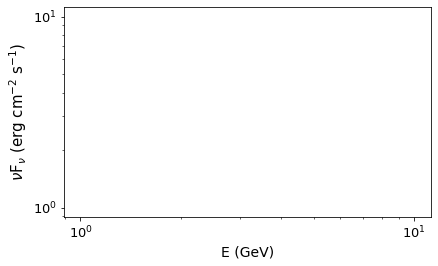

In [11]:
i = 1
n = 2
colors = plt.cm.viridis(np.linspace(0,0.9,n))

_ = process_BB(f=None, 
              ff = "1ES1011/fermi/1ES1011_pipeline_BB_selected{}/4fgl_j1015.0+4926_sed.npy".format(i), 
              ED = "1ES1011/ED_spec_1ES1011_AB_BB{}.dat".format(i), 
               EDcolor='k', EDmarker="X", EDalpha=0.2,
                    ax =None, tag="BB{}".format(i), format_ax=True, 
               color=colors[i], label="BB{}".format(i) , alpha=0.9, 
              save_csv=None, #"1ES1011_LAT_VER_SED_BB{}.csv".format(i), 
               outfile=None,) #'1ES1011_LAT_VER_SED_BB{}_observed.pdf'.format(i))
#_.set_ylim(2e-12, 1e-8)
#_.legend()
plt.show()

/Users/qifeng/.pyenv/versions/3.10.2/lib/python3.10/site-packages/astropy/units/quantity.py:504: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  value = np.array(value, dtype=dtype, copy=copy, order=order,


27
37
MC best-fit param 0 = 2.713e-13 +/- 1.009e-13
MC best-fit param 1 = 1.501 +/- 0.0402
MC best-fit param 2 = 1e+06 +/- 3.371e-10
MC best-fit param 3 = 0.08547 +/- 0.004125
MC fit Chisq is 91.466, dof is 32, reduced Chisq is 2.86
MC Log likelihood lnL=-45.73297353932392


/Users/qifeng/.pyenv/versions/3.10.2/lib/python3.10/site-packages/astropy/units/quantity.py:504: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  value = np.array(value, dtype=dtype, copy=copy, order=order,
/Users/qifeng/.pyenv/versions/3.10.2/lib/python3.10/site-packages/astropy/units/quantity.py:613: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/qifeng/.local/lib/python3.10/site-packages/matplotlib/axes/_axes.py:3465: RuntimeWarning: invalid value encountered in add
  low, high = dep + np.row_stack([-(1 - lolims), 1 - uplims]) * err


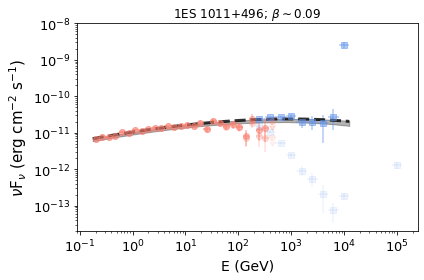

In [26]:
#def plec2_E2_100GeV(E, N0, gamma, Ec_inv, alpha):
#    return N0*(E/100.)**(-gamma)*np.exp( -(Ec_inv*np.array(E))**alpha )*E*E
#bounds=([1e-16,1,1e-5,0], [3.e-12, 5., 1e5,100])


_ = process_BB(f=None, 
              ff = "./GwenSED/4fgl_j1015.0+4926_sed.npy", 
              ED = "./BlazarLightCurves/Spectra_ABonly/1ES1011_spectralfit_fulldataset.dat", 
               EDcolor='cornflowerblue', EDmarker="s", EDalpha=0.5, z=0.212, 
                    ax =None, tag="BB{}".format(i), format_ax=True, 
               color="salmon", label="BB{}".format(i) , alpha=0.5, 
              save_csv=None, #"1ES1011_LAT_VER_SED_BB{}.csv".format(i), 
               outfile=None,) #'1ES1011_LAT_VER_SED_BB{}_observed.pdf'.format(i))
_.set_ylim(2e-14, 1e-8)
#_.legend()
plt.title(r"1ES 1011+496; $\beta\sim${:.2f}".format(0.09))
plt.tight_layout()
#plt.savefig("1ES1011_LAT_VER_SED_avg_z0p212.pdf")
plt.show()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


29
Too few data points to fit plec
39
best-fit param 0 = 2.786e-13 +/- 9.462e-14
best-fit param 1 = 1.498 +/- 0.03632
best-fit param 2 = 1e+06 +/- 3.042e-10
best-fit param 3 = 0.08576 +/- 0.00376
fit Chisq is 92.049, dof is 34, reduced Chisq is 2.71
Log likelihood lnL=-46.02451423091393


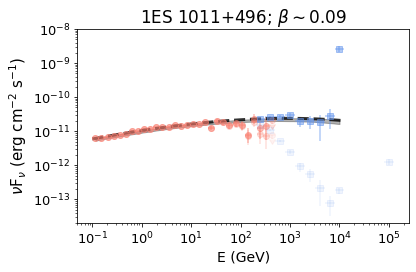

In [285]:
#def plec2_E2_100GeV(E, N0, gamma, Ec_inv, alpha):
#    return N0*(E/100.)**(-gamma)*np.exp( -(Ec_inv*np.array(E))**alpha )*E*E
#bounds=([1e-16,1,1e-5,0], [3.e-12, 5., 1e5,100])


_ = process_BB(f=None, 
              ff = "./GwenSED/4fgl_j1015.0+4926_sed.npy", 
              ED = "./BlazarLightCurves/Spectra_ABonly/1ES1011_spectralfit_fulldataset.dat", 
               EDcolor='cornflowerblue', EDmarker="s", EDalpha=0.5, z=0.212, 
                    ax =None, tag="BB{}".format(i), format_ax=True, 
               color="salmon", label="BB{}".format(i) , alpha=0.5, 
              save_csv=None, #"1ES1011_LAT_VER_SED_BB{}.csv".format(i), 
               outfile=None,) #'1ES1011_LAT_VER_SED_BB{}_observed.pdf'.format(i))
_.set_ylim(2e-14, 1e-8)
#_.legend()
plt.title(r"1ES 1011+496; $\beta\sim${:.2f}".format(0.09))
plt.tight_layout()
plt.savefig("1ES1011_LAT_VER_SED_avg_z0p212_v3.pdf")
plt.show()

/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:377: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  subok=False, ndmin=ndmin)
No handles with labels found to put in legend.
No handles with labels found to put in legend.


28
Too few data points to fit plec
45


/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/matplotlib/axes/_axes.py:3322: RuntimeWarning: invalid value encountered in double_scalars
  low = [v - e for v, e in zip(data, a)]


best-fit param 0 = 1.772e-11 +/- 3.945e-12
best-fit param 1 = 1 +/- 0.03022
best-fit param 2 = 3.819e+04 +/- 2.786e-08
best-fit param 3 = 0.1486 +/- 0.001627
fit Chisq is 85.650, dof is 35, reduced Chisq is 2.45
Log likelihood lnL=-42.8247827754275


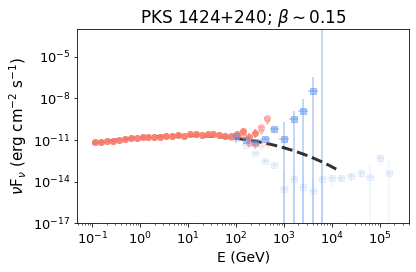

In [250]:
#def plec2_E2_100GeV(E, N0, gamma, Ec_inv, alpha):
#    return N0*(E/100.)**(-gamma)*np.exp( -(Ec_inv*np.array(E))**alpha )*E*E
#bounds=([1e-16,1,1e-5,0], [3.e-12, 5., 1e5,100])



_ = process_BB(f=None, 
              ff = "./GwenSED/4fgl_j1427.0+2348_sed.npy", 
              ED = "./BlazarLightCurves/Spectra_ABonly/PKS1424_spectralfit_fulldataset.dat", 
               EDcolor='cornflowerblue', EDmarker="s", EDalpha=0.5, z=0.604, 
                    ax =None, tag="PKS1424+240", format_ax=True, 
               color="salmon", label="PKS1424+240" , alpha=0.9, 
              save_csv=None, #"1ES1011_LAT_VER_SED_BB{}.csv".format(i), 
               outfile=None,) #'1ES1011_LAT_VER_SED_BB{}_observed.pdf'.format(i))
_.set_ylim(1e-17, 1e-3)
#_.legend()
plt.title(r"PKS 1424+240; $\beta\sim${:.2f}".format(0.15))
plt.tight_layout()

plt.savefig("PKS1424_LAT_VER_SED_avg_z0p604.pdf")
plt.show()

/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:377: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  subok=False, ndmin=ndmin)
No handles with labels found to put in legend.
No handles with labels found to put in legend.


28
Too few data points to fit plec
42


/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/matplotlib/axes/_axes.py:3322: RuntimeWarning: invalid value encountered in double_scalars
  low = [v - e for v, e in zip(data, a)]


best-fit param 0 = 4.382e-15 +/- 4.03e-16
best-fit param 1 = 1.669 +/- 0.006168
best-fit param 2 = 2.316e+05 +/- 1.802e-13
best-fit param 3 = 0.002551 +/- 0.006664
fit Chisq is 29.602, dof is 34, reduced Chisq is 0.87
Log likelihood lnL=-14.801034528569245


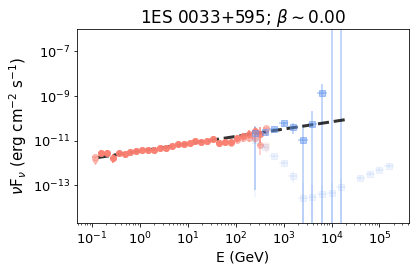

In [251]:
#def plec2_E2_100GeV(E, N0, gamma, Ec_inv, alpha):
#    return N0*(E/100.)**(-gamma)*np.exp( -(Ec_inv*np.array(E))**alpha )*E*E
#bounds=([1e-16,1,1e-5,0], [3.e-12, 5., 1e5,100])



_ = process_BB(f=None, 
              ff = "./4fgl_j0035.9+5950_sed.npy", 
              ED = "./BlazarLightCurves/Spectra_ABonly/1ES0033_spectralfit_fulldataset.dat", 
               EDcolor='cornflowerblue', EDmarker="s", EDalpha=0.5, z=0.33, 
                    ax =None, tag="BB{}".format(i), format_ax=True, 
               color="salmon", label="BB{}".format(i) , alpha=0.9, 
              save_csv=None, #"1ES1011_LAT_VER_SED_BB{}.csv".format(i), 
               outfile=None,) #'1ES1011_LAT_VER_SED_BB{}_observed.pdf'.format(i))
_.set_ylim(2e-15, 1e-6)
#_.legend()
plt.title(r"1ES 0033+595; $\beta\sim${:.2f}".format(0.00))
plt.tight_layout()

plt.savefig("1ES0033_LAT_VER_SED_avg_z0p33.pdf")
plt.show()

/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:377: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  subok=False, ndmin=ndmin)
No handles with labels found to put in legend.
No handles with labels found to put in legend.


28
Too few data points to fit plec
44


/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/matplotlib/axes/_axes.py:3322: RuntimeWarning: invalid value encountered in double_scalars
  low = [v - e for v, e in zip(data, a)]


best-fit param 0 = 1.775e-12 +/- 4.144e-13
best-fit param 1 = 1.395 +/- 0.02768
best-fit param 2 = 1e+06 +/- 4.613e-10
best-fit param 3 = 0.1065 +/- 0.001713
fit Chisq is 57.532, dof is 36, reduced Chisq is 1.60
Log likelihood lnL=-28.766219129014466


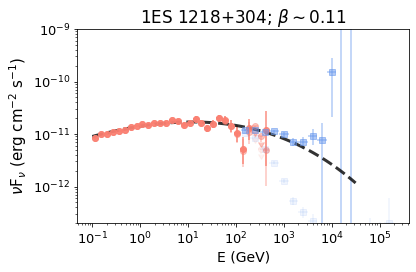

In [252]:
#def plec2_E2_100GeV(E, N0, gamma, Ec_inv, alpha):
#    return N0*(E/100.)**(-gamma)*np.exp( -(Ec_inv*np.array(E))**alpha )*E*E
#bounds=([1e-16,1,1e-5,0], [3.e-12, 5., 1e5,100])



_ = process_BB(f=None, 
              ff = "./GwenSED/4fgl_j1217.9+3007_sed.npy", 
              ED = "./BlazarLightCurves/Spectra_ABonly/1ES1218_spectralfit_fulldataset.dat", 
               EDcolor='cornflowerblue', EDmarker="s", EDalpha=0.5, z=0.182, 
                    ax =None, tag="BB{}".format(i), format_ax=True, 
               color="salmon", label="BB{}".format(i) , alpha=0.9, 
              save_csv=None, #"1ES1011_LAT_VER_SED_BB{}.csv".format(i), 
               outfile=None,) #'1ES1011_LAT_VER_SED_BB{}_observed.pdf'.format(i))
_.set_ylim(2e-13, 1e-9)
#_.legend()
plt.title(r"1ES 1218+304; $\beta\sim${:.2f}".format(0.11))
plt.tight_layout()

plt.savefig("1ES1218_LAT_VER_SED_avg_z0p182.pdf")
plt.show()

In [265]:
#LAT significance: 
#1959 
print(np.sqrt(26593.36))
#1218
#4FGL J1221.3+3010   PointSource    PowerLaw          0.000   5990.17      5624.7
print(np.sqrt(5990.17))

#4FGL J2347.0+5141   PointSource    LogParabola       0.000   3937.41      4270.3
print(np.sqrt(3937.41))

#4FGL J1015.0+4926   PointSource    LogParabola       0.000  27515.16     14428.2
print(np.sqrt(27515.16))

#print(np.sqrt())


163.07470680642047
77.39618853664565
62.74878484879209
165.876942339796


/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:377: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  subok=False, ndmin=ndmin)
No handles with labels found to put in legend.
No handles with labels found to put in legend.


30
Too few data points to fit plec
42


/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/matplotlib/axes/_axes.py:3322: RuntimeWarning: invalid value encountered in double_scalars
  low = [v - e for v, e in zip(data, a)]


best-fit param 0 = 3.984e-15 +/- 5.084e-17
best-fit param 1 = 1.749 +/- 6.478e-07
best-fit param 2 = 0.0009517 +/- 5.166e-05
best-fit param 3 = 0.4562 +/- 9.906e-08
fit Chisq is 175.005, dof is 37, reduced Chisq is 4.73
Log likelihood lnL=-87.50229481833696


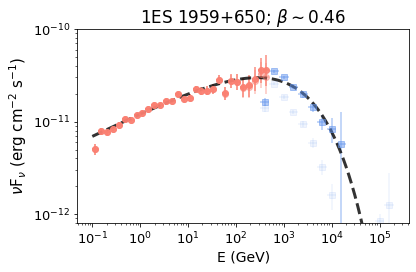

In [272]:
#def plec2_E2_100GeV(E, N0, gamma, Ec_inv, alpha):
#    return N0*(E/100.)**(-gamma)*np.exp( -(Ec_inv*np.array(E))**alpha )*E*E
#bounds=([1e-16,1,1e-5,0], [3.e-12, 5., 1e5,100])

                                                             
#def plec2_E2_100GeV(E, N0, gamma, Ec_inv, alpha):
#    return N0*(E/100.)**(-gamma)*np.exp( -(Ec_inv*np.array(E))**alpha )*E*E
#bounds=([1e-16,1,1e-5,0], [3.e-12, 5., 1e5,100])


_ = process_BB(f=None, 
              ff = "./GwenSED/4fgl_j2000.0+6508_sed.npy", 
              ED = "./BlazarLightCurves/Spectra_ABonly/1ES1959_spectralfit_fulldataset.dat", 
              EDcolor='cornflowerblue', EDmarker="s", EDalpha=0.5, z=0.048, 
                    ax =None, tag="BB{}".format(i), format_ax=True, 
               color="salmon", label="BB{}".format(i) , alpha=0.9, 
              save_csv=None, #"1ES1011_LAT_VER_SED_BB{}.csv".format(i), 
               outfile=None,
              # p0=[3e-14, 1.5, 1e3, 0.001, 1.5]
               p0=[3e-14, 1.5, 1e3,0.01], 
               bounds=([1e-16,1,1e-5,0], [3.e-11, 5., 1e6,100]), 
                       fit_func=plec2_E2_100GeV,
              ) #'1ES1011_LAT_VER_SED_BB{}_observed.pdf'.format(i))
_.set_ylim(8e-13, 1e-10)
#_.legend()
plt.title(r"1ES 1959+650; $\beta\sim${:.2f}".format(0.46))
plt.tight_layout()

plt.savefig("1ES1959_LAT_VER_SED_avg_plec_z0p048.pdf")
plt.show()

/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:377: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  subok=False, ndmin=ndmin)
No handles with labels found to put in legend.
No handles with labels found to put in legend.


30
Too few data points to fit plec
42


/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/matplotlib/axes/_axes.py:3322: RuntimeWarning: invalid value encountered in double_scalars
  low = [v - e for v, e in zip(data, a)]


MC best-fit param 0 = 3.984e-15 +/- 5.084e-17
MC best-fit param 1 = 1.749 +/- 6.478e-07
MC best-fit param 2 = 0.0009517 +/- 5.166e-05
MC best-fit param 3 = 0.4562 +/- 9.906e-08
MC fit Chisq is 175.005, dof is 37, reduced Chisq is 4.73
MC Log likelihood lnL=-87.50229481833696


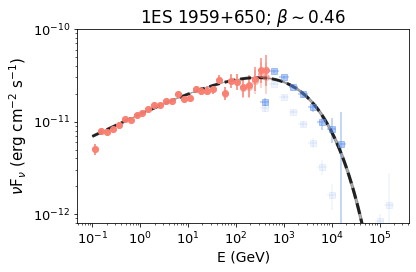

In [299]:
#def plec2_E2_100GeV(E, N0, gamma, Ec_inv, alpha):
#    return N0*(E/100.)**(-gamma)*np.exp( -(Ec_inv*np.array(E))**alpha )*E*E
#bounds=([1e-16,1,1e-5,0], [3.e-12, 5., 1e5,100])

                                                             
#def plec2_E2_100GeV(E, N0, gamma, Ec_inv, alpha):
#    return N0*(E/100.)**(-gamma)*np.exp( -(Ec_inv*np.array(E))**alpha )*E*E
#bounds=([1e-16,1,1e-5,0], [3.e-12, 5., 1e5,100])


_ = process_BB(f=None, 
              ff = "./GwenSED/4fgl_j2000.0+6508_sed.npy", 
              ED = "./BlazarLightCurves/Spectra_ABonly/1ES1959_spectralfit_fulldataset.dat", 
              EDcolor='cornflowerblue', EDmarker="s", EDalpha=0.5, z=0.048, 
                    ax =None, tag="BB{}".format(i), format_ax=True, 
               color="salmon", label="BB{}".format(i) , alpha=0.9, 
              save_csv=None, #"1ES1011_LAT_VER_SED_BB{}.csv".format(i), 
               outfile=None,
              # p0=[3e-14, 1.5, 1e3, 0.001, 1.5]
               p0=[3e-14, 1.5, 1e3,0.01], 
               bounds=([1e-16,1,1e-5,0], [3.e-11, 5., 1e6,100]), 
                       fit_func=plec2_E2_100GeV,
              ) #'1ES1011_LAT_VER_SED_BB{}_observed.pdf'.format(i))
_.set_ylim(8e-13, 1e-10)
#_.legend()
plt.title(r"1ES 1959+650; $\beta\sim${:.2f}".format(0.46))
plt.tight_layout()

plt.savefig("1ES1959_LAT_VER_SED_avg_plec_z0p048_v3.pdf")
plt.show()

/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:377: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  subok=False, ndmin=ndmin)
No handles with labels found to put in legend.
No handles with labels found to put in legend.


30
Too few data points to fit plec
42


/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/matplotlib/axes/_axes.py:3322: RuntimeWarning: invalid value encountered in double_scalars
  low = [v - e for v, e in zip(data, a)]


MC best-fit param 0 = 4.043e-15 +/- 5.996e-17
MC best-fit param 1 = 1.746 +/- 0.003677
MC best-fit param 2 = 0.4485 +/- 0.0003041
MC fit Chisq is 175.020, dof is 38, reduced Chisq is 4.61
MC Log likelihood lnL=-87.50997186916757


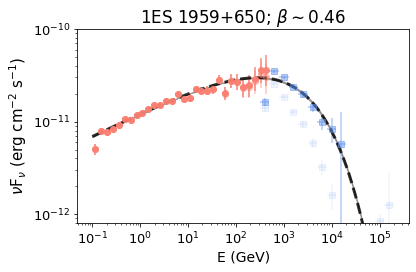

In [301]:
#def plec2_E2_100GeV(E, N0, gamma, Ec_inv, alpha):
#    return N0*(E/100.)**(-gamma)*np.exp( -(Ec_inv*np.array(E))**alpha )*E*E
#bounds=([1e-16,1,1e-5,0], [3.e-12, 5., 1e5,100])

                                                             
def plec2_E2_100GeV_cutoff1TeV(E, N0, gamma, alpha):
    return N0*(E/100.)**(-gamma)*np.exp( -(np.array(E)/1000.)**alpha )*E*E
bounds=([1e-16,1,0], [3.e-12, 5., 100])


_ = process_BB(f=None, 
              ff = "./GwenSED/4fgl_j2000.0+6508_sed.npy", 
              ED = "./BlazarLightCurves/Spectra_ABonly/1ES1959_spectralfit_fulldataset.dat", 
              EDcolor='cornflowerblue', EDmarker="s", EDalpha=0.5, z=0.048, 
                    ax =None, tag="BB{}".format(i), format_ax=True, 
               color="salmon", label="BB{}".format(i) , alpha=0.9, 
              save_csv=None, #"1ES1011_LAT_VER_SED_BB{}.csv".format(i), 
               outfile=None,
              # p0=[3e-14, 1.5, 1e3, 0.001, 1.5]
               p0=[3e-14, 1.5, 0.01], 
               bounds=([1e-16,1,0], [3.e-11, 5.,100]), 
               fit_func=plec2_E2_100GeV_cutoff1TeV,
              ) #'1ES1011_LAT_VER_SED_BB{}_observed.pdf'.format(i))
_.set_ylim(8e-13, 1e-10)
#_.legend()
plt.title(r"1ES 1959+650; $\beta\sim${:.2f}".format(0.46))
plt.tight_layout()

plt.savefig("1ES1959_LAT_VER_SED_avg_plec_cutoff1TeV_z0p048.pdf")
plt.show()

/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:377: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  subok=False, ndmin=ndmin)
No handles with labels found to put in legend.
No handles with labels found to put in legend.


30
Too few data points to fit plec
42


/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/matplotlib/axes/_axes.py:3322: RuntimeWarning: invalid value encountered in double_scalars
  low = [v - e for v, e in zip(data, a)]


MC best-fit param 0 = 4.043e-15 +/- 5.996e-17
MC best-fit param 1 = 1.746 +/- 0.003677
MC best-fit param 2 = 0.4485 +/- 0.0003041
MC fit Chisq is 175.020, dof is 38, reduced Chisq is 4.61
MC Log likelihood lnL=-87.50997186916757


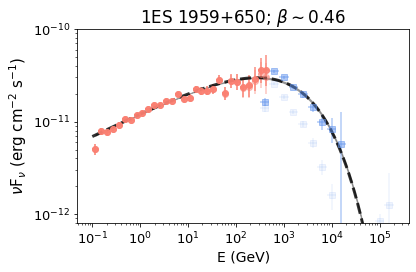

In [289]:
#def plec2_E2_100GeV(E, N0, gamma, Ec_inv, alpha):
#    return N0*(E/100.)**(-gamma)*np.exp( -(Ec_inv*np.array(E))**alpha )*E*E
#bounds=([1e-16,1,1e-5,0], [3.e-12, 5., 1e5,100])

                                                             
def plec2_E2_100GeV_cutoff1TeV(E, N0, gamma, alpha):
    return N0*(E/100.)**(-gamma)*np.exp( -(np.array(E)/1000.)**alpha )*E*E
bounds=([1e-16,1,0], [3.e-12, 5., 100])


_ = process_BB(f=None, 
              ff = "./GwenSED/4fgl_j2000.0+6508_sed.npy", 
              ED = "./BlazarLightCurves/Spectra_ABonly/1ES1959_spectralfit_fulldataset.dat", 
              EDcolor='cornflowerblue', EDmarker="s", EDalpha=0.5, z=0.048, 
                    ax =None, tag="BB{}".format(i), format_ax=True, 
               color="salmon", label="BB{}".format(i) , alpha=0.9, 
              save_csv=None, #"1ES1011_LAT_VER_SED_BB{}.csv".format(i), 
               outfile=None,
              # p0=[3e-14, 1.5, 1e3, 0.001, 1.5]
               p0=[3e-14, 1.5, 0.01], 
               bounds=([1e-16,1,0], [3.e-11, 5.,100]), 
               fit_func=plec2_E2_100GeV_cutoff1TeV,
              ) #'1ES1011_LAT_VER_SED_BB{}_observed.pdf'.format(i))
_.set_ylim(8e-13, 1e-10)
#_.legend()
plt.title(r"1ES 1959+650; $\beta\sim${:.2f}".format(0.46))
plt.tight_layout()

plt.savefig("1ES1959_LAT_VER_SED_avg_plec_cutoff1TeV_z0p048_v3.pdf")
plt.show()

/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:377: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  subok=False, ndmin=ndmin)
No handles with labels found to put in legend.
No handles with labels found to put in legend.


30
Too few data points to fit plec
42
MC best-fit param 0 = 2.542e-11 +/- 4.976e-13
MC best-fit param 1 = 0.03265 +/- 0.007975
MC best-fit param 2 = 0.0278 +/- 0.001471
MC fit Chisq is 232.676, dof is 38, reduced Chisq is 6.12
MC Log likelihood lnL=-116.33809618455867


/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/matplotlib/axes/_axes.py:3322: RuntimeWarning: invalid value encountered in double_scalars
  low = [v - e for v, e in zip(data, a)]


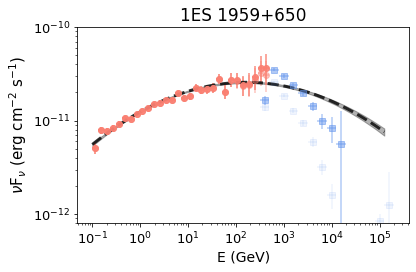

In [298]:
def log_para300GeV2(E, N0, alpha, beta):
    return N0*(E/300)**(-alpha-beta*np.log(np.array(E)/300))
p0=[3.2e-11, 2.6, 0.2]
bounds=([1e-19,-10,0], [3.e-8, 10., 100])
        
        
#def plec2_E2_100GeV(E, N0, gamma, Ec_inv, alpha):
#    return N0*(E/100.)**(-gamma)*np.exp( -(Ec_inv*np.array(E))**alpha )*E*E
#bounds=([1e-16,1,1e-5,0], [3.e-12, 5., 1e5,100])

                                                             
#def plec2_E2_100GeV_cutoff1TeV(E, N0, gamma, alpha):
#    return N0*(E/100.)**(-gamma)*np.exp( -(np.array(E)/1000.)**alpha )*E*E
#bounds=([1e-16,1,0], [3.e-12, 5., 100])


_ = process_BB(f=None, 
              ff = "./GwenSED/4fgl_j2000.0+6508_sed.npy", 
              ED = "./BlazarLightCurves/Spectra_ABonly/1ES1959_spectralfit_fulldataset.dat", 
              EDcolor='cornflowerblue', EDmarker="s", EDalpha=0.5, z=0.048, 
                    ax =None, tag="BB{}".format(i), format_ax=True, 
               color="salmon", label="BB{}".format(i) , alpha=0.9, 
              save_csv=None, #"1ES1011_LAT_VER_SED_BB{}.csv".format(i), 
               outfile=None,
              # p0=[3e-14, 1.5, 1e3, 0.001, 1.5]
               p0=p0, 
               bounds=bounds, 
               fit_func=log_para300GeV2,
              ) #'1ES1011_LAT_VER_SED_BB{}_observed.pdf'.format(i))
_.set_ylim(8e-13, 1e-10)
#_.legend()
plt.title(r"1ES 1959+650") #; $\beta\sim${:.2f}".format(0.46))
plt.tight_layout()

plt.savefig("1ES1959_LAT_VER_SED_avg_logpara_300GeV_z0p048_v3.pdf")
plt.show()


/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:377: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  subok=False, ndmin=ndmin)


28
40
MC best-fit param 0 = 2.549e-11 +/- 5.096e-13
MC best-fit param 1 = 0.03379 +/- 0.00821
MC best-fit param 2 = 0.02819 +/- 0.001579
MC fit Chisq is 227.444, dof is 36, reduced Chisq is 6.32
MC Log likelihood lnL=-113.72215581606656


/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/matplotlib/axes/_axes.py:3322: RuntimeWarning: invalid value encountered in double_scalars
  low = [v - e for v, e in zip(data, a)]
/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:377: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  subok=False, ndmin=ndmin)


28
40


/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/matplotlib/axes/_axes.py:3322: RuntimeWarning: invalid value encountered in double_scalars
  low = [v - e for v, e in zip(data, a)]


MC best-fit param 0 = 4.039e-15 +/- 4.426e-17
MC best-fit param 1 = 1.748 +/- 0.003771
MC best-fit param 2 = 0.4438 +/- 0.0003395
MC fit Chisq is 166.014, dof is 36, reduced Chisq is 4.61
MC Log likelihood lnL=-83.00689026901149


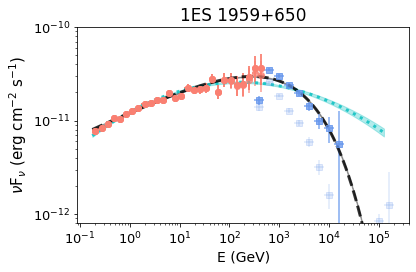

In [365]:
def log_para300GeV2(E, N0, alpha, beta):
    return N0*(E/300)**(-alpha-beta*np.log(np.array(E)/300))
p0=[3.2e-11, 2.6, 0.2]
bounds=([1e-19,-10,0], [3.e-8, 10., 100])
        
        
#def plec2_E2_100GeV(E, N0, gamma, Ec_inv, alpha):
#    return N0*(E/100.)**(-gamma)*np.exp( -(Ec_inv*np.array(E))**alpha )*E*E
#bounds=([1e-16,1,1e-5,0], [3.e-12, 5., 1e5,100])

                                                             
#def plec2_E2_100GeV_cutoff1TeV(E, N0, gamma, alpha):
#    return N0*(E/100.)**(-gamma)*np.exp( -(np.array(E)/1000.)**alpha )*E*E
#bounds=([1e-16,1,0], [3.e-12, 5., 100])


_ = process_BB(f=None, 
              ff = "./GwenSED/4fgl_j2000.0+6508_sed.npy", 
              ED = "./BlazarLightCurves/Spectra_ABonly/1ES1959_spectralfit_fulldataset.dat", 
              EDcolor='cornflowerblue', EDmarker="s", EDalpha=0.5, z=0.048, 
                    ax =None, tag="BB{}".format(i), format_ax=True, 
               color="salmon", label="BB{}".format(i) , alpha=0.9, 
              save_csv=None, #"1ES1011_LAT_VER_SED_BB{}.csv".format(i), 
               outfile=None,
              # p0=[3e-14, 1.5, 1e3, 0.001, 1.5]
               p0=p0, 
               bounds=bounds, 
               fit_func=log_para300GeV2, model_ls=":", model_color="c", 
              ) #'1ES1011_LAT_VER_SED_BB{}_observed.pdf'.format(i))

_ = process_BB(f=None, 
              ff = "./GwenSED/4fgl_j2000.0+6508_sed.npy", 
              ED = "./BlazarLightCurves/Spectra_ABonly/1ES1959_spectralfit_fulldataset.dat", 
              EDcolor='cornflowerblue', EDmarker="s", EDalpha=0.5, z=0.048, 
                    ax = _, tag="BB{}".format(i), format_ax=True, 
               color="salmon", label="BB{}".format(i) , alpha=0.9, 
              save_csv=None, #"1ES1011_LAT_VER_SED_BB{}.csv".format(i), 
               outfile=None,
              #p0=[3e-14, 1.5, 1e3, 0.001, 1.5]
               p0=[4e-15, 1.75, 0.44], 
               bounds=([0, -np.inf,0], [np.inf, np.inf,100]), 
               #bounds=([1e-16,1,0], [3.e-11, 5.,100]), 
               fit_func=plec2_E2_100GeV_cutoff1TeV,
              ) #'1ES1011_LAT_VER_SED_BB{}_observed.pdf'.format(i))


_.set_ylim(8e-13, 1e-10)
#_.legend()
plt.title(r"1ES 1959+650") #; $\beta\sim${:.2f}".format(0.46))
plt.tight_layout()

plt.savefig("1ES1959_LAT_VER_SED_avg_cutoff_vs_logpara_300GeV_z0p048_v4.pdf")
plt.show()


/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:377: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  subok=False, ndmin=ndmin)


28
37
MC best-fit param 0 = 2.549e-11 +/- 5.096e-13
MC best-fit param 1 = 0.0338 +/- 0.00821
MC best-fit param 2 = 0.02819 +/- 0.001579
MC fit Chisq is 177.522, dof is 34, reduced Chisq is 5.22
MC Log likelihood lnL=-88.761146477849


/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:377: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  subok=False, ndmin=ndmin)


28
37
MC best-fit param 0 = 4.039e-15 +/- 4.426e-17
MC best-fit param 1 = 1.748 +/- 0.003771
MC best-fit param 2 = 0.4438 +/- 0.0003395
MC fit Chisq is 116.029, dof is 34, reduced Chisq is 3.41
MC Log likelihood lnL=-58.01454513330379


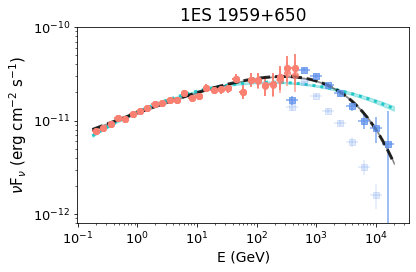

In [410]:
def log_para300GeV2(E, N0, alpha, beta):
    return N0*(E/300)**(-alpha-beta*np.log(np.array(E)/300))
p0=[3.2e-11, 0.5, 0.2]
bounds=([1e-19,0,0], [3.e-8, 10., 100])
        
        
#def plec2_E2_100GeV(E, N0, gamma, Ec_inv, alpha):
#    return N0*(E/100.)**(-gamma)*np.exp( -(Ec_inv*np.array(E))**alpha )*E*E
#bounds=([1e-16,1,1e-5,0], [3.e-12, 5., 1e5,100])

                                                             
#def plec2_E2_100GeV_cutoff1TeV(E, N0, gamma, alpha):
#    return N0*(E/100.)**(-gamma)*np.exp( -(np.array(E)/1000.)**alpha )*E*E
#bounds=([1e-16,1,0], [3.e-12, 5., 100])


_ = process_BB(f=None, 
              ff = "./GwenSED/4fgl_j2000.0+6508_sed.npy", 
              ED = "./BlazarLightCurves/Spectra_ABonly/1ES1959_spectralfit_fulldataset.dat", 
              EDcolor='cornflowerblue', EDmarker="s", EDalpha=0.5, z=0.048, 
                    ax =None, tag="BB{}".format(i), format_ax=True, 
               color="salmon", label="BB{}".format(i) , alpha=0.9, 
              save_csv=None, #"1ES1011_LAT_VER_SED_BB{}.csv".format(i), 
               outfile=None,
              # p0=[3e-14, 1.5, 1e3, 0.001, 1.5]
               p0=p0, 
               bounds=bounds, EDsigma=1, 
               fit_func=log_para300GeV2, model_ls=":", model_color="c", 
              ) #'1ES1011_LAT_VER_SED_BB{}_observed.pdf'.format(i))

_ = process_BB(f=None, 
              ff = "./GwenSED/4fgl_j2000.0+6508_sed.npy", 
              ED = "./BlazarLightCurves/Spectra_ABonly/1ES1959_spectralfit_fulldataset.dat", 
              EDcolor='cornflowerblue', EDmarker="s", EDalpha=0.5, z=0.048, 
                    ax = _, tag="BB{}".format(i), format_ax=True, 
               color="salmon", label="BB{}".format(i) , alpha=0.9, 
              save_csv=None, #"1ES1011_LAT_VER_SED_BB{}.csv".format(i), 
               outfile=None,
              #p0=[3e-14, 1.5, 1e3, 0.001, 1.5]
               p0=[4e-15, 1.75, 0.44], 
               bounds=([0, -np.inf,0], [np.inf, np.inf,100]), 
               #bounds=([1e-16,1,0], [3.e-11, 5.,100]), 
               fit_func=plec2_E2_100GeV_cutoff1TeV,EDsigma=1
              ) #'1ES1011_LAT_VER_SED_BB{}_observed.pdf'.format(i))


_.set_ylim(8e-13, 1e-10)
#_.legend()
plt.title(r"1ES 1959+650") #; $\beta\sim${:.2f}".format(0.46))
plt.tight_layout()

plt.savefig("1ES1959_LAT_VER_SED_avg_cutoff_vs_logpara_300GeV_z0p048_v6.pdf")
plt.show()


/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:377: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  subok=False, ndmin=ndmin)


28
40
MC best-fit param 0 = 2.549e-11 +/- 5.096e-13
MC best-fit param 1 = 0.03379 +/- 0.00821
MC best-fit param 2 = 0.02819 +/- 0.001579
MC fit Chisq is 227.444, dof is 36, reduced Chisq is 6.32
MC Log likelihood lnL=-113.72215581606656


/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/matplotlib/axes/_axes.py:3322: RuntimeWarning: invalid value encountered in double_scalars
  low = [v - e for v, e in zip(data, a)]
/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:377: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  subok=False, ndmin=ndmin)


28
40
Fitting in log space


/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/matplotlib/axes/_axes.py:3322: RuntimeWarning: invalid value encountered in double_scalars
  low = [v - e for v, e in zip(data, a)]


best-fit param 0 = 3.908e-13 +/- 9.753e-10
best-fit param 1 = 0.8335 +/- 0.06038
best-fit param 2 = 5.102 +/- 9.584
best-fit param 3 = 0.1806 +/- 0.0189
fit Chisq is 186706.926, dof is 35, reduced Chisq is 5334.48
Log likelihood lnL=-93353.46286910509


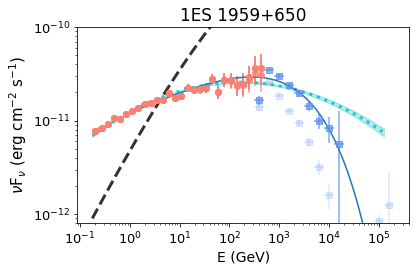

In [459]:
def log_para300GeV2(E, N0, alpha, beta):
    return N0*(E/300)**(-alpha-beta*np.log(np.array(E)/300))
p0=[3.2e-11, 2.6, 0.2]
bounds=([1e-19,-10,0], [3.e-8, 10., 100])
        
        
#def plec2_E2_100GeV(E, N0, gamma, Ec_inv, alpha):
#    return N0*(E/100.)**(-gamma)*np.exp( -(Ec_inv*np.array(E))**alpha )*E*E
#bounds=([1e-16,1,1e-5,0], [3.e-12, 5., 1e5,100])

                                                             
#def plec2_E2_100GeV_cutoff1TeV(E, N0, gamma, alpha):
#    return N0*(E/100.)**(-gamma)*np.exp( -(np.array(E)/1000.)**alpha )*E*E
#bounds=([1e-16,1,0], [3.e-12, 5., 100])


_ = process_BB(f=None, 
              ff = "./GwenSED/4fgl_j2000.0+6508_sed.npy", 
              ED = "./BlazarLightCurves/Spectra_ABonly/1ES1959_spectralfit_fulldataset.dat", 
              EDcolor='cornflowerblue', EDmarker="s", EDalpha=0.5, z=0.048, 
                    ax =None, tag="BB{}".format(i), format_ax=True, 
               color="salmon", label="BB{}".format(i) , alpha=0.9, 
              save_csv=None, #"1ES1011_LAT_VER_SED_BB{}.csv".format(i), 
               outfile=None,
              # p0=[3e-14, 1.5, 1e3, 0.001, 1.5]
               p0=p0, 
               bounds=bounds, 
               fit_func=log_para300GeV2, model_ls=":", model_color="c", 
              ) #'1ES1011_LAT_VER_SED_BB{}_observed.pdf'.format(i))

_ = process_BB(f=None, 
              ff = "./GwenSED/4fgl_j2000.0+6508_sed.npy", 
              ED = "./BlazarLightCurves/Spectra_ABonly/1ES1959_spectralfit_fulldataset.dat", 
              EDcolor='cornflowerblue', EDmarker="s", EDalpha=0.5, z=0.048, 
                    ax = _, tag="BB{}".format(i), format_ax=True, 
               color="salmon", label="BB{}".format(i) , alpha=0.9, 
              save_csv=None, #"1ES1011_LAT_VER_SED_BB{}.csv".format(i), 
               outfile=None,
               p0=[4e-15, 1.75, 0.001, 0.44],
               #p0=[4e-15, 1.75, 0.44], 
               bounds=([0, 0, 1e-5, 0], [np.inf, 10, 1e5, 100]), 
               #bounds=([1e-16,1,0], [3.e-11, 5.,100]), 
               fit_func=log_plec2_100GeV,
              ) #'1ES1011_LAT_VER_SED_BB{}_observed.pdf'.format(i))

#log_plec2_100GeV(logE, N0, gamma, Ec_inv, alpha)
logE = np.linspace(0.1,5,100)
plt.plot(10**logE, 10**log_plec2_100GeV(logE, 4e-15, 1.75, 0.001, 0.44))
_.set_ylim(8e-13, 1e-10)
#_.legend()
plt.title(r"1ES 1959+650") #; $\beta\sim${:.2f}".format(0.46))
plt.tight_layout()

#plt.savefig("1ES1959_LAT_VER_SED_avg_cutoff_vs_logpara_300GeV_z0p048_v5.pdf")
plt.show()


In [1]:
#def plec2_E2_100GeV(E, N0, gamma, Ec_inv, alpha):
#    return N0*(E/100.)**(-gamma)*np.exp( -(Ec_inv*np.array(E))**alpha )*E*E
#bounds=([1e-16,1,1e-5,0], [3.e-12, 5., 1e5,100])


def log_para300GeV2(E, N0, alpha, beta):
    return N0*(E/300)**(-alpha-beta*np.log(np.array(E)/300))
p0=[3.2e-11, 2.6, 0.2]
bounds=([1e-19,-10,0], [3.e-8, 10., 100])


_ = process_BB(f=None, 
              ff = "./GwenSED/4fgl_j1217.9+3007_sed.npy", 
              ED = "./BlazarLightCurves/Spectra_ABonly/1ES1218_spectralfit_fulldataset.dat", 
              EDcolor='cornflowerblue', EDmarker="s", EDalpha=0.5, z=0.182, 
                    ax =None, tag="BB{}".format(i), format_ax=True, 
               color="salmon", label="BB{}".format(i) , alpha=0.9, 
              save_csv=None, #"1ES1011_LAT_VER_SED_BB{}.csv".format(i), 
               outfile=None,
              # p0=[3e-14, 1.5, 1e3, 0.001, 1.5]
               p0=p0, 
               bounds=bounds, 
               fit_func=log_para300GeV2, model_ls=":", model_color="c", 
              ) #'1ES1011_LAT_VER_SED_BB{}_observed.pdf'.format(i))

_ = process_BB(f=None, 
              ff = "./GwenSED/4fgl_j1217.9+3007_sed.npy", 
              ED = "./BlazarLightCurves/Spectra_ABonly/1ES1218_spectralfit_fulldataset.dat", 
               EDcolor='cornflowerblue', EDmarker="s", EDalpha=0.5, z=0.182, 
                    ax =_, tag="BB{}".format(i), format_ax=True, 
               color="salmon", label="BB{}".format(i) , alpha=0.9, 
               bounds=([1e-16,1,1e-5,0], [3.e-12, 5., 1e8,100]),
              save_csv=None, #"1ES1011_LAT_VER_SED_BB{}.csv".format(i), 
               outfile=None,) #'1ES1011_LAT_VER_SED_BB{}_observed.pdf'.format(i))
_.set_ylim(2e-13, 1e-9)
#_.legend()
plt.title(r"1ES 1218+304")#; $\beta\sim${:.2f}".format(0.11))
plt.tight_layout()

plt.savefig("1ES1218_LAT_VER_SED_avg_z0p182_plec_lp_v4.pdf")
plt.show()

SyntaxError: invalid syntax (<ipython-input-1-2658a64c6de0>, line 12)

/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:377: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  subok=False, ndmin=ndmin)


26
36
MC best-fit param 0 = 1.164e-11 +/- 2.156e-13
MC best-fit param 1 = 0.2187 +/- 0.01375
MC best-fit param 2 = 0.03213 +/- 0.002119
MC fit Chisq is 44.258, dof is 33, reduced Chisq is 1.34
MC Log likelihood lnL=-22.12908765141764


/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:377: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  subok=False, ndmin=ndmin)


26
36
MC best-fit param 0 = 3e-12 +/- 8.645e-13
MC best-fit param 1 = 1.382 +/- 0.0328
MC best-fit param 2 = 6.481e+06 +/- 8.105e-11
MC best-fit param 3 = 0.1002 +/- 0.001792
MC fit Chisq is 54.380, dof is 32, reduced Chisq is 1.70
MC Log likelihood lnL=-27.189924032693206


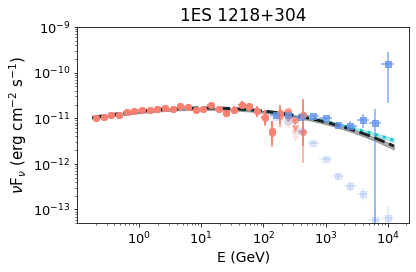

In [402]:
#def plec2_E2_100GeV(E, N0, gamma, Ec_inv, alpha):
#    return N0*(E/100.)**(-gamma)*np.exp( -(Ec_inv*np.array(E))**alpha )*E*E
#bounds=([1e-16,1,1e-5,0], [3.e-12, 5., 1e5,100])


def log_para300GeV2(E, N0, alpha, beta):
    return N0*(E/300)**(-alpha-beta*np.log(np.array(E)/300))
p0=[3.2e-11, 2.6, 0.2]
bounds=([1e-19,-10,0], [3.e-8, 10., 100])


_ = process_BB(f=None, 
              ff = "./GwenSED/4fgl_j1217.9+3007_sed.npy", 
              ED = "./BlazarLightCurves/Spectra_ABonly/1ES1218_spectralfit_fulldataset.dat", 
              EDcolor='cornflowerblue', EDmarker="s", EDalpha=0.5, z=0.182, 
                    ax =None, tag="BB{}".format(i), format_ax=True, 
               color="salmon", label="BB{}".format(i) , alpha=0.9, 
              save_csv=None, #"1ES1011_LAT_VER_SED_BB{}.csv".format(i), 
               outfile=None,EDsigma=1, 
              # p0=[3e-14, 1.5, 1e3, 0.001, 1.5]
               p0=p0, 
               bounds=bounds, 
               fit_func=log_para300GeV2, model_ls=":", model_color="c", 
              ) #'1ES1011_LAT_VER_SED_BB{}_observed.pdf'.format(i))

_ = process_BB(f=None, 
              ff = "./GwenSED/4fgl_j1217.9+3007_sed.npy", 
              ED = "./BlazarLightCurves/Spectra_ABonly/1ES1218_spectralfit_fulldataset.dat", 
               EDcolor='cornflowerblue', EDmarker="s", EDalpha=0.5, z=0.182, 
                    ax =_, tag="BB{}".format(i), format_ax=True, 
               color="salmon", label="BB{}".format(i) , alpha=0.9, 
               bounds=([1e-16,1,1e-5,0], [3.e-12, 5., 1e8,100]),
               EDsigma=1, 
              save_csv=None, #"1ES1011_LAT_VER_SED_BB{}.csv".format(i), 
               outfile=None,) #'1ES1011_LAT_VER_SED_BB{}_observed.pdf'.format(i))
_.set_ylim(5e-14, 1e-9)
#_.legend()
plt.title(r"1ES 1218+304")#; $\beta\sim${:.2f}".format(0.11))
plt.tight_layout()

plt.savefig("1ES1218_LAT_VER_SED_avg_z0p182_plec_lp_v6.pdf")
plt.show()

/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:377: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  subok=False, ndmin=ndmin)



36
Too few data points to fit plec
25
Too few data points to fit plec
37
best-fit param 0 = 7.75e-16 +/- 2.138e-17
best-fit param 1 = 1.837 +/- 1.635e-07
best-fit param 2 = 0.000431 +/- 3.957e-05
best-fit param 3 = 0.7367 +/- 5.171e-09
fit Chisq is 103.251, dof is 33, reduced Chisq is 3.13
Log likelihood lnL=-51.62527376496179


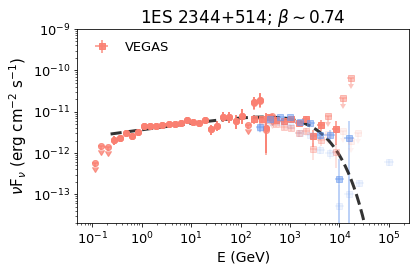

In [261]:


_ = process_BB(f="1ES2344_VEGAS_spec.txt", 
              ff = "./GwenSED/4fgl_j2347.0+5141_sed.npy", 
              ED = "./BlazarLightCurves/Spectra_ABonly/1ES2344_spectralfit_fulldataset.dat", 
               EDcolor='cornflowerblue', EDmarker="s", EDalpha=0.5, z=0.044, 
                    ax =None, tag="VEGAS", format_ax=True, 
               color="salmon", label="VEGAS" , alpha=0.9, 
              save_csv=None, #"1ES1011_LAT_VER_SED_BB{}.csv".format(i), 
               outfile=None,) #'1ES1011_LAT_VER_SED_BB{}_observed.pdf'.format(i))
_.set_ylim(2e-14, 1e-9)
#plt.title(r"1ES 2344+514; $\beta$={:.2f}$\pm${:.2f}".format(0.74))
plt.title(r"1ES 2344+514; $\beta\sim${:.2f}".format(0.74))
#_.legend()
plt.tight_layout()

plt.savefig("1ES2344_LAT_VER_ED_VEGAS_SED_avg_z0p044.pdf")
plt.show()

/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:377: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  subok=False, ndmin=ndmin)


25
Too few data points to fit plec
37
MC best-fit param 0 = 6.675e-12 +/- 2.462e-13
MC best-fit param 1 = 0.1189 +/- 0.01607
MC best-fit param 2 = 0.04058 +/- 0.003568
MC fit Chisq is 136.348, dof is 34, reduced Chisq is 4.01
MC Log likelihood lnL=-68.17415037960659


/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:377: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  subok=False, ndmin=ndmin)


25
Too few data points to fit plec
37
MC best-fit param 0 = 7.75e-16 +/- 2.138e-17
MC best-fit param 1 = 1.837 +/- 1.635e-07
MC best-fit param 2 = 0.000431 +/- 3.957e-05
MC best-fit param 3 = 0.7367 +/- 5.171e-09
MC fit Chisq is 103.251, dof is 33, reduced Chisq is 3.13
MC Log likelihood lnL=-51.62527376496179


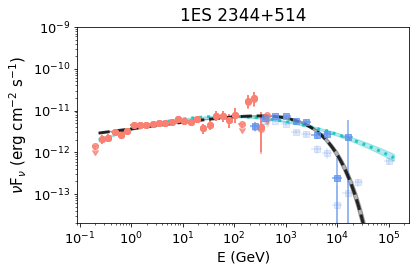

In [335]:

def log_para300GeV2(E, N0, alpha, beta):
    return N0*(E/300)**(-alpha-beta*np.log(np.array(E)/300))
p0=[3.2e-11, 2.6, 0.2]
bounds=([1e-19,-10,0], [3.e-8, 10., 100])


_ = process_BB(f=None, 
              ff = "./GwenSED/4fgl_j2347.0+5141_sed.npy", 
              ED = "./BlazarLightCurves/Spectra_ABonly/1ES2344_spectralfit_fulldataset.dat", 
              EDcolor='cornflowerblue', EDmarker="s", EDalpha=0.5, z=0.044, 
                    ax =None, tag="BB{}".format(i), format_ax=True, 
               color="salmon", label="BB{}".format(i) , alpha=0.9, 
              save_csv=None, #"1ES1011_LAT_VER_SED_BB{}.csv".format(i), 
               outfile=None,
              # p0=[3e-14, 1.5, 1e3, 0.001, 1.5]
               p0=p0, 
               bounds=bounds, 
               fit_func=log_para300GeV2, model_ls=":", model_color="c", 
              ) #'1ES1011_LAT_VER_SED_BB{}_observed.pdf'.format(i))


_ = process_BB(f=None, #"1ES2344_VEGAS_spec.txt", 
              ff = "./GwenSED/4fgl_j2347.0+5141_sed.npy", 
              ED = "./BlazarLightCurves/Spectra_ABonly/1ES2344_spectralfit_fulldataset.dat", 
               EDcolor='cornflowerblue', EDmarker="s", EDalpha=0.5, z=0.044, 
                    ax =_, tag="VEGAS", format_ax=True, 
               color="salmon", label="VEGAS" , alpha=0.9, 
              save_csv=None, #"1ES1011_LAT_VER_SED_BB{}.csv".format(i), 
               outfile=None,) #'1ES1011_LAT_VER_SED_BB{}_observed.pdf'.format(i))
_.set_ylim(2e-14, 1e-9)
#plt.title(r"1ES 2344+514; $\beta$={:.2f}$\pm${:.2f}".format(0.74))
plt.title(r"1ES 2344+514")#; $\beta\sim${:.2f}".format(0.74))
#_.legend()
plt.tight_layout()

plt.savefig("1ES2344_LAT_VER_ED_VEGAS_SED_avg_z0p044_plec_lp_v3.pdf")
plt.show()

In [2]:
import naima
from naima.models import ExponentialCutoffPowerLaw, InverseCompton
import astropy.units as u

def model(pars, data):
    amplitude = pars[0] / u.eV
    alpha = pars[1]
    e_cutoff = (10**pars[2]) * u.TeV

    ECPL = ExponentialCutoffPowerLaw(amplitude, 10*u.TeV, alpha, e_cutoff)
    IC = InverseCompton(ECPL, seed_photon_fields=['CMB',
                        ['FIR', 26.5 * u.K, 0.415 * u.eV / u.cm**3]])

    return IC.flux(data, distance=1.0*u.kpc)

from naima import uniform_prior

def lnprior(pars):
    lnprior = uniform_prior(pars[0], 0., np.inf) \
            + uniform_prior(pars[1], -1, 5)
    return lnprior


from naima.models import ExponentialCutoffPowerLaw, InverseCompton
import astropy.units as u
import numpy as np

def model_function(pars, data):
    amplitude = pars[0] * (1 / u.eV)
    alpha = pars[1]
    e_cutoff = (10**pars[2]) * u.TeV
    e_0 = 10 * u.TeV

    ECPL = ExponentialCutoffPowerLaw(amplitude, e_0, alpha, e_cutoff)
    IC = InverseCompton(ECPL, seed_photon_fields=['CMB',
                        ['FIR', 26.5 * u.K, 0.415 * u.eV / u.cm**3]])

    # The total enegy in electrons of model IC can be accessed through the
    # attribute We or obtained for a given range with compute_We
    We = IC.compute_We(Eemin = 1*u.TeV)

    # We can also save the particle distribution between 100 MeV and 100 TeV
    electron_e = np.logspace(11, 15, 100) * u.eV
    electron_dist = ECPL(electron_e)

    # The first object returned must be the model photon spectrum, and
    # subsequent objects will be stored as metadata blobs
    return IC(data), (electron_e, electron_dist), We


from astropy.io import ascii
data = ascii.read('RXJ1713_HESS_2007.dat')

p0 = np.array((1e33, 3.0, np.log10(30)))
labels = ['norm', 'index', 'log10(cutoff)']


imf = InteractiveModelFitter(model, p0, data=data, labels=labels)
# interactive fitting done
p0 = imf.pars


sampler, pos = naima.run_sampler(data_table = data, p0=p0, label=labels,
                model=model_function, prior=lnprior,
                nwalkers=128, nburn=50, nrun=10, threads=4)

NameError: name 'InteractiveModelFitter' is not defined

In [425]:
print(naima.__version__)

0.9.1


/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:377: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  subok=False, ndmin=ndmin)


25
33
MC best-fit param 0 = 6.73e-12 +/- 2.438e-13
MC best-fit param 1 = 0.07715 +/- 0.01707
MC best-fit param 2 = 0.03298 +/- 0.003739
MC fit Chisq is 55.630, dof is 30, reduced Chisq is 1.85
MC Log likelihood lnL=-27.8152278232299


/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:377: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  subok=False, ndmin=ndmin)


25
33
MC best-fit param 0 = 1.095e-15 +/- 3.434e-17
MC best-fit param 1 = 1.772 +/- 1.985e-06
MC best-fit param 2 = 0.001199 +/- 0.0001284
MC best-fit param 3 = 0.4184 +/- 4.512e-07
MC fit Chisq is 49.011, dof is 29, reduced Chisq is 1.69
MC Log likelihood lnL=-24.505387393702176


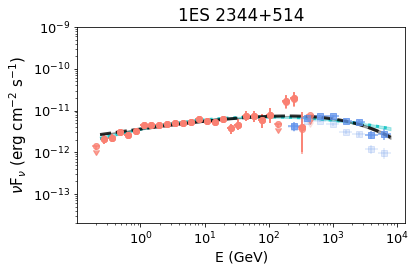

In [411]:

def log_para300GeV2(E, N0, alpha, beta):
    return N0*(E/300)**(-alpha-beta*np.log(np.array(E)/300))
p0=[3.2e-11, 2.6, 0.2]
bounds=([1e-19,-10,0], [3.e-8, 10., 100])


_ = process_BB(f=None, 
              ff = "./GwenSED/4fgl_j2347.0+5141_sed.npy", 
              ED = "./BlazarLightCurves/Spectra_ABonly/1ES2344_spectralfit_fulldataset.dat", 
              EDcolor='cornflowerblue', EDmarker="s", EDalpha=0.5, z=0.044, 
                    ax =None, tag="BB{}".format(i), format_ax=True, 
               color="salmon", label="BB{}".format(i) , alpha=0.9, 
              save_csv=None, #"1ES1011_LAT_VER_SED_BB{}.csv".format(i), 
               outfile=None,
              # p0=[3e-14, 1.5, 1e3, 0.001, 1.5]
               p0=p0, 
               bounds=bounds, EDsigma=1,
               fit_func=log_para300GeV2, model_ls=":", model_color="c", 
              ) #'1ES1011_LAT_VER_SED_BB{}_observed.pdf'.format(i))


_ = process_BB(f=None, #"1ES2344_VEGAS_spec.txt", 
              ff = "./GwenSED/4fgl_j2347.0+5141_sed.npy", 
              ED = "./BlazarLightCurves/Spectra_ABonly/1ES2344_spectralfit_fulldataset.dat", 
               EDcolor='cornflowerblue', EDmarker="s", EDalpha=0.5, z=0.044, 
                    ax =_, tag="VEGAS", format_ax=True, 
               color="salmon", label="VEGAS" , alpha=0.9, EDsigma=1,
              save_csv=None, #"1ES1011_LAT_VER_SED_BB{}.csv".format(i), 
               outfile=None,) #'1ES1011_LAT_VER_SED_BB{}_observed.pdf'.format(i))
_.set_ylim(2e-14, 1e-9)
#plt.title(r"1ES 2344+514; $\beta$={:.2f}$\pm${:.2f}".format(0.74))
plt.title(r"1ES 2344+514")#; $\beta\sim${:.2f}".format(0.74))
#_.legend()
plt.tight_layout()

plt.savefig("1ES2344_LAT_VER_ED_VEGAS_SED_avg_z0p044_plec_lp_v3_2.pdf")
plt.show()

/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:377: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  subok=False, ndmin=ndmin)


25
33
MC best-fit param 0 = 6.73e-12 +/- 2.438e-13
MC best-fit param 1 = 0.07715 +/- 0.01707
MC best-fit param 2 = 0.03298 +/- 0.003739
MC fit Chisq is 55.630, dof is 30, reduced Chisq is 1.85
MC Log likelihood lnL=-27.8152278232299


/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:377: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  subok=False, ndmin=ndmin)


25
33
MC best-fit param 0 = 1.095e-15 +/- 2.546e-17
MC best-fit param 1 = 1.772 +/- 0
MC best-fit param 2 = 0.4184 +/- 0
MC fit Chisq is 49.011, dof is 30, reduced Chisq is 1.63
MC Log likelihood lnL=-24.505387409244335


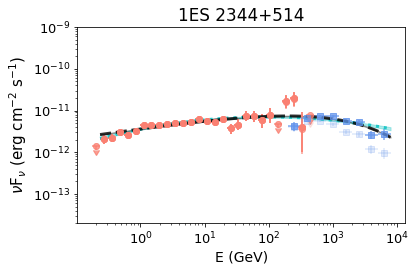

In [414]:

def log_para300GeV2(E, N0, alpha, beta):
    return N0*(E/300)**(-alpha-beta*np.log(np.array(E)/300))
p0=[3.2e-11, 2.6, 0.2]
bounds=([1e-19,-10,0], [3.e-8, 10., 100])


_ = process_BB(f=None, 
              ff = "./GwenSED/4fgl_j2347.0+5141_sed.npy", 
              ED = "./BlazarLightCurves/Spectra_ABonly/1ES2344_spectralfit_fulldataset.dat", 
              EDcolor='cornflowerblue', EDmarker="s", EDalpha=0.5, z=0.044, 
                    ax =None, tag="BB{}".format(i), format_ax=True, 
               color="salmon", label="BB{}".format(i) , alpha=0.9, 
              save_csv=None, #"1ES1011_LAT_VER_SED_BB{}.csv".format(i), 
               outfile=None,
              # p0=[3e-14, 1.5, 1e3, 0.001, 1.5]
               p0=p0, 
               bounds=bounds, EDsigma=1, 
               fit_func=log_para300GeV2, model_ls=":", model_color="c", 
              ) #'1ES1011_LAT_VER_SED_BB{}_observed.pdf'.format(i))


def plec2_E2_100GeV_cutoff2320GeV(E, N0, gamma, alpha):
    return N0*(E/100.)**(-gamma)*np.exp( -(np.array(E)/2320.)**alpha )*E*E
p0=[3.2e-16, 1.8, 0.7]
bounds=([1e-16,1,0], [3.e-12, 5., 100])

#0.001199 -> 834GeV

def plec2_E2_100GeV_cutoff834GeV(E, N0, gamma, alpha):
    return N0*(E/100.)**(-gamma)*np.exp( -(np.array(E)/834)**alpha )*E*E
p0=[3.2e-16, 1.8, 0.7]
bounds=([1e-16,1,0], [3.e-12, 5., 100])


_ = process_BB(f=None, #"1ES2344_VEGAS_spec.txt", 
              ff = "./GwenSED/4fgl_j2347.0+5141_sed.npy", 
              ED = "./BlazarLightCurves/Spectra_ABonly/1ES2344_spectralfit_fulldataset.dat", 
               EDcolor='cornflowerblue', EDmarker="s", EDalpha=0.5, z=0.044, 
                    ax =_, tag="VEGAS", format_ax=True, 
               color="salmon", label="VEGAS" , alpha=0.9, 
               p0=p0, EDsigma=1, 
               bounds=bounds, 
               fit_func=plec2_E2_100GeV_cutoff834GeV, 
              save_csv=None, #"1ES1011_LAT_VER_SED_BB{}.csv".format(i), 
               outfile=None,) #'1ES1011_LAT_VER_SED_BB{}_observed.pdf'.format(i))
_.set_ylim(2e-14, 1e-9)
#plt.title(r"1ES 2344+514; $\beta$={:.2f}$\pm${:.2f}".format(0.74))
plt.title(r"1ES 2344+514")#; $\beta\sim${:.2f}".format(0.74))
#_.legend()
plt.tight_layout()

plt.savefig("1ES2344_LAT_VER_ED_VEGAS_SED_avg_z0p044_plec_lp_v6_2.pdf")
plt.show()


/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:377: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  subok=False, ndmin=ndmin)


25
33
MC best-fit param 0 = 6.73e-12 +/- 2.438e-13
MC best-fit param 1 = 0.07715 +/- 0.01707
MC best-fit param 2 = 0.03298 +/- 0.003739
MC fit Chisq is 55.630, dof is 30, reduced Chisq is 1.85
MC Log likelihood lnL=-27.8152278232299


/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:377: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  subok=False, ndmin=ndmin)


25
33
MC best-fit param 0 = 7.955e-16 +/- 1.85e-17
MC best-fit param 1 = 1.832 +/- 0
MC best-fit param 2 = 0.6399 +/- 0
MC fit Chisq is 50.221, dof is 30, reduced Chisq is 1.67
MC Log likelihood lnL=-25.1105812346492


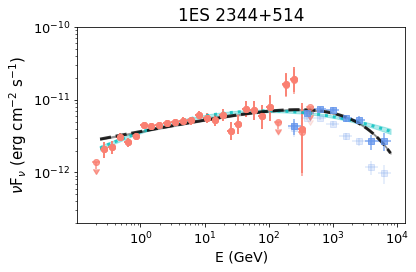

In [415]:

def log_para300GeV2(E, N0, alpha, beta):
    return N0*(E/300)**(-alpha-beta*np.log(np.array(E)/300))
p0=[3.2e-11, 2.6, 0.2]
bounds=([1e-19,-10,0], [3.e-8, 10., 100])


_ = process_BB(f=None, 
              ff = "./GwenSED/4fgl_j2347.0+5141_sed.npy", 
              ED = "./BlazarLightCurves/Spectra_ABonly/1ES2344_spectralfit_fulldataset.dat", 
              EDcolor='cornflowerblue', EDmarker="s", EDalpha=0.5, z=0.044, 
                    ax =None, tag="BB{}".format(i), format_ax=True, 
               color="salmon", label="BB{}".format(i) , alpha=0.9, 
              save_csv=None, #"1ES1011_LAT_VER_SED_BB{}.csv".format(i), 
               outfile=None,
              # p0=[3e-14, 1.5, 1e3, 0.001, 1.5]
               p0=p0, 
               bounds=bounds, EDsigma=1,
               fit_func=log_para300GeV2, model_ls=":", model_color="c", 
              ) #'1ES1011_LAT_VER_SED_BB{}_observed.pdf'.format(i))


def plec2_E2_100GeV_cutoff2320GeV(E, N0, gamma, alpha):
    return N0*(E/100.)**(-gamma)*np.exp( -(np.array(E)/2320.)**alpha )*E*E
p0=[3.2e-16, 1.8, 0.7]
bounds=([1e-16,1,0], [3.e-12, 5., 100])


_ = process_BB(f=None, #"1ES2344_VEGAS_spec.txt", 
              ff = "./GwenSED/4fgl_j2347.0+5141_sed.npy", 
              ED = "./BlazarLightCurves/Spectra_ABonly/1ES2344_spectralfit_fulldataset.dat", 
               EDcolor='cornflowerblue', EDmarker="s", EDalpha=0.5, z=0.044, 
                    ax =_, tag="VEGAS", format_ax=True, 
               color="salmon", label="VEGAS" , alpha=0.9, 
               p0=p0, 
               bounds=bounds, EDsigma=1,
               fit_func=plec2_E2_100GeV_cutoff2320GeV, 
              save_csv=None, #"1ES1011_LAT_VER_SED_BB{}.csv".format(i), 
               outfile=None,) #'1ES1011_LAT_VER_SED_BB{}_observed.pdf'.format(i))
_.set_ylim(2e-13, 1e-10)
#plt.title(r"1ES 2344+514; $\beta$={:.2f}$\pm${:.2f}".format(0.74))
plt.title(r"1ES 2344+514")#; $\beta\sim${:.2f}".format(0.74))
#_.legend()
plt.tight_layout()

plt.savefig("1ES2344_LAT_VER_ED_VEGAS_SED_avg_z0p044_plec_lp_v6.pdf")
plt.show()


/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:377: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  subok=False, ndmin=ndmin)


27
37
MC best-fit param 0 = 2.317e-11 +/- 7.483e-13
MC best-fit param 1 = -0.05065 +/- 0.01741
MC best-fit param 2 = 0.01537 +/- 0.002404
MC fit Chisq is 88.666, dof is 33, reduced Chisq is 2.69
MC Log likelihood lnL=-44.33290789609226


/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/matplotlib/axes/_axes.py:3322: RuntimeWarning: invalid value encountered in double_scalars
  low = [v - e for v, e in zip(data, a)]
/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:377: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  subok=False, ndmin=ndmin)


27
37


/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/matplotlib/axes/_axes.py:3322: RuntimeWarning: invalid value encountered in double_scalars
  low = [v - e for v, e in zip(data, a)]


MC best-fit param 0 = 2.713e-13 +/- 1.009e-13
MC best-fit param 1 = 1.501 +/- 0.0402
MC best-fit param 2 = 1e+06 +/- 3.371e-10
MC best-fit param 3 = 0.08547 +/- 0.004125
MC fit Chisq is 91.466, dof is 32, reduced Chisq is 2.86
MC Log likelihood lnL=-45.732970127437866


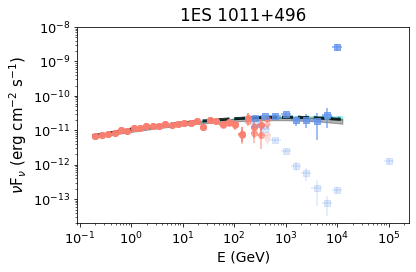

In [383]:
#def plec2_E2_100GeV(E, N0, gamma, Ec_inv, alpha):
#    return N0*(E/100.)**(-gamma)*np.exp( -(Ec_inv*np.array(E))**alpha )*E*E
#bounds=([1e-16,1,1e-5,0], [3.e-12, 5., 1e5,100])

def log_para300GeV2(E, N0, alpha, beta):
    return N0*(E/300)**(-alpha-beta*np.log(np.array(E)/300))
p0=[3.2e-11, 2.6, 0.2]
bounds=([1e-19,-10,0], [3.e-8, 10., 100])


_ = process_BB(f=None, 
              ff = "./GwenSED/4fgl_j1015.0+4926_sed.npy", 
              ED = "./BlazarLightCurves/Spectra_ABonly/1ES1011_spectralfit_fulldataset.dat", 
               EDcolor='cornflowerblue', EDmarker="s", EDalpha=0.5, z=0.212, 
                    ax =None, tag="BB{}".format(i), format_ax=True, 
               color="salmon", label="BB{}".format(i) , alpha=0.9, 
              save_csv=None, #"1ES1011_LAT_VER_SED_BB{}.csv".format(i), 
               outfile=None,
              # p0=[3e-14, 1.5, 1e3, 0.001, 1.5]
               p0=p0, 
               bounds=bounds, 
               fit_func=log_para300GeV2, model_ls=":", model_color="c", 
              ) #'1ES1011_LAT_VER_SED_BB{}_observed.pdf'.format(i))

_ = process_BB(f=None, 
              ff = "./GwenSED/4fgl_j1015.0+4926_sed.npy", 
              ED = "./BlazarLightCurves/Spectra_ABonly/1ES1011_spectralfit_fulldataset.dat", 
               EDcolor='cornflowerblue', EDmarker="s", EDalpha=0.5, z=0.212, 
                    ax =_, tag="BB{}".format(i), format_ax=True, 
               color="salmon", label="BB{}".format(i) , alpha=0.5, 
              save_csv="1ES1011_LAT_VER_ED_SED.csv", #"1ES1011_LAT_VER_SED_BB{}.csv".format(i), 
               outfile=None,) #'1ES1011_LAT_VER_SED_BB{}_observed.pdf'.format(i))
_.set_ylim(2e-14, 1e-8)
#_.legend()
plt.title(r"1ES 1011+496")#; $\beta\sim${:.2f}".format(0.09))
plt.tight_layout()
plt.savefig("1ES1011_LAT_VER_SED_avg_z0p212_plec_lp_v4.pdf")
plt.show()

/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:377: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  subok=False, ndmin=ndmin)


27
34
MC best-fit param 0 = 2.313e-11 +/- 7.533e-13
MC best-fit param 1 = -0.04954 +/- 0.01761
MC best-fit param 2 = 0.01551 +/- 0.002425
MC fit Chisq is 64.031, dof is 31, reduced Chisq is 2.07
MC Log likelihood lnL=-32.01536463319036


/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:377: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  subok=False, ndmin=ndmin)


27
34
MC best-fit param 0 = 2.79e-13 +/- 1.044e-13
MC best-fit param 1 = 1.498 +/- 0.04049
MC best-fit param 2 = 1e+06 +/- 3.427e-10
MC best-fit param 3 = 0.08579 +/- 0.00413
MC fit Chisq is 66.740, dof is 30, reduced Chisq is 2.22
MC Log likelihood lnL=-33.369906733492705


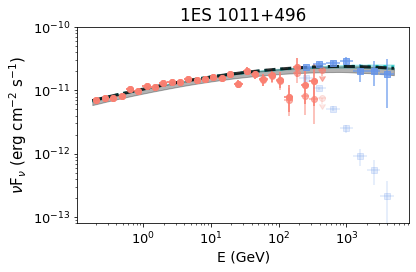

In [398]:
#def plec2_E2_100GeV(E, N0, gamma, Ec_inv, alpha):
#    return N0*(E/100.)**(-gamma)*np.exp( -(Ec_inv*np.array(E))**alpha )*E*E
#bounds=([1e-16,1,1e-5,0], [3.e-12, 5., 1e5,100])

def log_para300GeV2(E, N0, alpha, beta):
    return N0*(E/300)**(-alpha-beta*np.log(np.array(E)/300))
p0=[3.2e-11, 2.6, 0.2]
bounds=([1e-19,-10,0], [3.e-8, 10., 100])


_ = process_BB(f=None, 
              ff = "./GwenSED/4fgl_j1015.0+4926_sed.npy", 
              ED = "./BlazarLightCurves/Spectra_ABonly/1ES1011_spectralfit_fulldataset.dat", 
               EDcolor='cornflowerblue', EDmarker="s", EDalpha=0.5, z=0.212, 
                    ax =None, tag="BB{}".format(i), format_ax=True, 
               color="salmon", label="BB{}".format(i) , alpha=0.9, 
              save_csv=None, #"1ES1011_LAT_VER_SED_BB{}.csv".format(i), 
               outfile=None,
              # p0=[3e-14, 1.5, 1e3, 0.001, 1.5]
               p0=p0, 
               bounds=bounds, 
               EDsigma=1,
               fit_func=log_para300GeV2, model_ls=":", model_color="c", 
              ) #'1ES1011_LAT_VER_SED_BB{}_observed.pdf'.format(i))

_ = process_BB(f=None, 
              ff = "./GwenSED/4fgl_j1015.0+4926_sed.npy", 
              ED = "./BlazarLightCurves/Spectra_ABonly/1ES1011_spectralfit_fulldataset.dat", 
               EDcolor='cornflowerblue', EDmarker="s", EDalpha=0.5, z=0.212, 
               EDsigma=1,
                    ax =_, tag="BB{}".format(i), format_ax=True, 
               color="salmon", label="BB{}".format(i) , alpha=0.5, 
              save_csv="1ES1011_LAT_VER_ED_SED.csv", #"1ES1011_LAT_VER_SED_BB{}.csv".format(i), 
               outfile=None,) #'1ES1011_LAT_VER_SED_BB{}_observed.pdf'.format(i))
_.set_ylim(8e-14, 1e-10)
#_.legend()
plt.title(r"1ES 1011+496")#; $\beta\sim${:.2f}".format(0.09))
plt.tight_layout()
plt.savefig("1ES1011_LAT_VER_SED_avg_z0p212_plec_lp_v6.pdf")
plt.show()

### 
_ = process_BB(f=None, 
              ff = "./GwenSED/4fgl_j2347.0+5141_sed.npy", 
              ED = "./BlazarLightCurves/Spectra_ABonly/1ES2344_spectralfit_fulldataset.dat", 
               EDcolor='k', EDmarker="X", EDalpha=0.2, z=0.044, 
                    ax =None, tag="BB{}".format(i), format_ax=True, 
               color="salmon", label="BB{}".format(i) , alpha=0.9, 
              save_csv=None, #"1ES1011_LAT_VER_SED_BB{}.csv".format(i), 
               outfile=None,) #'1ES1011_LAT_VER_SED_BB{}_observed.pdf'.format(i))
_.set_ylim(2e-14, 1e-9)
#_.legend()
plt.savefig("1ES2344_LAT_VER_SED_avg_z0p044.png")
plt.show()

In [ ]:
df_EDspec_flux

In [ ]:
i = 1
n = 3
colors = plt.cm.viridis(np.linspace(0,0.9,n))

_ = process_BB(f = "1ES1011/VEGAS_spec_1ES1011_fluxcorr_BB{}.dat".format(i), 
              ff = "1ES1011/fermi/1ES1011_pipeline_BB_selected{}/4fgl_j1015.0+4926_sed.npy".format(i), 
              ED = "1ES1011/ED_spec_1ES1011_AB_BB{}.dat".format(i), 
               EDcolor='k', EDmarker="X", EDalpha=0.2,
                    ax =None, tag="BB{}".format(i), format_ax=True, 
               color=colors[i], label="BB{}".format(i) , alpha=0.9, 
              save_csv=None, #"1ES1011_LAT_VER_SED_BB{}.csv".format(i), 
               outfile=None,) #'1ES1011_LAT_VER_SED_BB{}_observed.pdf'.format(i))
_.set_ylim(2e-12, 1e-8)
_.legend()
plt.show()

In [ ]:
n = 7
colors = plt.cm.viridis(np.linspace(0,1,n))

fig, axs = plt.subplots(3, 2, figsize=(8,10))

for ii, i in enumerate([1,2,3,4,5,6]):
    _ = process_BB(f = "1ES1011/VEGAS_spec_1ES1011_fluxcorr_BB{}.dat".format(i), 
              ff = "1ES1011/fermi/1ES1011_pipeline_BB_selected{}/4fgl_j1015.0+4926_sed.npy".format(i), 
                    ax = axs.flatten()[ii], tag="BB{}".format(i), format_ax=True, 
               color=colors[ii], label="BB{}".format(i) , alpha=0.9, 
              save_csv=None, #"1ES1011_LAT_VER_SED_BB{}.csv".format(i), 
               outfile=None,) #'1ES1011_LAT_VER_SED_BB{}_observed.pdf'.format(i))
    _.set_ylim(2e-12, 1e-8)

#plt.savefig("1ES1011_LAT_VER_SED_BBall_6panels.pdf")


In [ ]:
df_combined = pd.read_csv("1ES1011_LAT_VER_SED_BB1.csv")
df_combined[df_combined["isUL"]==False]

======== BB 1 ========



/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:377: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  subok=False, ndmin=ndmin)


20
======== BB 2 ========

13
======== BB 3 ========

23
======== BB 4 ========

13
======== BB 5 ========

25
======== BB 6 ========

19
======== BB 7 ========

22


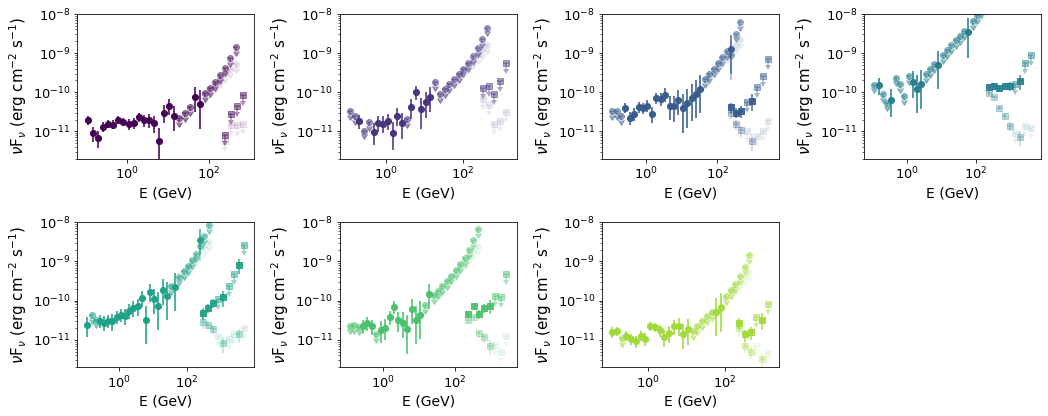

In [427]:
n = 8
colors = plt.cm.viridis(np.linspace(0,1,n))

fig, axs = plt.subplots(2, 4, figsize=(15,6))

N0s = [1.e-14, 3e-14,0.97e-14,1e-14,2.2e-14,3e-14,5e-15]
ind0s = [1.8 ,   1.5,  2.,    2,    1.85,  1.8,  1.9]

for ii, i in enumerate(range(1,8)):
    print("======== BB {} ========".format(i))
    _ = process_BB(f = "1ES1011/VEGAS_spec_1ES1011_fluxcorr_AB_BB{}.dat".format(i), 
              ff = "1ES1011/fermi/1ES1011_pipeline_BB_selected{}/4fgl_j1015.0+4926_sed.npy".format(i), 
                    ax = axs.flatten()[ii], tag="BB{}".format(i), format_ax=True, 
               color=colors[ii], label="BB{}".format(i) , alpha=0.9, 
                   p0=[N0s[ii], ind0s[ii], 200, 0.01], 
              save_csv=None, #
              #     save_csv="1ES1011_LAT_VER_SED_BB{}.csv".format(i), 
               outfile=None,) #
               #    outfile='1ES1011_LAT_VER_SED_BB{}_observed.pdf'.format(i))
    _.set_ylim(2e-12, 1e-8)

axs.flatten()[-1].axis('off')
plt.savefig("1ES1011_LAT_VER_SED_BBall_AB_7panels_fit.pdf")


In [ ]:
n = 8
colors = plt.cm.viridis(np.linspace(0,1,n))

fig, axs = plt.subplots(2, 4, figsize=(15,6))

N0s = [1.e-14, 3e-14,0.97e-14,1e-14,2.2e-14,3e-14,5e-15]
ind0s = [1.8 ,   1.5,  2.,    2,    1.85,  1.8,  1.9]

for ii, i in enumerate(range(1,8)):
    print("======== BB {} ========".format(i))
    if i==2:
        EDf=None
    else:
        EDf = "1ES1011/ED_spec_1ES1011_AB_BB{}.dat".format(i)
    _ = process_BB(f = "1ES1011/VEGAS_spec_1ES1011_fluxcorr_AB_BB{}.dat".format(i), 
              #ff = "1ES1011/fermi/1ES1011_pipeline_BB_selected{}/4fgl_j1015.0+4926_sed.npy".format(i), 
              ff = "1ES1011/fermi/1ES1011_pipeline_BB_4bpd_selected{}/4fgl_j1015.0+4926_sed.npy".format(i), 
                    ax = axs.flatten()[ii], tag="BB{}".format(i), format_ax=True, 
               color=colors[ii], label="BB{}".format(i) , alpha=0.9, 
                   ED = EDf, 
               EDcolor='r', EDmarker="X", EDalpha=0.3,
                   p0=[N0s[ii], ind0s[ii], 200, 0.01], 
              save_csv=None, #
              #     save_csv="1ES1011_LAT_VER_SED_BB{}.csv".format(i), 
               outfile=None,) #
               #    outfile='1ES1011_LAT_VER_SED_BB{}_observed.pdf'.format(i))
    _.set_ylim(2e-12, 1e-8)
    _.legend()
axs.flatten()[-1].axis('off')
plt.savefig("1ES1011_LAT_4bpd_VER_SED_BBall_AB_7panels_fit_EDcomparison.pdf")


In [ ]:
EDf

======== BB 1 ========

11
best-fit param 0 = 4.254e-14 +/- 3.253e-13
best-fit param 1 = 1.724 +/- 0.714
best-fit param 2 = 3.935e+04 +/- 5.13e-08
best-fit param 3 = 0.06544 +/- 0.2035
fit Chisq is 5.799, dof is 7, reduced Chisq is 0.83
Log likelihood lnL=-2.89945033578088


/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:377: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  subok=False, ndmin=ndmin)


======== BB 2 ========

9
best-fit param 0 = 2.749e-14 +/- 1.31e-14
best-fit param 1 = 1.595 +/- 0.07007
best-fit param 2 = 4.047e+04 +/- 6.109e-15
best-fit param 3 = 3.907e-05 +/- 0.07013
fit Chisq is 5.721, dof is 5, reduced Chisq is 1.14
Log likelihood lnL=-2.8605851544086445
======== BB 3 ========


/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:377: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  subok=False, ndmin=ndmin)



16
best-fit param 0 = 3e-12 +/- 3.442e-12
best-fit param 1 = 1.217 +/- 0.1757
best-fit param 2 = 1083 +/- 4.896e-06
best-fit param 3 = 0.1593 +/- 0.0142
fit Chisq is 6.711, dof is 12, reduced Chisq is 0.56
Log likelihood lnL=-3.3553887012526906


/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:377: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  subok=False, ndmin=ndmin)


======== BB 4 ========

12
best-fit param 0 = 8.769e-14 +/- 5.361e-13
best-fit param 1 = 1.876 +/- 0.5498
best-fit param 2 = 1e+05 +/- 5.111e-09
best-fit param 3 = 0.04045 +/- 0.1931
fit Chisq is 2.936, dof is 8, reduced Chisq is 0.37
Log likelihood lnL=-1.4680015127594663


/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:377: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  subok=False, ndmin=ndmin)


======== BB 5 ========

17
best-fit param 0 = 3e-12 +/- 5.098e-12
best-fit param 1 = 1.28 +/- 0.2332
best-fit param 2 = 1.075e+04 +/- 4.331e-07
best-fit param 3 = 0.1281 +/- 0.0189
fit Chisq is 15.123, dof is 13, reduced Chisq is 1.16
Log likelihood lnL=-7.561318621055453


/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:377: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  subok=False, ndmin=ndmin)


======== BB 6 ========

14
best-fit param 0 = 2.175e-13 +/- 7.494e-13
best-fit param 1 = 1.54 +/- 0.3966
best-fit param 2 = 1e+05 +/- 2.712e-08
best-fit param 3 = 0.08298 +/- 0.05349
fit Chisq is 14.678, dof is 10, reduced Chisq is 1.47
Log likelihood lnL=-7.338966797388583


/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:377: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  subok=False, ndmin=ndmin)
/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/matplotlib/axes/_axes.py:3322: RuntimeWarning: invalid value encountered in double_scalars
  low = [v - e for v, e in zip(data, a)]


======== BB 7 ========

14
best-fit param 0 = 6.64e-14 +/- 1.553e-13
best-fit param 1 = 1.685 +/- 0.2658
best-fit param 2 = 4.137e+04 +/- 4.129e-08
best-fit param 3 = 0.08483 +/- 0.04071
fit Chisq is 15.573, dof is 10, reduced Chisq is 1.56
Log likelihood lnL=-7.786554162182041


/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:377: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  subok=False, ndmin=ndmin)
/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/matplotlib/axes/_axes.py:3322: RuntimeWarning: invalid value encountered in double_scalars
  low = [v - e for v, e in zip(data, a)]


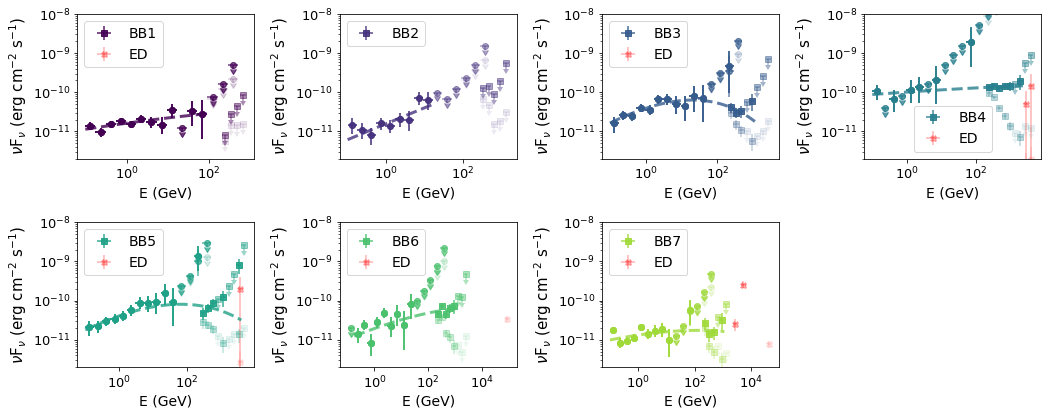

In [120]:
n = 8
colors = plt.cm.viridis(np.linspace(0,1,n))

fig, axs = plt.subplots(2, 4, figsize=(15,6))

N0s = [1.e-14, 3e-14,0.97e-14,1e-14,2.2e-14,3e-14,5e-15]
ind0s = [1.8 ,   1.5,  2.,    2,    1.85,  1.8,  1.9]

for ii, i in enumerate(range(1,8)):
    print("======== BB {} ========".format(i))
    if i==2:
        EDf=None
    else:
        #EDf = "1ES1011/ED_spec_1ES1011_AB_BB{}.dat".format(i)
        EDf = "1ES1011/ED_spec_1ES1011_AB_v483_BB{}.dat".format(i)
    _ = process_BB(f = "1ES1011/VEGAS_spec_1ES1011_fluxcorr_AB_BB{}.dat".format(i), 
              #ff = "1ES1011/fermi/1ES1011_pipeline_BB_selected{}/4fgl_j1015.0+4926_sed.npy".format(i), 
              ff = "1ES1011/fermi/1ES1011_pipeline_BB_4bpd_selected{}/4fgl_j1015.0+4926_sed.npy".format(i), 
                    ax = axs.flatten()[ii], tag="BB{}".format(i), format_ax=True, 
               color=colors[ii], label="BB{}".format(i) , alpha=0.9, 
                   ED = EDf, 
               EDcolor='r', EDmarker="X", EDalpha=0.3,
                   p0=[N0s[ii], ind0s[ii], 200, 0.01], 
              save_csv=None, #
              #     save_csv="1ES1011_LAT_VER_SED_BB{}.csv".format(i), 
               outfile=None,) #
               #    outfile='1ES1011_LAT_VER_SED_BB{}_observed.pdf'.format(i))
    _.set_ylim(2e-12, 1e-8)
    _.legend()
axs.flatten()[-1].axis('off')
plt.savefig("1ES1011_LAT_4bpd_VER_SED_BBall_AB_7panels_fit_EDcomparison_fluxcorr.png")


======== BB 1 ========


TypeError: process_BB() got an unexpected keyword argument 'fit'

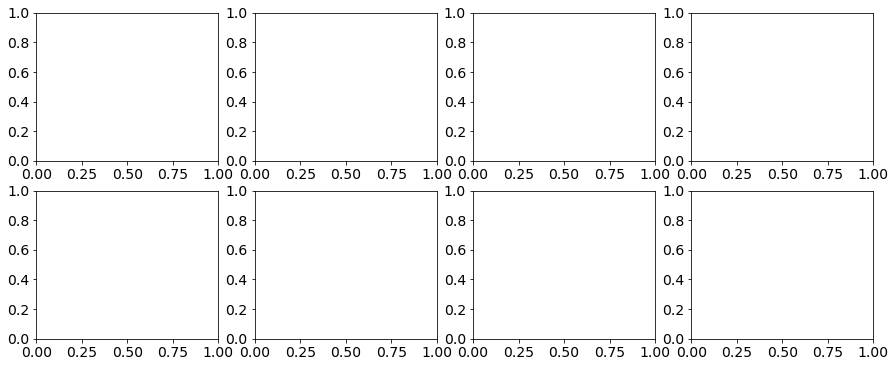

In [429]:
n = 8
colors = plt.cm.viridis(np.linspace(0,1,n))

fig, axs = plt.subplots(2, 4, figsize=(15,6))

N0s = [1.e-14, 3e-14,0.97e-14,1e-14,2.2e-14,3e-14,5e-15]
ind0s = [1.8 ,   1.5,  2.,    2,    1.85,  1.8,  1.9]

for ii, i in enumerate(range(1,8)):
    print("======== BB {} ========".format(i))
    _ = process_BB(f = "1ES1011/VEGAS_spec_1ES1011_fluxcorr_AB_BB{}.dat".format(i), 
              ff = "1ES1011/fermi/1ES1011_pipeline_BB_4bpd_selected{}/4fgl_j1015.0+4926_sed.npy".format(i), 
                    ax = axs.flatten()[ii], tag="BB{}".format(i), format_ax=True, 
               color=colors[ii], label="BB{}".format(i) , alpha=0.9, fit=True, 
                   p0=[N0s[ii], ind0s[ii], 200, 0.01], 
              save_csv=None, #
              #     save_csv="1ES1011_LAT_VER_SED_BB{}.csv".format(i), 
               outfile=None,) #
               #    outfile='1ES1011_LAT_VER_SED_BB{}_observed.pdf'.format(i))
    _.set_ylim(2e-12, 1e-8)

axs.flatten()[-1].axis('off')
#plt.savefig("1ES1011_LAT_VER_SED_BBall_AB_7panels_fit_v2.pdf")


======== BB 1 ========

11
best-fit param 0 = 6.261e-14 +/- 5.888e-13
best-fit param 1 = 1.712 +/- 0.7888
best-fit param 2 = 9.998e+05 +/- 2.26e-09
best-fit param 3 = 0.06123 +/- 0.1776
fit Chisq is 5.799, dof is 7, reduced Chisq is 0.83
Log likelihood lnL=-2.899310224977962
======== BB 2 ========



/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:377: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  subok=False, ndmin=ndmin)


9
best-fit param 0 = 3.225e-13 +/- 7.377e-12
best-fit param 1 = 1.399 +/- 2.043
best-fit param 2 = 5.357e+05 +/- 1.59e-08
best-fit param 3 = 0.07131 +/- 0.3956
fit Chisq is 5.924, dof is 5, reduced Chisq is 1.18
Log likelihood lnL=-2.9620016188708655
======== BB 3 ========


/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:377: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  subok=False, ndmin=ndmin)



16
best-fit param 0 = 3e-11 +/- 4.787e-11
best-fit param 1 = 1.076 +/- 0.212
best-fit param 2 = 1.127e+05 +/- 5.262e-08
best-fit param 3 = 0.1329 +/- 0.01067
fit Chisq is 6.613, dof is 12, reduced Chisq is 0.55
Log likelihood lnL=-3.306431441141873
======== BB 4 ========


/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:377: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  subok=False, ndmin=ndmin)



12
best-fit param 0 = 3.43e-13 +/- 1.147e-12
best-fit param 1 = 1.746 +/- 0.3551
best-fit param 2 = 2.078e+05 +/- 7.6e-09
best-fit param 3 = 0.06981 +/- 0.05869
fit Chisq is 3.023, dof is 8, reduced Chisq is 0.38
Log likelihood lnL=-1.5116640421404692
======== BB 6 ========



/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:377: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  subok=False, ndmin=ndmin)


14
best-fit param 0 = 3.121e-13 +/- 1.189e-12
best-fit param 1 = 1.523 +/- 0.4165
best-fit param 2 = 5.585e+05 +/- 5.111e-09
best-fit param 3 = 0.08004 +/- 0.04903
fit Chisq is 14.677, dof is 10, reduced Chisq is 1.47
Log likelihood lnL=-7.338587938651761
======== BB 7 ========



/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:377: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  subok=False, ndmin=ndmin)


14
best-fit param 0 = 4.063e-15 +/- 5.718e-16
best-fit param 1 = 1.827 +/- 0.0008728
best-fit param 2 = 0.004127 +/- 0.005176
best-fit param 3 = 0.2037 +/- 0.0002853
fit Chisq is 15.558, dof is 10, reduced Chisq is 1.56
Log likelihood lnL=-7.779134298355433


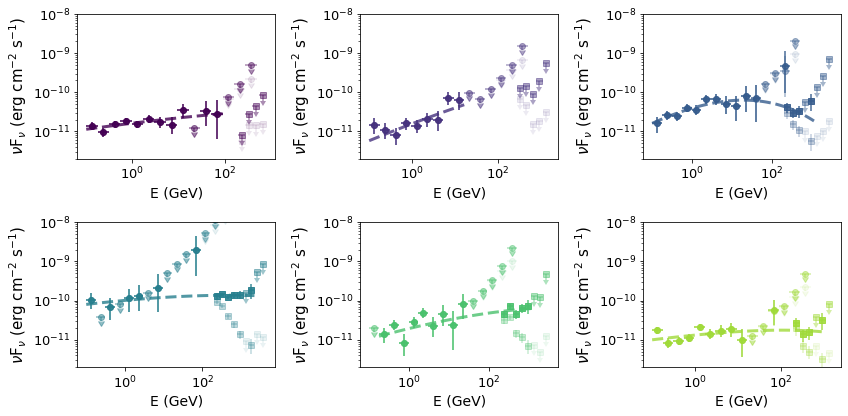

In [456]:
n = 8
colors = plt.cm.viridis(np.linspace(0,1,n))

fig, axs = plt.subplots(2, 3, figsize=(12,6))

N0s = [8.e-15, 3e-14,0.97e-14,1e-14,2.2e-14,12e-15,5e-15]
ind0s = [1.9 ,   1.5,  2.,    2,    1.85,  1.88,  1.9]

for ii, i in enumerate([1,2,3,4,6,7]):
#for ii, i in enumerate([6]):
    print("======== BB {} ========".format(i))
    _ = process_BB(f = "1ES1011/VEGAS_spec_1ES1011_fluxcorr_AB_BB{}.dat".format(i), 
              ff = "1ES1011/fermi/1ES1011_pipeline_BB_4bpd_selected{}/4fgl_j1015.0+4926_sed.npy".format(i), 
                    ax = axs.flatten()[ii], tag="BB{}".format(i), format_ax=True, 
               color=colors[i-1], label="BB{}".format(i) , alpha=0.9, fitV=True, 
                   p0=[N0s[i-1], ind0s[i-1], 200, 0.01], 
              save_csv=None, #
              #     save_csv="1ES1011_LAT_VER_SED_BB{}.csv".format(i), 
               outfile=None,) #
               #    outfile='1ES1011_LAT_VER_SED_BB{}_observed.pdf'.format(i))
    _.set_ylim(2e-12, 1e-8)

#axs.flatten()[-1].axis('off')
plt.savefig("1ES1011_LAT_VER_SED_BBall_AB_6panels_fit_v3.pdf")


======== BB 1 ========

20
best-fit param 0 = 3e-12 +/- 1.343e-11
best-fit param 1 = 1.261 +/- 0.5284
best-fit param 2 = 9913 +/- 1.499e-06
best-fit param 3 = 0.1536 +/- 0.05226
fit Chisq is 17.654, dof is 16, reduced Chisq is 1.10
Log likelihood lnL=-8.827182091903682
======== BB 2 ========



/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:377: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  subok=False, ndmin=ndmin)


13
best-fit param 0 = 3.263e-14 +/- 2.059e-14
best-fit param 1 = 1.56 +/- 0.0882
best-fit param 2 = 3.997e+04 +/- 3.923e-16
best-fit param 3 = 2.015e-05 +/- 0.08824
fit Chisq is 7.825, dof is 9, reduced Chisq is 0.87
Log likelihood lnL=-3.9127272710563896
======== BB 3 ========



/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:377: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  subok=False, ndmin=ndmin)


23
best-fit param 0 = 3e-12 +/- 5.488e-12
best-fit param 1 = 1.315 +/- 0.2585
best-fit param 2 = 1.092e+04 +/- 5.506e-07
best-fit param 3 = 0.1339 +/- 0.01898
fit Chisq is 10.927, dof is 19, reduced Chisq is 0.58
Log likelihood lnL=-5.463529709849998
======== BB 4 ========



/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:377: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  subok=False, ndmin=ndmin)


13
best-fit param 0 = 3.621e-14 +/- 1.449e-14
best-fit param 1 = 1.961 +/- 0.02309
best-fit param 2 = 8231 +/- 9.839e-12
best-fit param 3 = 0.001853 +/- 0.02412
fit Chisq is 4.170, dof is 9, reduced Chisq is 0.46
Log likelihood lnL=-2.0847716361921025
======== BB 5 ========



/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:377: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  subok=False, ndmin=ndmin)


25
best-fit param 0 = 9.734e-13 +/- 2.576e-12
best-fit param 1 = 1.483 +/- 0.3188
best-fit param 2 = 1e+05 +/- 3.517e-08
best-fit param 3 = 0.09903 +/- 0.0313
fit Chisq is 18.009, dof is 21, reduced Chisq is 0.86
Log likelihood lnL=-9.004485094527265
======== BB 6 ========



/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:377: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  subok=False, ndmin=ndmin)


19
best-fit param 0 = 1.308e-14 +/- 3.069e-15
best-fit param 1 = 1.868 +/- 0.01474
best-fit param 2 = 3.969e+04 +/- 1.61e-13
best-fit param 3 = 0.0006554 +/- 0.015
fit Chisq is 11.049, dof is 15, reduced Chisq is 0.74
Log likelihood lnL=-5.524712503069651
======== BB 7 ========



/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:377: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  subok=False, ndmin=ndmin)


22
best-fit param 0 = 8.031e-15 +/- 6.547e-16
best-fit param 1 = 1.838 +/- 0.00851
best-fit param 2 = 1 +/- 9.704e-05
best-fit param 3 = 0.09422 +/- 0.01387
fit Chisq is 13.977, dof is 18, reduced Chisq is 0.78
Log likelihood lnL=-6.988427463236864


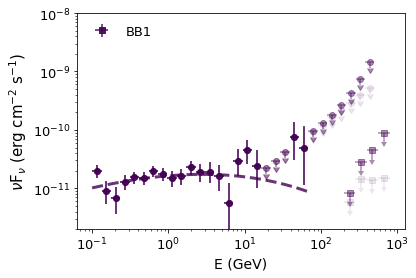

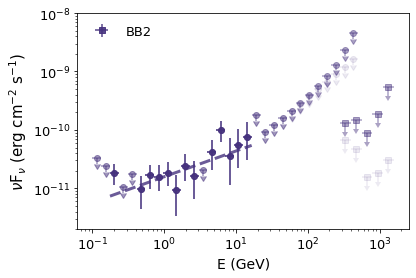

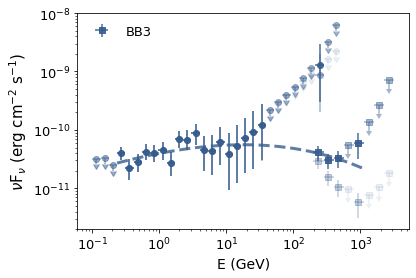

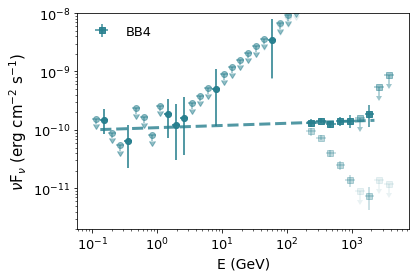

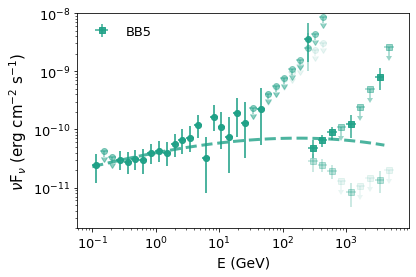

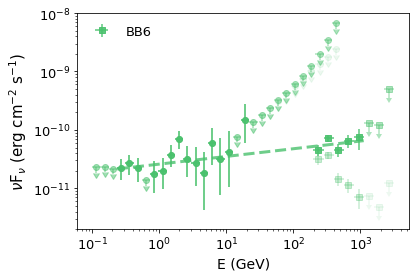

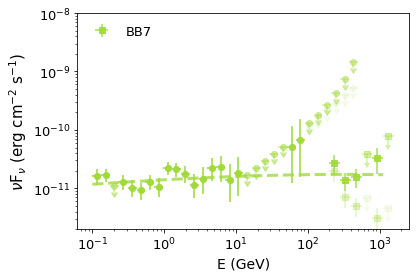

In [121]:
n = 8
colors = plt.cm.viridis(np.linspace(0,1,n))

#fig, axs = plt.subplots(2, 4, figsize=(15,6))

N0s = [1.e-14, 3e-14,0.97e-14,1e-14,2.2e-14,3e-14,5e-15]
ind0s = [1.8 ,   1.5,  2.,    2,    1.85,  1.8,  1.9]

for ii, i in enumerate(range(1,8)):
    fig, ax = plt.subplots()
    print("======== BB {} ========".format(i))
    _ = process_BB(f = "1ES1011/VEGAS_spec_1ES1011_fluxcorr_AB_BB{}.dat".format(i), 
              ff = "1ES1011/fermi/1ES1011_pipeline_BB_selected{}/4fgl_j1015.0+4926_sed.npy".format(i), 
                    ax = ax, tag="BB{}".format(i), format_ax=True, 
               color=colors[ii], label="BB{}".format(i) , alpha=0.9, 
                   p0=[N0s[ii], ind0s[ii], 200, 0.01], 
              save_csv=None, #
              #     save_csv="1ES1011_LAT_VER_SED_BB{}.csv".format(i), 
               #outfile=None,) #
                   outfile='1ES1011_LAT_VER_SED_BB{}.png'.format(i))
    _.set_ylim(2e-12, 1e-8)

#axs.flatten()[-1].axis('off')
plt.savefig("1ES1011_LAT_VER_SED_BBall_AB_7panels_fit.pdf")


/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:377: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  subok=False, ndmin=ndmin)



23
best-fit param 0 = 1.754e-14 +/- 1.325e-14
best-fit param 1 = 1.704 +/- 0.159
best-fit param 2 = 1 +/- 0.001526
best-fit param 3 = 0.1625 +/- 0.08271
fit Chisq is 19.611, dof is 19, reduced Chisq is 1.03
Log likelihood lnL=-9.805688792480726


/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:377: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  subok=False, ndmin=ndmin)



30
best-fit param 0 = 7.575e-14 +/- 1.002e-14
best-fit param 1 = 1.435 +/- 0.02786
best-fit param 2 = 1 +/- 0.001117
best-fit param 3 = 0.2814 +/- 0.009924
fit Chisq is 30.356, dof is 26, reduced Chisq is 1.17
Log likelihood lnL=-15.178242678671616


/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:377: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  subok=False, ndmin=ndmin)



32
best-fit param 0 = 6.528e-14 +/- 1.116e-14
best-fit param 1 = 1.459 +/- 0.03159
best-fit param 2 = 7.949 +/- 9.675e-05
best-fit param 3 = 0.1912 +/- 0.00769
fit Chisq is 29.594, dof is 28, reduced Chisq is 1.06
Log likelihood lnL=-14.796810237954864


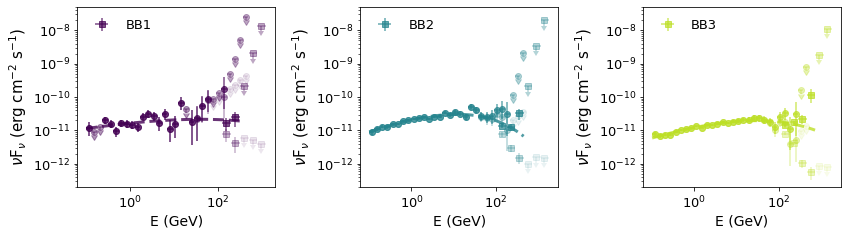

In [123]:
n = 3
colors = plt.cm.viridis(np.linspace(0,0.9,n))

fig, axs = plt.subplots(1, 3, figsize=(12,3.5))

for ii, i in enumerate([1,2,3]):
    ax = process_BB(f = "PKS1424/veritas/VEGAS_spec_PKS1424_fluxcorr_BB{}.dat".format(i), 
              ff = "PKS1424/fermi/PKS1424_pipeline_BB_selected{}/4fgl_j1427.0+2348_sed.npy".format(i), 
               ax = axs.flatten()[ii], tag="BB{}".format(i), format_ax=True, 
                    z=0.6035, 
               color=colors[ii], label="BB{}".format(i) , alpha=0.7, 
              save_csv=None, #"PKS1424_LAT_VER_SED_BB{}.csv".format(i), 
               outfile=None,) #'PKS1424_LAT_VER_SED_BB{}_observed.pdf'.format(i))
    ax.set_ylim(2e-13, 5e-8)
plt.savefig("PKS1424_LAT_VER_SED_BBall.pdf")


/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:377: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  subok=False, ndmin=ndmin)



23
best-fit param 0 = 1.754e-14 +/- 1.325e-14
best-fit param 1 = 1.704 +/- 0.159
best-fit param 2 = 1 +/- 0.001526
best-fit param 3 = 0.1625 +/- 0.08271
fit Chisq is 19.611, dof is 19, reduced Chisq is 1.03
Log likelihood lnL=-9.805688792480726


/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:377: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  subok=False, ndmin=ndmin)



30
best-fit param 0 = 7.575e-14 +/- 1.002e-14
best-fit param 1 = 1.435 +/- 0.02786
best-fit param 2 = 1 +/- 0.001117
best-fit param 3 = 0.2814 +/- 0.009924
fit Chisq is 30.356, dof is 26, reduced Chisq is 1.17
Log likelihood lnL=-15.178242678671616



/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:377: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  subok=False, ndmin=ndmin)


32
best-fit param 0 = 6.528e-14 +/- 1.116e-14
best-fit param 1 = 1.459 +/- 0.03159
best-fit param 2 = 7.949 +/- 9.675e-05
best-fit param 3 = 0.1912 +/- 0.00769
fit Chisq is 29.594, dof is 28, reduced Chisq is 1.06
Log likelihood lnL=-14.796810237954864


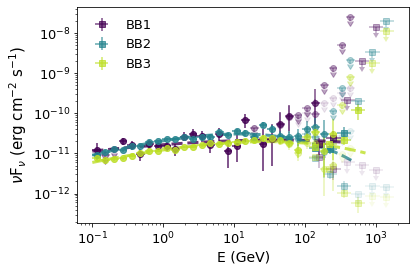

In [125]:
n = 3
colors = plt.cm.viridis(np.linspace(0,0.9,n))

ax = None
for ii, i in enumerate([1,2,3]):
    ax = process_BB(f = "PKS1424/veritas/VEGAS_spec_PKS1424_fluxcorr_BB{}.dat".format(i), 
              ff = "PKS1424/fermi/PKS1424_pipeline_BB_selected{}/4fgl_j1427.0+2348_sed.npy".format(i), 
                    ax = ax, tag="BB{}".format(i), z=0.6035, 
               color=colors[ii], label="BB{}".format(i) , alpha=0.7, 
              save_csv=None, #"PKS1424_LAT_VER_SED_BB{}.csv".format(i), 
               outfile=None,) #'PKS1424_LAT_VER_SED_BB{}_observed.pdf'.format(i))
plt.savefig("PKS1424_LAT_VER_SED_BBall_overlay.pdf")


/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:377: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  subok=False, ndmin=ndmin)



23
best-fit param 0 = 9.044e-15 +/- 1.74e-15
best-fit param 1 = 1.846 +/- 0.02633
best-fit param 2 = 3.638e+04 +/- 2.083e-15
best-fit param 3 = 8.029e-06 +/- 0.02634
fit Chisq is 20.786, dof is 19, reduced Chisq is 1.09
Log likelihood lnL=-10.392771492216946


/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:377: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  subok=False, ndmin=ndmin)



30
best-fit param 0 = 3e-12 +/- 1.596e-12
best-fit param 1 = 1.234 +/- 0.0665
best-fit param 2 = 2.376e+04 +/- 6.144e-08
best-fit param 3 = 0.1316 +/- 0.005816
fit Chisq is 33.016, dof is 26, reduced Chisq is 1.27
Log likelihood lnL=-16.508026049988374



/home/qifeng/miniconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:377: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  subok=False, ndmin=ndmin)


32
best-fit param 0 = 1.373e-13 +/- 9.644e-14
best-fit param 1 = 1.54 +/- 0.07467
best-fit param 2 = 1e+05 +/- 4.829e-09
best-fit param 3 = 0.08401 +/- 0.0117
fit Chisq is 61.002, dof is 28, reduced Chisq is 2.18
Log likelihood lnL=-30.501103308238076


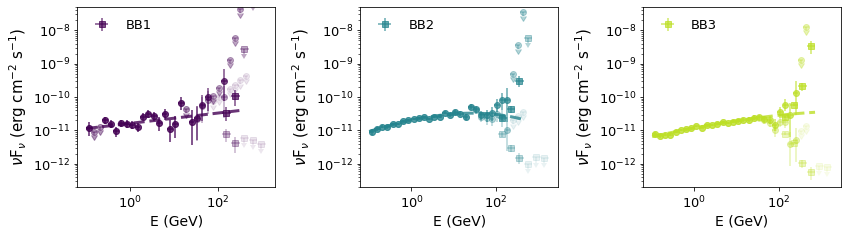

In [126]:
n = 3
colors = plt.cm.viridis(np.linspace(0,0.9,n))

fig, axs = plt.subplots(1, 3, figsize=(12,3.5))

for ii, i in enumerate([1,2,3]):
    ax = process_BB(f = "PKS1424/veritas/VEGAS_spec_PKS1424_fluxcorr_BB{}.dat".format(i), 
              ff = "PKS1424/fermi/PKS1424_pipeline_BB_selected{}/4fgl_j1427.0+2348_sed.npy".format(i), 
               ax = axs.flatten()[ii], tag="BB{}".format(i), format_ax=True, 
                    z=0.9, 
               color=colors[ii], label="BB{}".format(i) , alpha=0.7, 
              save_csv=None, #"PKS1424_LAT_VER_SED_BB{}.csv".format(i), 
               outfile=None,) #'PKS1424_LAT_VER_SED_BB{}_observed.pdf'.format(i))
    ax.set_ylim(2e-13, 5e-8)
plt.savefig("PKS1424_LAT_VER_SED_BBall_3panel_z0p9.pdf")


# Fermi

Deabsorbing at z=0.031
Deabsorbing at z=0.031
Deabsorbing at z=0.031
Deabsorbing at z=0.031


/Users/qifeng/.pyenv/versions/3.10.2/lib/python3.10/site-packages/astropy/units/quantity.py:504: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  value = np.array(value, dtype=dtype, copy=copy, order=order,


6


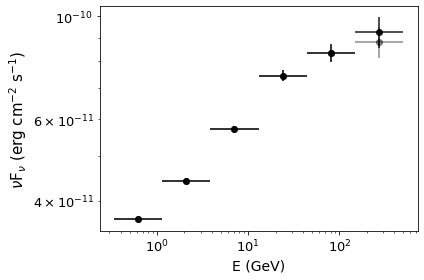

In [11]:
# de-absorption
from gammapy.modeling.models import (
    EBLAbsorptionNormSpectralModel,
    Models,
    PowerLawSpectralModel,
    SkyModel,
)

def deabs_z(e_tev_joint, f_tev_joint, df_tev_joint, model="dominguez", z=0.212):
    print("Deabsorbing at z={}".format(z))
    f_deabs = np.zeros_like(f_tev_joint)
    df_deabs = np.zeros_like(df_tev_joint)
    
    eblmodel = EBLAbsorptionNormSpectralModel.read_builtin(model, redshift=z)

    for i, e_ in enumerate(e_tev_joint):
        if e_ >= 1e-3:
            ebl_frac = eblmodel.evaluate_error(e_*u.TeV)[0]
        else:
            ebl_frac = 1.0
        #print(e_, f_tev_joint[i],ebl_frac)
        f_deabs[i] = f_tev_joint[i] / ebl_frac
        df_deabs[i] = df_tev_joint[i] / ebl_frac
    return f_deabs, df_deabs


def plot_lat_spec(sed, 
               z = 0, ethresh=0.2, 
               ax = None, tag="", format_ax=False, 
               c_='k', f_='s', l_="Fermi-LAT" ,
               save_csv=None, alpha=0.7, 
               outfile=None, #'1ES1011_VERITAS_spec.pdf', 
               convert_to_cm=True, p0=[3e-14, 1.5, 1e3,0.01], 
               model=None,  df_combined=None, fit=False,  **kwargs):
    
 
        
    if ax is None:
        fig = plt.figure()

        fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)

        ax = fig.add_subplot(111)
        format_ax = True
        
    if format_ax: 
        ticksize=14
        ax.xaxis.set_tick_params(labelsize=ticksize)
        ax.yaxis.set_tick_params(labelsize=ticksize)


        #ax.ticklabel_format(style='plain', useOffset=False, axis='x')
        #plt.ticklabel_format(style='plain', useOffset=False, axis='x')

        ax.set_xlabel('E (GeV)', fontsize=14)
        #ax.set_ylabel('dN/dE (TeV$^{-1}$ cm$^{-2}$ s$^{-1}$)', fontsize=14)
        ax.set_ylabel(r'$\nu$F$_\nu$ (erg cm$^{-2}$ s$^{-1}$)', fontsize=15)

        ax.set_xscale('log')
        ax.set_yscale('log')

        ticksize=13
        #ax.xaxis.set_tick_params(labelsize=ticksize, which="both")
        #ax.yaxis.set_tick_params(labelsize=ticksize, which="both")


        #ax.xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
        #ax.xaxis.set_minor_formatter(FormatStrFormatter("%.1f"))

        #plt.xticks(rotation=60)
        #plt.setp(ax.xaxis.get_minorticklabels(), rotation=60)


        ax.tick_params(labelsize=ticksize, which="both")

        #ax.set_ylim(1e-9, 2e-5)
        #ax.set_xlim(0.091,2.900)
    
    #plotEs = np.logspace(np.log10(df_.E[0]*1e3),np.log10(df_.E.values[-1]*1e3),100)
    mev2ergs = 1.6e-6
    tev2ergs = 1.6
    
    latalpha=alpha
           
    # fermi
    
    ul_ts_threshold = 4
    kw = {}
    #kw['marker'] = kwargs.get('marker', 'o')
    #kw['linestyle'] = kwargs.get('linestyle', 'None')
    #kw['color'] = kwargs.get('color', 'k')
    kw['marker'] = kwargs.get('marker', 'o')
    kw['linestyle'] = kwargs.get('linestyle', 'None')
    kw['color'] = kwargs.get('color', 'k')
    kw['alpha'] = latalpha
    #kw['label']=""
    
    #fmin, fmax = SEDPlotter.get_ylims(sed)
    
    ethresh_slice = sed['e_ctr']>=(ethresh*1e3)
    m = sed['ts'] < ul_ts_threshold
    x = sed['e_ctr']*1e-3
    y = sed['e2dnde']*mev2ergs
    yerr = sed['e2dnde_err']*mev2ergs
    yerr_lo = sed['e2dnde_err_lo']*mev2ergs
    yerr_hi = sed['e2dnde_err_hi']*mev2ergs
    yul = sed['e2dnde_ul95']*mev2ergs

    delo = sed['e_ctr']*1e-3 - sed['e_min']*1e-3
    dehi = sed['e_max']*1e-3 - sed['e_ctr']*1e-3
    
    
    m = m[ethresh_slice]
    x = x[ethresh_slice]
    y = y[ethresh_slice]
    yerr = yerr[ethresh_slice]
    yerr_lo = yerr_lo[ethresh_slice]
    yerr_hi = yerr_hi[ethresh_slice]
    yul = yul[ethresh_slice]
    delo = delo[ethresh_slice]
    dehi = dehi[ethresh_slice]
    
    xerr0 = np.vstack((delo[m], dehi[m]))
    xerr1 = np.vstack((delo[~m], dehi[~m]))

    if z > 0:
        y_deabs, yerr_deabs = deabs_z(x*1e-3, y, yerr, z=z)
        y_deabs, yerr_lo_deabs = deabs_z(x*1e-3, y, yerr_lo, z=z)
        y_deabs, yerr_hi_deabs = deabs_z(x*1e-3, y, yerr_hi, z=z)
        y_deabs, yul_deabs = deabs_z(x*1e-3, y, yul, z=z)

        ax.errorbar(x[~m], y_deabs[~m], xerr=xerr1,
                 yerr=(yerr_lo_deabs[~m], yerr_hi_deabs[~m]), 
                 **kw)
    
        kw['alpha'] = latalpha/2.
        ax.errorbar(x[m], yul_deabs[m], xerr=xerr0,
                     yerr=yul_deabs[m] * 0.2, uplims=True, **kw)

        latalpha = 0.3
    ax.errorbar(x[~m], y[~m], xerr=xerr1,
                 yerr=(yerr_lo[~m], yerr_hi[~m]), 
                 **kw)
    
    kw['alpha'] = latalpha - 0.2
    ax.errorbar(x[m], yul[m], xerr=xerr0,
                 yerr=yul[m] * 0.2, uplims=True, **kw)
    
    
    
    #ax.legend(loc='upper left', fontsize=13,frameon=False)
    plt.tight_layout()
    if outfile is not None: 
        plt.savefig(outfile)

    
    if df_combined is None: 
        # writing to file
        df_combined = pd.DataFrame(columns=['E_GeV','F','dF','dElo','dEhi','F_deabs','dF_deabs','isUL','Instrument','Tag'])
        len_cur = 0
    else: 
        len_cur  = len(df_combined)
        
    for i in range(len(x)):
        df_combined.loc[i+len_cur] = [x[i], y[i], yerr[i],  delo[i], dehi[i], y_deabs[i], yerr_deabs[i], m[i], "Fermi-LAT", tag]

    len_lat  = len(df_combined)

    if save_csv is not None: 
        df_combined.to_csv(save_csv, index=False)
    #ax.set_yscale('log')
    #ax.set_xscale('log')
    #ax.set_xlim(sed['e_min'][0], sed['e_max'][-1])
    #ax.set_ylim(10 ** fmin, 10 ** fmax)

    print(len(df_combined[df_combined["isUL"]==False]))
    if len(df_combined[df_combined["isUL"]==False])>4 and fit:
        #fit_plec(df_combined, p0=p0, ax=ax, color=c_)
        fit_log_plec(df_combined, p0=p0, ax=ax, color=c_)
    else:
        if fit:
            print("Too few data points to fit plec")
        
        
    #ax.legend(loc='upper left', fontsize=13,frameon=False)
    plt.tight_layout()
    if outfile is not None: 
        plt.savefig(outfile)

        
        
    #plt.show()
    return ax, df_combined





def plot_lat(f = "1ES1011/fermi/1ES1011_pipeline_BB_selected1/4fgl_j1015.0+4926_sed.npy", ax=None, tag="Fermi-LAT", format_ax=True, 
               color='k', label="Fermi-LAT" , alpha=0.9, z=0.031,
              save_csv=None, #"1ES1011_LAT_VER_SED_BB{}.csv".format(i), 
               outfile=None, p0=[3e-14, 1.5, 1e3,0.01], 
               bounds=([1e-16,1,1e-5,0], [3.e-11, 5., 1e6,100]), 
                       fit_func=plec2_E2_100GeV, 
               model_color='k', model_ls="--", ):
    
    lat_spec = np.load(f, allow_pickle=True, encoding='latin1').item()

    #ax, df_combined
    _ = plot_lat_spec(lat_spec, z=z, ax = ax, tag=tag, format_ax=format_ax, c_=color, f_='s', l_=label , alpha=alpha, color=color,
               save_csv=save_csv, p0=p0, 
               outfile=outfile), #convert_to_cm=False,)
        
    #return ax

plot_lat(f = "Mrk421_pipeline/4fgl_j1104.4+3812_sed.npy",z=0.031)
plt.savefig("Mrk421_pipeline_overall_sed.png")

Mrk 421

In [12]:

Enorm = 1

f1 = "Mrk421/M4_VEGAS_spectrum_ITM4tel.txt"
df_Vspec1 = pd.read_csv(f, sep = r"\s+",  header=None, comment='#', skiprows=1, 
                    names=['+', 'bin' , 'E', 'dE' ,'f' ,'df', 'Non', 'Noff', 'Nexcess', 'RawOff', 
                           'Alpha', 'Sig', 'Emin', 'Emax'])
df_Vspec_flux1 = df_Vspec1[df_Vspec1['+']=='+']
df_Vspec_ul1 = df_Vspec1[df_Vspec1['+']=='-']


Enorm = 1

f = "Mrk421/M4_VEGAS_spectrum_ITM4tel_v2.txt"
df_Vspec = pd.read_csv(f, sep = r"\s+",  header=None, comment='#', skiprows=1, 
                    names=['+', 'bin' , 'E', 'dE' ,'f' ,'df', 'Non', 'Noff', 'Nexcess', 'RawOff', 
                           'Alpha', 'Sig', 'Emin', 'Emax'])
df_Vspec_flux = df_Vspec[df_Vspec['+']=='+']
df_Vspec_ul = df_Vspec[df_Vspec['+']=='-']


#ff = "Mrk421_pipeline/Mrk421_pipeline.npy"
ff = "Mrk421_pipeline/4fgl_j1104.4+3812_sed.npy"

lat_spec = np.load(ff, allow_pickle=True, encoding='latin1').item()
#print(lat_spec) # Display contents of dictionary


In [13]:
df_EDspec_flux, df_EDspec_ul = read_ED_spec("spectralpoints_Mrk421_4tel.dat")
df_EDspec_flux

,E,Emin,Emax,dE,f,df,dflo,dfhi,Non,dNon,Noff,dNoff,Alpha,Sig,T,_,EA
0,0.100,0.079,0.126,0.046,3.838000e-09,2.712000e-10,"(2.666e-10,",2.760e-10),330.0,18.2,411.0,20.3,0.17,19.8,125480.6,Eff.Area:,1168.6[m^2]
1,0.158,0.126,0.200,0.074,3.037000e-09,2.686000e-11,"(2.680e-11,",2.694e-11),16115.0,126.9,9819.0,99.1,0.17,177.0,373828.0,Eff.Area:,17317.3[m^2]
2,0.251,0.200,0.316,0.117,1.138000e-09,6.135000e-12,"(6.127e-12,",6.151e-12),39412.0,198.5,14485.0,120.4,0.17,308.4,806959.0,Eff.Area:,34536.6[m^2]
3,0.398,0.316,0.501,0.185,4.223000e-10,2.211000e-12,"(2.211e-12,",2.217e-12),39014.0,197.5,7187.0,84.8,0.17,337.8,899742.9,Eff.Area:,53811.4[m^2]
4,0.631,0.501,0.794,0.293,1.470000e-10,8.556000e-13,"(8.548e-13,",8.574e-13),30811.0,175.5,3615.0,60.1,0.17,312.9,934445.7,Eff.Area:,75012.6[m^2]
5,1.000,0.794,1.259,0.465,4.564000e-11,3.395000e-13,"(3.388e-13,",3.405e-13),18643.0,136.5,1586.0,39.8,0.17,248.8,951434.7,Eff.Area:,91094.5[m^2]
6,1.585,1.259,1.995,0.736,1.328000e-11,1.373000e-13,"(1.369e-13,",1.378e-13),9518.0,97.6,470.0,21.7,0.17,182.7,953107.4,Eff.Area:,101288.1[m^2]
7,2.512,1.995,3.162,1.167,3.938000e-12,5.616000e-14,"(5.590e-14,",5.644e-14),4980.0,70.6,175.0,13.2,0.17,133.8,955910.7,Eff.Area:,112694.1[m^2]
8,3.981,3.162,5.012,1.850,9.590000e-13,2.105000e-14,"(2.090e-14,",2.121e-14),2094.0,45.8,52.0,7.2,0.17,87.6,955910.7,Eff.Area:,122986.7[m^2]
9,6.310,5.012,7.943,2.931,1.844000e-13,7.120000e-15,"(7.029e-15,",7.212e-15),679.0,26.1,22.0,4.7,0.17,49.5,955910.7,Eff.Area:,130666.5[m^2]


In [14]:
def plot_VEGAS_LAT(f = f, plot_ratio=True, 
              ff = ff, 
               ED = None, EDsigma=0, EDcolor='k', EDmarker="X", EDalpha=0.6,
               z=0, fitV=False ,
               ax = None, alpha=0.7, color='k', label="VERITAS", tag="BB1", format_ax=False,
               p0=[3e-14, 1.5, 1e-3,0.1], 
               bounds=([1e-16,1,1e-8,0], [3.e-11, 5., 1e6,100]), 
                       fit_func=plec2_E2_100GeV, 
               model_color='k', model_ls="--", 
              save_csv="Mrk421_LAT_VER_SED_4tel.csv", 
               outfile='Mrk421_LAT_VER_SED_4tel.pdf'):
    
    lat_spec = np.load(ff, allow_pickle=True, encoding='latin1').item()

    if f is not None: 
        #print("got f")
        df_Vspec = pd.read_csv(f, sep = r"\s+",  header=None, comment='#', skiprows=1, 
                            names=['+', 'bin' , 'E', 'dE' ,'f' ,'df', 'Non', 'Noff', 'Nexcess', 'RawOff', 
                                   'Alpha', 'Sig', 'Emin', 'Emax'])
        df_Vspec_flux = df_Vspec[df_Vspec['+']=='+']
        df_Vspec_ul = df_Vspec[df_Vspec['+']=='-']
        df_combinedV, ax, ps_lp, dps_lp, model, model_err = plot_Vspec(df_Vspec, lat_spec, 
                        z=z, fit=fitV, 
               ax = ax, tag=tag, format_ax=format_ax, 
               c_=color, f_='s', l_=label , alpha=alpha, color=color,
               save_csv=save_csv, 
                        p0=p0, 
               outfile=outfile, #convert_to_cm=False,
               model="LP")
        
    if ED is not None: 
        df_EDspec_flux, df_EDspec_ul = read_ED_spec(ED, sigma=EDsigma)
        ax, df_combined = plot_lat_spec(lat_spec, 
                        z=z, 
               ax = ax, tag=tag, format_ax=format_ax, 
               c_=color, f_='s', l_=label , alpha=alpha, color=color,
               save_csv=save_csv, 
                        p0=p0, 
               outfile=outfile, #convert_to_cm=False,
               model=None)
        ax, df_combined = plot_EDspec(df_EDspec_flux, z=z, ax = ax, 
                   c_=EDcolor, f_=EDmarker, l_="ED" , alpha=EDalpha, color=EDcolor,
                                     df_combined=df_combined, save_csv=save_csv, 
                                       model_color=model_color, model_ls = model_ls, 
                                     p0=p0, bounds=bounds, fit_func=fit_func)
        
    
    #ax.plot(plotEs, model, color='r', ls='--')
    #print(model)
    #print(df_combined[df_combined['F_deabs'] != (np.inf or -np.inf)])
    plt.legend()
    ax.set_xlim(5e1, 1e5)
    ax.set_ylim(2e-12, 3e-10)

    plt.savefig("spec_compM4avg_v3.pdf")
    
    if plot_ratio: 
        
        fig = plt.figure()
        fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
        ax1 = fig.add_subplot(111)
        
        #plotEs = np.logspace(np.log10(0.15e-3),np.log10(25),100)

        
        #ax1.errorbar(dfrev['E'], dfrev['F'], fake_err,ls="", marker="o")
        #ax1.plot(plotEs, model, color='r', ls='--')
        df_fit = df_combined[df_combined['F_deabs'] != (np.inf or -np.inf)]
        df_fit = df_fit[df_fit['F_deabs']<1]
        df_fit = df_fit[df_fit['dF_deabs']<df_fit['F_deabs']]
        
                
        #df_combinedV = df_combinedV[df_combinedV['Instrument']=="VERITAS"]
        #df_fit = df_fit[df_fit['Instrument']=="VERITAS"]
        
        #print(df_fit)
        #print(df_combinedV)
        plotEs, model_plec, ps_plec = fit_plec(df_fit, 
                                                   #bounds=(-np.inf, np.inf),p0=p0,  
                                                   #bounds=bounds, p0=p0,  
                                                   p0=[3e-14, 1.5, 1e-3,0.01], bounds=([1e-16,1,1e-5,0], [3.e-11, 5., 1e6,100]), 
                 ax=None, color=model_color, ls = model_ls, 
                fit_func=fit_func, MCbound=True)
        print(ps_plec)
        
        plotEs = np.logspace(np.log10(1e-1),np.log10(3e5),100)
        ax1.plot(plotEs, np.ones_like(plotEs))
        model_lpV = fit_func(df_combinedV['E_GeV'], *ps_plec)# *plotEs*plotEs
        #model_lpVUL = fit_func(df_combinedV['E_GeV'], *ps_plec)# *plotEs*plotEs
        #model_errlpV = ferrLP(plotEs, model_lp, ps_lp[0],dps_lp[0], 
        #                     ps_lp[1],dps_lp[1], ps_lp[2],dps_lp[2], 0.3)
        model_lpE = fit_func(df_fit['E_GeV'], *ps_plec)# *plotEs*plotEs
        #model_lpEUL = fit_func(df_fit['E_GeV'], *ps_plec)# *plotEs*plotEs
        
        print("====check====")
        #print(df_combined['F_deabs'], model_lpE)


        print(df_combinedV['F_deabs'].values/model_lpV.values)
        print(df_combinedV['dF_deabs'].values/model_lpV.values)
        print(df_fit['F_deabs'].values/model_lpE.values)
        print(df_fit['dF_deabs'].values/model_lpE.values)
        print(df_combinedV['E_GeV'].values)
        
        ax1.errorbar(df_combinedV['E_GeV'].values, df_combinedV['F_deabs'].values/model_lpV.values, yerr=df_combinedV['dF_deabs'].values/model_lpV.values, color='k', ls='', 
                    ms=8, mec='k',ecolor='k', capthick=0,label="VEGAS ratio", alpha=0.9, marker='s')
        #ax1.plot(df_Vspec_ul['E']*1e3, df_Vspec_ul['f']/model_lpVUL, color='k', ls='--')
        ax1.errorbar(df_fit['E_GeV'].values, df_fit['F_deabs'].values/model_lpE.values, yerr= df_fit['dF_deabs'].values/model_lpE.values, color='r', ls='', 
                    ms=8, mec='r',ecolor='r', capthick=0,label="ED ratio", alpha=0.9, marker='X')
        #ax1.plot(df_EDspec_ul['E']*1e3, df_combined['F_deabs']/model_lpEUL, color='r', ls='--')

        #ax1.fill_between(plotEs,(model-model_err),
        #                    (model+model_err),alpha=0.3,color='r', )
        ax1.set_xscale('log')
        #ax1.set_yscale('log')
        ax1.set_xlabel("E")
        ax1.set_ylabel("ratio")
        #ax1.set_xlim(1e-1, 30)
        ax1.set_ylim(0.1, 2)
        ax1.set_xlim(5e1, 1e5)
        #ax.set_ylim(2e-12, 3e-10)

        plt.legend()
        plt.tight_layout()
        plt.savefig("ratioM4avg_v3.pdf")
        
    return ax

Deabsorbing at z=0.031
best-fit param 0 = 9e-11 +/- inf
best-fit param 1 = 3.3 +/- inf
best-fit param 2 = 0.6 +/- inf
fit Chisq is 158223.228, dof is 10, reduced Chisq is 15822.32
Log likelihood lnL=-79111.6137731901
Deabsorbing at z=0.031
Deabsorbing at z=0.031
Deabsorbing at z=0.031
Deabsorbing at z=0.031
20


/Users/qifeng/.pyenv/versions/3.10.2/lib/python3.10/site-packages/astropy/units/quantity.py:504: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  value = np.array(value, dtype=dtype, copy=copy, order=order,
/Users/qifeng/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/qifeng/.pyenv/versions/3.10.2/lib/python3.10/site-packages/astropy/units/quantity.py:504: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating

Deabsorbing at z=0.031
Deabsorbing at z=0.031
Deabsorbing at z=0.031
Deabsorbing at z=0.031


/Users/qifeng/.pyenv/versions/3.10.2/lib/python3.10/site-packages/astropy/units/quantity.py:504: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  value = np.array(value, dtype=dtype, copy=copy, order=order,


6
Deabsorbing at z=0.031
23


/Users/qifeng/.pyenv/versions/3.10.2/lib/python3.10/site-packages/astropy/units/quantity.py:504: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  value = np.array(value, dtype=dtype, copy=copy, order=order,


MC best-fit param 0 = 1.349e-14 +/- 5.916e-17
MC best-fit param 1 = 1.732 +/- 0.001526
MC best-fit param 2 = 0.0008531 +/- 1.077e-05
MC best-fit param 3 = 0.6284 +/- 0.0004079
MC fit Chisq is 491.985, dof is 19, reduced Chisq is 25.89
MC Log likelihood lnL=-245.99253984972918
MC best-fit param 0 = 1.349e-14 +/- 5.916e-17
MC best-fit param 1 = 1.732 +/- 0.001526
MC best-fit param 2 = 0.0008531 +/- 1.077e-05
MC best-fit param 3 = 0.6284 +/- 0.0004079
MC fit Chisq is 490.858, dof is 15, reduced Chisq is 32.72
MC Log likelihood lnL=-245.4291295386791
[1.34924737e-14 1.73246754e+00 8.53091307e-04 6.28401351e-01]
====check====
[1.12058936 1.06496074 0.93995759 0.89611929 0.88449994 0.78970413
 0.78121657 1.22889168 1.1875963  1.09595833 1.08200249 1.08650386
 1.0884394  1.06387215 1.03768956 1.04599944 1.08157579 1.04075563
 1.28818819 1.92917662]
[0.01315168 0.00903755 0.00987125 0.01419091 0.02231256 0.03428383
 0.06110257 0.00923228 0.00676993 0.00619338 0.00669526 0.00764987
 0.00918683 

(1e-13, 1e-09)

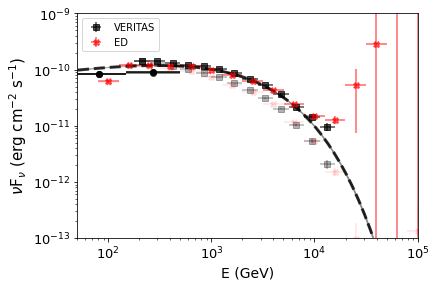

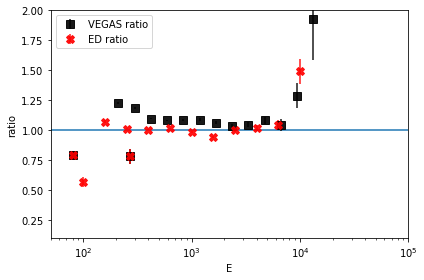

In [16]:
ax = plot_VEGAS_LAT(f = f, 
              ff = ff, ED="spectralpoints_Mrk421_4tel.dat", z=0.031, 
              EDsigma=0, EDcolor='r', EDmarker="X", EDalpha=0.6,
               fitV=False , plot_ratio=1, 
               ax = None, alpha=0.7, color='k', label="VERITAS", tag="avg",)
ax.set_ylim(1e-13, 1e-9)

Deabsorbing at z=0.031

Deabsorbing at z=0.031
Deabsorbing at z=0.031
Deabsorbing at z=0.031
Deabsorbing at z=0.031
20


/Users/qifeng/.pyenv/versions/3.10.2/lib/python3.10/site-packages/astropy/units/quantity.py:504: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  value = np.array(value, dtype=dtype, copy=copy, order=order,
/Users/qifeng/.pyenv/versions/3.10.2/lib/python3.10/site-packages/astropy/units/quantity.py:504: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  value = np.array(value, dtype=dtype, copy=copy, order=order,


Deabsorbing at z=0.031
Deabsorbing at z=0.031
Deabsorbing at z=0.031
Deabsorbing at z=0.031


/Users/qifeng/.pyenv/versions/3.10.2/lib/python3.10/site-packages/astropy/units/quantity.py:504: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  value = np.array(value, dtype=dtype, copy=copy, order=order,


6
Deabsorbing at z=0.031
23


/Users/qifeng/.pyenv/versions/3.10.2/lib/python3.10/site-packages/astropy/units/quantity.py:504: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  value = np.array(value, dtype=dtype, copy=copy, order=order,


MC best-fit param 0 = 1.349e-14 +/- 5.916e-17
MC best-fit param 1 = 1.732 +/- 0.001526
MC best-fit param 2 = 0.0008531 +/- 1.077e-05
MC best-fit param 3 = 0.6284 +/- 0.0004079
MC fit Chisq is 491.985, dof is 19, reduced Chisq is 25.89
MC Log likelihood lnL=-245.9925398474215


NameError: name 'model_pl' is not defined

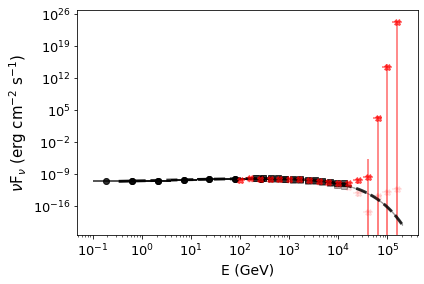

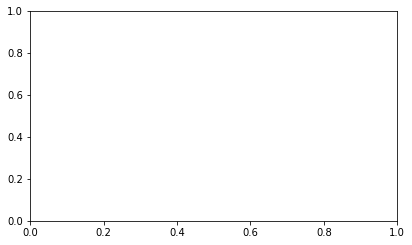

In [24]:
ax = plot_VEGAS_LAT(f = f, 
              ff = ff, ED="spectralpoints_Mrk421_4tel.dat", 
                    #z=0, 
                    z=0.031, 
              EDsigma=0, EDcolor='r', EDmarker="X", EDalpha=0.6,
               fitV=False ,
               ax = None, alpha=0.7, color='k', label="VERITAS", tag="avg",)
ax.set_xlim(5e1, 1e5)
ax.set_ylim(2e-12, 3e-10)
plt.legend()
plt.savefig("Mrk421_VEGAS_ED_comp_ITM_v1.pdf")
#plt.savefig("Mrk421_VEGAS_ED_comp_ITM.png", dpi=300)


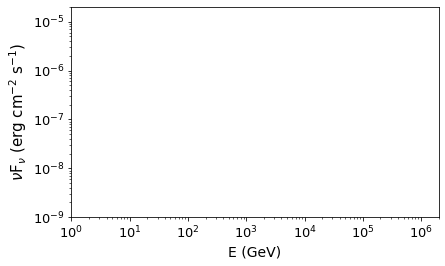

In [220]:

df_Vspec = df_Vspec_flux
convert_to_cm = 0
z=0.031

if True:
    if convert_to_cm and np.mean(df_Vspec["f"])>1e-9:
            df_Vspec["f"]=df_Vspec["f"]*1e-4
            df_Vspec["df"] = df_Vspec["df"].values.astype(float)*1e-4

    if z > 0:
        f_deabs, df_deabs = deabs_z(df_Vspec["E"], df_Vspec["f"], df_Vspec["df"], z=z)
        df_Vspec["f_deabs"] = f_deabs 
        df_Vspec["df_deabs"] = df_deabs
    else: 
        df_Vspec["f_deabs"] = 0
        df_Vspec["df_deabs"] = 0
        
    df_ = df_Vspec[df_Vspec['+']=='+']
    df_ul = df_Vspec[df_Vspec['+']=='-']

    
        
    #if ax is None:
    if True:     
        fig = plt.figure()

        fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)

        ax = fig.add_subplot(111)
        format_ax = True
        
    #if format_ax: 
        ticksize=14
        ax.xaxis.set_tick_params(labelsize=ticksize)
        ax.yaxis.set_tick_params(labelsize=ticksize)


        #ax.ticklabel_format(style='plain', useOffset=False, axis='x') #6panel
        
        #plt.ticklabel_format(style='plain', useOffset=False, axis='x')

        ax.set_xlabel('E (GeV)', fontsize=14)
        #ax.set_ylabel('dN/dE (TeV$^{-1}$ cm$^{-2}$ s$^{-1}$)', fontsize=14)
        ax.set_ylabel(r'$\nu$F$_\nu$ (erg cm$^{-2}$ s$^{-1}$)', fontsize=15)

        ax.set_xscale('log')
        ax.set_yscale('log')

        ticksize=13
        #ax.xaxis.set_tick_params(labelsize=ticksize, which="both")
        #ax.yaxis.set_tick_params(labelsize=ticksize, which="both")


        #ax.xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
        #ax.xaxis.set_minor_formatter(FormatStrFormatter("%.1f"))

        #plt.xticks(rotation=60)
        #plt.setp(ax.xaxis.get_minorticklabels(), rotation=60)


        ax.tick_params(labelsize=ticksize, which="both")

        ax.set_ylim(1e-9, 2e-5)
        ax.set_xlim(1,2e6)
    
    df_combinedV, ax, ps_lp, dps_lp, model, model_err = plot_Vspec(df_Vspec, lat_spec, 
                        z=z, fit=fitV, 
               ax = ax, tag=tag, format_ax=format_ax, 
               c_=color, f_='s', l_=label , alpha=alpha, color=color,
               save_csv=save_csv, 
                        p0=p0, 
               outfile=outfile, #convert_to_cm=False,
               model="LP")
    
    #plotEs = np.logspace(np.log10(df_.E[0]*1e3),np.log10(df_.E.values[-1]*1e3),100)
    mev2ergs = 1.6e-6
    tev2ergs = 1.6



/Users/qifeng/.pyenv/versions/3.10.2/lib/python3.10/site-packages/astropy/units/quantity.py:504: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  value = np.array(value, dtype=dtype, copy=copy, order=order,
/Users/qifeng/.pyenv/versions/3.10.2/lib/python3.10/site-packages/astropy/units/quantity.py:504: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  value = np.array(value, dtype=dtype, copy=copy, order=order,


MC best-fit param 0 = 1.003e-08 +/- 1.191e-10
MC best-fit param 1 = 3.988 +/- 0.03072
MC best-fit param 2 = 0.0003508 +/- 4.942e-05
MC best-fit param 3 = 0.8113 +/- 0.0625
MC fit Chisq is 61.900, dof is 9, reduced Chisq is 6.88
MC Log likelihood lnL=-30.949804684515133
MC best-fit param 0 = 9.998e-09 +/- 1.097e-10
MC best-fit param 1 = 3.995 +/- 0.02972
MC best-fit param 2 = 0.0003388 +/- 4.543e-05
MC best-fit param 3 = 0.8247 +/- 0.06268
MC fit Chisq is 65.119, dof is 9, reduced Chisq is 7.24
MC Log likelihood lnL=-32.55974198585418


/Users/qifeng/.pyenv/versions/3.10.2/lib/python3.10/site-packages/astropy/units/quantity.py:504: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  value = np.array(value, dtype=dtype, copy=copy, order=order,
/Users/qifeng/.pyenv/versions/3.10.2/lib/python3.10/site-packages/astropy/units/quantity.py:504: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  value = np.array(value, dtype=dtype, copy=copy, order=order,


MC best-fit param 0 = 1.003e-08 +/- 1.191e-10
MC best-fit param 1 = 3.988 +/- 0.03072
MC best-fit param 2 = 0.0003508 +/- 4.942e-05
MC best-fit param 3 = 0.8113 +/- 0.0625
MC fit Chisq is 61.900, dof is 9, reduced Chisq is 6.88
MC Log likelihood lnL=-30.949804684515133
[1.00315751e-08 3.98837899e+00 3.50829833e-04 8.11327936e-01]
====check====
[1.0039523  1.01706196 0.97255389 0.99447085 1.01536027 1.02169276
 1.00780376 0.98028025 0.97588128 0.9831294  0.96705996 1.14017304
 2.07189682]
[0.00754238 0.00579628 0.005496   0.00611982 0.00713986 0.00864509
 0.01078116 0.01390911 0.01912503 0.02866728 0.04666551 0.09604719
 0.35373848]
MC best-fit param 0 = 9.998e-09 +/- 1.097e-10
MC best-fit param 1 = 3.995 +/- 0.02972
MC best-fit param 2 = 0.0003388 +/- 4.543e-05
MC best-fit param 3 = 0.8247 +/- 0.06268
MC fit Chisq is 65.119, dof is 9, reduced Chisq is 7.24
MC Log likelihood lnL=-32.55974198585418
[9.99847500e-09 3.99506967e+00 3.38750582e-04 8.24695706e-01]
====check====
[1.0039523  1.

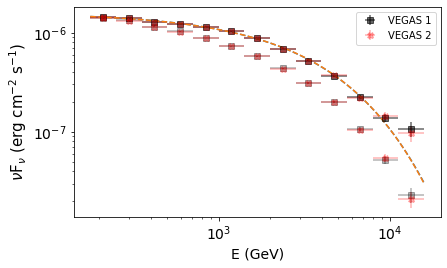

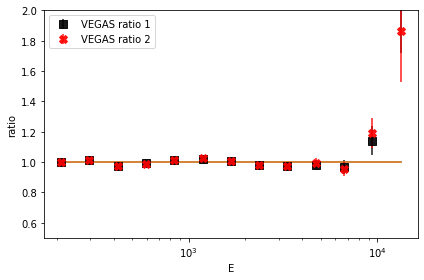

In [245]:
def compVs(f = "Mrk421/M4_VEGAS_spectrum_ITM4tel.txt", 
           f2 = "Mrk421/M4_VEGAS_spectrum_ITM4tel_v2.txt", plot_ratio=True, 
               colors=['k', 'r'], markers=["s","X"], alpha=0.6,
               z=0.031, fitV=False ,
               ax = None, labels=["VEGAS 1", "VEGAS 2"], format_ax=True,
               p0=[3e-14, 1.5, 1e-3,0.1], 
               bounds=([1e-16,1,1e-8,0], [3.e-11, 5., 1e6,100]), 
                       fit_func=plec2_E2_100GeV, 
               model_color='k', model_ls="--", 
               outfile='Mrk421_VEGAS_comp.pdf'):
        if ax is None:
            fig = plt.figure()

            fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)

            ax = fig.add_subplot(111)
            format_ax = True
        for i, file_ in enumerate([f, f2]):
            marker=markers[i]
            color=colors[i]
            label=labels[i]
            c_ = color
            f_ = marker
            df_Vspec = pd.read_csv(file_, sep = r"\s+",  header=None, comment='#', skiprows=1, 
                                names=['+', 'bin' , 'E', 'dE' ,'f' ,'df', 'Non', 'Noff', 'Nexcess', 'RawOff', 
                                       'Alpha', 'Sig', 'Emin', 'Emax'])
            if z > 0:
                f_deabs, df_deabs = deabs_z(df_Vspec["E"], df_Vspec["f"], df_Vspec["df"], z=z)
                df_Vspec["f_deabs"] = f_deabs 
                df_Vspec["df_deabs"] = df_deabs
            else: 
                df_Vspec["f_deabs"] = 0
                df_Vspec["df_deabs"] = 0

            df_Vspec_flux = df_Vspec[df_Vspec['+']=='+']
            df_Vspec_ul = df_Vspec[df_Vspec['+']=='-']
            df_ = df_Vspec[df_Vspec['+']=='+']
            df_ul = df_Vspec[df_Vspec['+']=='-']

            """
            df_combinedV, ax, ps_lp, dps_lp, model, model_err = plot_Vspec(df_Vspec, lat_spec, 
                            z=z, fit=fitV, 
                   ax = ax, tag=tag, format_ax=format_ax, 
                   c_=color, f_='s', l_=label , alpha=alpha, color=color,
                   save_csv=save_csv, 
                            p0=p0, 
                   outfile=outfile, #convert_to_cm=False,
                   model="LP")
            """

            mev2ergs = 1.6e-6
            tev2ergs = 1.6
            if z>0:
                # plot flux (GeV)

                ax.errorbar(df_.E*1e3, df_["f_deabs"]*df_.E*df_.E*tev2ergs, yerr=np.array(df_["df_deabs"]*df_.E*df_.E*tev2ergs),  
                            xerr = [df_['E']*1e3 - df_['Emin']*1e3,  df_['Emax']*1e3-df_['E']*1e3], 
                            color=color, fmt=marker, label=label,
                            #ms=8, 
                            mec=color, ls="",
                            ecolor=color, capthick=0, alpha=alpha)

                # plot UL
                ax.errorbar(df_ul.E*1e3, df_ul["f_deabs"]*df_ul.E*df_ul.E*tev2ergs,
                            xerr = [df_ul['E']*1e3 - df_ul['Emin']*1e3,  df_ul['Emax']*1e3-df_ul['E']*1e3], 
                            yerr=df_ul["f_deabs"]*df_ul.E*df_ul.E*tev2ergs * 3.e-1, uplims=True, 
                            color=c_, marker=f_, label="", 
                            #ms=8, 
                            mec=c_, ls="",
                            ecolor=c_, capthick=0, alpha=alpha/2.)
                alpha=0.3
                l_ = "" # just plot one legend 

            # plot flux (GeV)
            ax.errorbar(df_.E*1e3, df_["f"]*df_.E*df_.E*tev2ergs, yerr=np.array(df_["df"]*df_.E*df_.E*tev2ergs),  
                        xerr = [df_['E']*1e3 - df_['Emin']*1e3,  df_['Emax']*1e3-df_['E']*1e3], 
                        color=c_, fmt=f_, label=l_,
                        #ms=8, 
                        mec=c_, ls="",
                        ecolor=c_, capthick=0, alpha=alpha)

            # plot UL
            ax.errorbar(df_ul.E*1e3, df_ul["f"]*df_ul.E*df_ul.E*tev2ergs,
                        xerr = [df_ul['E']*1e3 - df_ul['Emin']*1e3,  df_ul['Emax']*1e3-df_ul['E']*1e3], 
                        yerr=df_ul["f"]*df_ul.E*df_ul.E*tev2ergs * 3.e-1, uplims=True, 
                        color=c_, marker=f_, label="", 
                        #ms=8, 
                        mec=c_, ls="",
                        ecolor=c_, capthick=0, alpha=alpha-0.2)


            #plotEs = np.logspace(np.log10(df_.Emin[0]*1e3),np.log10(df_.Emax.values[-1]*1e3),100)
            plotEs = np.logspace(np.log10(df_Vspec_flux.Emin[0]*1e3),np.log10(df_Vspec_flux.Emax.values[-1]*1e3),100)
            e_tev_joint = df_Vspec_flux['E'].values*1e3
            f_deabs = df_Vspec_flux['f_deabs']
            df_deabs = df_Vspec_flux['df_deabs']
            #plotEs = np.logspace(np.log10(1e-1),np.log10(3e5),100)
            #plotEs = np.logspace(np.log10(e_tev_joint[0]),np.log10(e_tev_joint[-1]),100)

            #ps_plec, dps_plec, chi2_plec, dof_plec, redchi2_plec = fit_factory(fit_func, 
            ps_plec, dps_plec, chi2_plec, dof_plec, redchi2_plec, x_values, y_low, y_high = fit_factory_boundMC(plec2_E2_100GeV, 
                                                                   e_tev_joint, f_deabs,
                                                                dy=df_deabs, plotEs=plotEs ,
                                                                          p0=[3e-10, 1.5, 1e-3,0.01], 
                                                                            bounds=([1e-14,1,1e-5,0], [3.e-7, 5., 1e3, 10]), )
            
            model_lpV = fit_func(plotEs, *ps_plec)# *plotEs*plotEs            
            ax.plot(plotEs, model_lpV*plotEs*plotEs*tev2ergs*1e-6, mec=c_, ls='--')
            

        if format_ax: 
            ticksize=14
            ax.xaxis.set_tick_params(labelsize=ticksize)
            ax.yaxis.set_tick_params(labelsize=ticksize)


            #ax.ticklabel_format(style='plain', useOffset=False, axis='x') #6panel

            #plt.ticklabel_format(style='plain', useOffset=False, axis='x')

            ax.set_xlabel('E (GeV)', fontsize=14)
            #ax.set_ylabel('dN/dE (TeV$^{-1}$ cm$^{-2}$ s$^{-1}$)', fontsize=14)
            ax.set_ylabel(r'$\nu$F$_\nu$ (erg cm$^{-2}$ s$^{-1}$)', fontsize=15)

            ax.set_xscale('log')
            ax.set_yscale('log')
            plt.legend()

            ticksize=13
            
            plt.savefig(outfile)

        if plot_ratio:
            fig = plt.figure()
            fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15)
            ax1 = fig.add_subplot(111)

            #plotEs = np.logspace(np.log10(0.15e-3),np.log10(25),100)


            #ax1.errorbar(dfrev['E'], dfrev['F'], fake_err,ls="", marker="o")
            #ax1.plot(plotEs, model, color='r', ls='--')
            #df_fit = df_combined[df_combined['F_deabs'] != (np.inf or -np.inf)]
            #df_fit = df_fit[df_fit['F_deabs']<1]
            #df_fit = df_fit[df_fit['dF_deabs']<df_fit['F_deabs']]
            for i, file_ in enumerate([f, f2]):
                marker=markers[i]
                color=colors[i]
                label=labels[i]
                c_ = color
                f_ = marker
                df_Vspec = pd.read_csv(file_, sep = r"\s+",  header=None, comment='#', skiprows=1, 
                                names=['+', 'bin' , 'E', 'dE' ,'f' ,'df', 'Non', 'Noff', 'Nexcess', 'RawOff', 
                                       'Alpha', 'Sig', 'Emin', 'Emax'])
                if z > 0:
                    f_deabs, df_deabs = deabs_z(df_Vspec["E"], df_Vspec["f"], df_Vspec["df"], z=z)
                    df_Vspec["f_deabs"] = f_deabs 
                    df_Vspec["df_deabs"] = df_deabs
                else: 
                    df_Vspec["f_deabs"] = 0
                    df_Vspec["df_deabs"] = 0

                df_Vspec_flux = df_Vspec[df_Vspec['+']=='+']
                df_Vspec_ul = df_Vspec[df_Vspec['+']=='-']
                df_ = df_Vspec[df_Vspec['+']=='+']
                df_ul = df_Vspec[df_Vspec['+']=='-']


                
                e_tev_joint = df_Vspec_flux['E'].values*1e3
                f_deabs = df_Vspec_flux['f_deabs']
                df_deabs = df_Vspec_flux['df_deabs']
                #plotEs = np.logspace(np.log10(1e-1),np.log10(3e5),100)
                plotEs = np.logspace(np.log10(e_tev_joint[0]),np.log10(e_tev_joint[-1]),100)

                #ps_plec, dps_plec, chi2_plec, dof_plec, redchi2_plec = fit_factory(fit_func, 
                ps_plec, dps_plec, chi2_plec, dof_plec, redchi2_plec, x_values, y_low, y_high = fit_factory_boundMC(plec2_E2_100GeV, 
                                                                       e_tev_joint, f_deabs,
                                                                    dy=df_deabs, plotEs=plotEs ,
                                                                          p0=[3e-10, 1.5, 1e-3,0.01], 
                                                                            bounds=([1e-14,1,1e-5,0], [3.e-7, 5., 1e3, 10]), )
            
            
                if i==0: 
                    ps_plec_comp = ps_plec
                print(ps_plec)

                ax1.plot(plotEs, np.ones_like(plotEs))
                model_lpV = fit_func(df_Vspec_flux['E']*1e3, *ps_plec_comp)# *plotEs*plotEs


                print("====check====")
                #print(df_combined['F_deabs'], model_lpE)


                print(df_Vspec_flux["f_deabs"].values/model_lpV.values)
                print(df_Vspec_flux["df_deabs"].values/model_lpV.values)


                ax1.errorbar(df_Vspec_flux['E'].values*1e3, df_Vspec_flux['f_deabs'].values/model_lpV.values, 
                             yerr=df_Vspec_flux['df_deabs'].values/model_lpV.values, color=color, ls='', 
                            ms=8, mec=color,ecolor=color, capthick=0,label="VEGAS ratio {}".format(i+1), alpha=0.9, marker=marker)
                
            ax1.set_xscale('log')
            #ax1.set_yscale('log')
            ax1.set_xlabel("E")
            ax1.set_ylabel("ratio")
            #ax1.set_xlim(1e-1, 30)
            ax1.set_ylim(0.5, 2)
            
            #ax1.set_xlim(5e1, 1e5)
            #ax.set_ylim(2e-12, 3e-10)
            plt.legend()

            plt.tight_layout()
            plt.savefig("ratioM4_VEGAS.pdf")

compVs()

In [ ]:
f = "Mrk421/M4_VEGAS_spectrum_ITM4tel.txt", 
    f2 = "Mrk421/M4_VEGAS_spectrum_ITM4tel_v2.txt"